In [13]:
from copy import deepcopy
from dataclasses import dataclass
from typing import Literal

import numpy as np
from numpy.typing import NDArray

import sklearn as skl
import torch as pt

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns


sns.set_theme(style='darkgrid', palette='muted')

In [15]:
from sklearn.datasets import make_classification

from torch.utils import data


@dataclass()
class Dataset(data.Dataset):
    x: pt.Tensor
    y: pt.Tensor

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __iter__(self):
        return zip(self.x, self.y)
    
    def __len__(self):
        return self.x.shape[0]

    def __repr__(self):
        return f'{type(self)}({self.x.shape})'


def make_dataset(train: int, test: int, sample: int):
    n_samples = train + test + sample
    
    #generate dataset with n_sameples data and 20 features
    x, y = make_classification(n_samples, random_state=42)
    print(x.shape)
    
    x = pt.tensor(x, dtype=pt.float)
    #do the transpose
    y = pt.tensor(y[..., None], dtype=pt.float)
    # y = pt.tensor(y, dtype=pt.float)
    # print(x)
    # print(y)
    
    #do the dataset slice
    i_train = np.s_[:train]
    i_test = np.s_[train:train+test]
    i_sample = np.s_[train+test:]
    d_train = Dataset(x[i_train], y[i_train])
    d_test = Dataset(x[i_test], y[i_test])
    d_sample = Dataset(x[i_sample], y[i_sample])
    return d_train, d_test, d_sample


train, test, sample = make_dataset(100, 100, 2000)
print(train.x.shape)


(2200, 20)
torch.Size([100, 20])


In [16]:
from torch import nn, optim


class LogisticRegression(nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.linear(x)
        x = self.sigmoid(x)
        return x


model = LogisticRegression(train.x.shape[1], 1)
loss_list = []

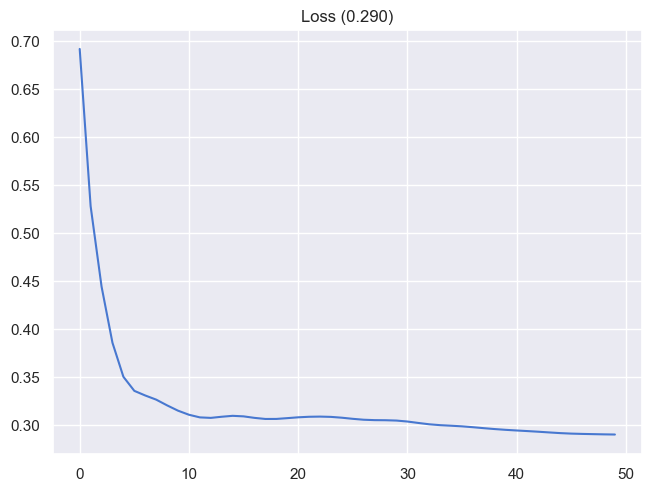

In [17]:
def draw_statistic(*args, mode: Literal['both', 'loss', 'acc'] = 'loss'):
    fig: plt.Figure
    ax: plt.Axes
    ax0: plt.Axes
    ax1: plt.Axes
    if mode == 'both':
        fig, (ax0, ax1) = plt.subplots(
            1, 2,
            sharex=True,
            figsize=(10, 5),
            layout='constrained'
        )
        ax0.plot(args[0], c='C0')
        ax1.plot(args[1], c='C1')
        ax0.set_title(f'Loss ({args[0][-1]:.3f})')
        ax1.set_title(f'Accuracy ({args[1][-1]:.1%})')
    elif mode == 'loss':
        fig, ax = plt.subplots(1, 1, layout='constrained')
        ax.plot(args[0])
        ax.set_title(f'Loss ({args[0][-1]:.3f})')
    elif mode == 'acc':
        fig, ax = plt.subplots(1, 1, layout='constrained')
        ax.plot(args[0])
        ax.set_title(f'Accuracy ({args[0][-1]:.1%})')
    else:
        raise ValueError('mode must be one of both, loss, or acc')


# def training(model: nn.Module, dataset: Dataset, max_epochs: int, loss_list: list | None = None):
def training(model: nn.Module, dataset: Dataset, max_epochs: int, loss_list: list = None):
    loss: pt.Tensor
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), 0.3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)
    model.train()
    for _ in range(max_epochs):
        outputs = model(dataset.x)
        optimizer.zero_grad()
        loss = criterion(outputs, dataset.y)
        loss.backward()
        optimizer.step()
        # optimizer.zero_grad()
        scheduler.step(loss)
        if loss_list is not None:
            loss_list.append(loss.item())
    model.eval()


training(model, train, 50, loss_list)
draw_statistic(loss_list, mode='loss')

In [19]:
class Recourse(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.action = nn.Parameter(pt.zeros(size))

    # def forward(self, x: pt.Tensor, weight: pt.Tensor | None = None):
    def forward(self, x: pt.Tensor, weight: pt.Tensor = None):
        a = self.action
        # print("a",a)
        
        #to be implement
        #add cost funtion weight
        
        if weight is not None:
            a = a * weight
        x = x + a
        return x


# def recourse(c_model: nn.Module, dataset: Dataset, max_epochs: int, weight: pt.Tensor | None = None, loss_list: list | None = None):
def recourse(c_model: nn.Module, dataset: Dataset, max_epochs: int, weight: pt.Tensor = None, loss_list: list = None):
    loss: pt.Tensor
    r_model = Recourse(dataset.x.shape)
    criterion = nn.HuberLoss()
    optimizer = optim.Adam(r_model.parameters(), 0.1)
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

    r_model.train()
    for _ in range(max_epochs):
        optimizer.zero_grad()
        x_hat = r_model(dataset.x, weight)
        y_hat = c_model(x_hat)
        loss = criterion(y_hat, dataset.y)
        loss.backward()
        optimizer.step()
        # optimizer.zero_grad()
        c_model.zero_grad()
        # scheduler.step(loss)
        if loss_list is not None:
            loss_list.append(loss.item())
    r_model.eval()

    with pt.no_grad():
        dataset.x = r_model(dataset.x)

In [20]:
a = nn.Parameter(pt.zeros(train.x.shape))
print(a)
print(a.shape)
# print(model.parameters())
for name,param in model.named_parameters():
    print(name,param)

Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True)
torch.Size([100, 20])
linear.weight Parameter containing:
tensor([[-1.2860e-01, -4.4408e-01,  2.2865e-01, -3.8160e-01,  9.8048e-02,
         -1.8806e+00,  1.3190e-03,  7.2528e-02, -3.9000e-01, -1.2669e-02,
         -1.1253e+00,  3.9463e-01,  1.5764e-01, -4.8736e-03,  1.0921e+00,
          4.3749e-01,  5.0177e-01, -7.2878e-01,  2.1100e+00, -6.8782e-03]],
       requires_grad=True)
linear.bias Parameter containing:
tensor([0.0369], requires_grad=True)


In [21]:
from sklearn.decomposition import PCA

pca = PCA(2).fit(train.x)

In [22]:
from matplotlib.animation import FuncAnimation
from matplotlib.axes import Axes
from matplotlib.figure import Figure, SubFigure
from matplotlib.colors import ListedColormap
from matplotlib.collections import PathCollection
from matplotlib.container import BarContainer
from matplotlib.contour import QuadContourSet
from matplotlib.patches import Rectangle


class PlotHelper:

    palette = sns.color_palette('muted', 2)
    cmap = ListedColormap(palette)

    def __init__(self, model: nn.Module, pca: PCA, train: Dataset, test: Dataset, sample: Dataset):
        self.model = model
        self.pca = pca
        self.train = train
        self.test = test
        self.sample = sample
        self.PDt = []
        self.round = 0
        self.EFTdataframe =  pd.DataFrame(
            {
                'x':train.x.tolist(),
                'y':train.y.flatten(),
                # 'Predict':train.y.flatten(),
                'Predict':[[] for _ in range(len(train.x))],
                'flip_times':np.zeros(len(train.x)),
                'startRounds':np.zeros(len(train.x)),
                'updateRounds':np.zeros(len(train.x)),
                'EFT' : np.zeros(len(train.x)),
                'EFTList': [[] for _ in range(len(train.x))]
            }
        )
        self.failToRecourse = []

        self._hist: list[BarContainer]
        self._bins: NDArray
        self._sc_train: PathCollection
        self._sc_test: PathCollection
        self._ct_test: QuadContourSet

    # def draw_proba_hist(self, ax: Axes | None = None, *, label: bool = False):
    def draw_proba_hist(self, ax: Axes = None, *, label: bool = False):
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 4))
        else:
            fig = ax.get_figure()

        x = self.test.x
        y = self.test.y

        n = x.shape[0]
        m = n - pt.count_nonzero(y)

        with pt.no_grad():
            y_prob: pt.Tensor = self.model(x)

        y = y.flatten()
        y_prob = y_prob.flatten()
        y_prob = y_prob[y.argsort()]

        w = np.broadcast_to(100 / n, n)

        self._hist: list[BarContainer]
        _, self._bins, self._hist = ax.hist(
            (y_prob[:m], y_prob[m:]),
            10,
            (0, 1),
            weights=(w[:m], w[m:]),
            rwidth=1,
            color=self.palette,
            label=(0, 1),
            ec='w',
            alpha=0.9,
        )
        
        ax.legend(loc='upper center', title='True label')
        ax.set_xlabel('mean predicted probabilty')
        ax.set_ylabel('percent')
        ax.set_title('Probability Distribution')

        if label:
            for c in self._hist:
                height = map(Rectangle.get_height, c.patches)
                ax.bar_label(
                    c,
                    [f'{h}%' if h else '' for h in height],
                    fontsize='xx-small'
                )
        return fig, ax

    # def draw_dataset_scatter(self, axes: tuple[Axes, Axes] | None = None):
    def draw_dataset_scatter(self, axes: [Axes, Axes] = None):
        if axes is None:
            fig, (ax0, ax1) = plt.subplots(
                1, 2,
                sharex=True,
                sharey=True,
                figsize=(8, 4),
                layout='compressed'
            )
        else:
            ax0, ax1 = axes
            fig = ax0.get_figure()

        prop = dict(cmap=self.cmap, s=40, vmin=0., vmax=1., lw=0.8, ec='w')

        self._sc_train = ax0.scatter(
            *pca.transform(self.train.x).T,
            c=self.train.y,
            **prop
        )
        ax0.legend(
            *self._sc_train.legend_elements(),
            loc='upper right',
            title='True label'
        )
        ax0.set_xlabel('pca0')
        ax0.set_ylabel('pca1')
        ax0.set_title('Train')

        with pt.no_grad():
            y_prob: pt.Tensor = self.model(test.x)

        y_prob = y_prob.flatten()
        y_pred = y_prob.greater(0.5)

        self._sc_test = ax1.scatter(
            *pca.transform(test.x).T,
            c=y_pred,
            **prop
        )
        ax1.legend(
            *self._sc_test.legend_elements(),
            loc='upper right',
            title='Predicted'
        )

        x0, x1 = ax0.get_xlim()
        y0, y1 = ax0.get_ylim()
        n = 32
        xy = np.mgrid[x0: x1: n * 1j, y0: y1: n * 1j]
        z = pca.inverse_transform(xy.reshape(2, n * n).T)

        z = pt.tensor(z, dtype=pt.float)
        with pt.no_grad():
            z: pt.Tensor = self.model(z)
        z = z.view(n, n)
        self._ct_test = ax1.contourf(
            *xy, z, 10,
            cmap='RdYlBu_r',
            vmin=0,
            vmax=1,
            alpha=0.9,
            zorder=0,
        )
        fig.colorbar(self._ct_test, ax=ax1, label='probability')
        ax1.grid(alpha=0.75)
        ax1.set_xlabel('pca0')
        ax1.set_title('Test')

        return fig, axes

    def draw_all(self):
        sf: list[SubFigure]
        fig = plt.figure(figsize=(8, 8), layout='constrained')
        sf = fig.subfigures(2, 1)
        ax0 = sf[0].subplots()
        ax1, ax2 = sf[1].subplots(1, 2, sharex=True, sharey=True)
        self.draw_proba_hist(ax0)
        self.draw_dataset_scatter((ax1, ax2))
        return fig, (ax0, ax1, ax2)

    def animate_all(self, frames: int = 120, fps: int = 10, *, inplace: bool = False):
        fig, (ax0, ax1, ax2) = self.draw_all()

        model = self.model if inplace else deepcopy(self.model)
        train = self.train if inplace else deepcopy(self.train)
        test = self.test
        sample = self.sample

        def init():
            return *ax0.patches, *ax1.collections, *ax2.collections

        def func(frame):
            fig.suptitle(f'No. {frame}', ha='left', x=0.01, size='small')

            if frame == 0:
                return ()

            self.update(model, train, sample)

            y = test.y.flatten()

            n = test.x.shape[0]
            m = n - pt.count_nonzero(y)

            with pt.no_grad():
                y_prob: pt.Tensor = model(test.x)

            y_prob = y_prob.flatten()
            y_pred = y_prob.greater(0.5)
            rank = y_prob[y.argsort()]

            for b, r in zip(self._hist, (rank[:m], rank[m:])):
                height, _ = np.histogram(r, self._bins)
                for r, h in zip(b.patches, height * (100 / n)):
                    r.set_height(h)

            self._sc_train.set_offsets(pca.transform(train.x))
            self._sc_train.set_array(train.y.flatten())
            self._sc_test.set_array(y_pred)

            ax1.relim()
            ax1.autoscale_view()

            for c in self._ct_test.collections:
                c.remove()

            x0, x1 = ax1.get_xlim()
            y0, y1 = ax1.get_ylim()
            n = 32
            xy = np.mgrid[x0: x1: n * 1j, y0: y1: n * 1j]
            z = pca.inverse_transform(xy.reshape(2, n * n).T)
            z = pt.tensor(z, dtype=pt.float)
            with pt.no_grad():
                z: pt.Tensor = model(z)
            z = z.view(n, n)

            self._ct_test: QuadContourSet = ax2.contourf(
                *xy, z, 10,
                cmap='RdYlBu_r',
                vmin=0,
                vmax=1,
                alpha=0.9,
                zorder=0,
            )

            return *ax0.patches, *ax1.collections, *ax2.collections

        return FuncAnimation(
            fig, func, frames, init,
            interval=1000 // fps,
            repeat=False,
            blit=True,
            cache_frame_data=False
        )

    def draw_PDt(self):

        #每一個round算出來的L2 distance
        tempList = deepcopy(self.PDt)
        # print("PDt: ",self.PDt)
        # print("tempList: ",tempList)
        # [1,2,3,4,5]
        for index,i in enumerate(range(len(self.PDt))):
            temp = 0.0
            #算出PDt
            for j in range(i + 1):
                temp = temp + tempList[j]
            temp = temp / (index + 1)
            # print("temp: ",temp)
            # print(type(temp))
            self.PDt[index] = temp                

        # print("self.PDt: ",self.PDt)

        plt.figure()
        plt.plot(self.PDt)
        plt.xlabel('Round')
        plt.ylabel('PDt')
        plt.title('PDt during Rounds')
        plt.draw()

    def draw_EFT(self,epochs):
        data = []
        labels = [(epochs / 10 - 1) * (i+1) for i in range(10)]
        x = [1,2,3,4,5,6,7,8,9,10]
        # labels = [8 * (i+1) for i in range(12)]
        # x = [1,2,3,4,5,6,7,8,9,10,11,12]
        for i in range((int(epochs / 10)-1),epochs - 1,(int(epochs / 10) - 1)):
        # for i in range(8,100,8):
            # print("i",i)
            roundData = []
            #只顯示經過2輪以上update的model的資料
            # dataframe = self.EFTdataframe[self.EFTdataframe['updateRounds'] > 2]
            dataframe = self.EFTdataframe[i - self.EFTdataframe['startRounds'] >= 2]
            # dataframe = self.EFTdataframe[self.EFTdataframe['flip_times'] > 0].head(10)
            for j in dataframe.index:
                # print("index: ",j)
                #判斷開始的Round是否合理
                if dataframe.at[j,'startRounds'] < i:
                    # print("index j append: ",j)
                    temp = dataframe.at[j,'EFTList']
                    roundData.append(temp[i - 1])
                # data.append([temp[i]])
                # self.EFTdataframe.at[i,'EFPList'].append(self.EFTdataframe.at[i,'flip_times'] / self.EFTdataframe.at[i,'rounds'])
            # print(data)
            data.append(roundData)
        plt.figure()
        # sns.boxplot(x='rounds',y='EFPList',data = self.EFTdataframe)
        plt.boxplot(data)
        plt.xticks(x,labels)
        plt.xlabel('Round')
        plt.ylabel('EFT')
    
    def calculateR20EFT(self,tempPredict,updateRounds):
        last = tempPredict[0]
        flipTimes = 0
        for i in range(len(tempPredict) - 1):
            if(last != tempPredict[i + 1]):
                flipTimes += 1
            last = tempPredict[i + 1]
        # print("R20_EFT value: ",flipTimes / updateRounds)
        return flipTimes / updateRounds
        
    def draw_R20_EFT(self,epochs,intervalRounds):
        data = []
        labels = [i for i in range(intervalRounds,epochs,intervalRounds)]
        x = [i for i in range(1,len(labels) + 1)]
        # labels = [(int(epochs / 10) - 1) * (i+1) for i in range(10)]
        # x = [1,2,3,4,5,6,7,8,9,10]
        
        # for i in range((int(epochs / 10)-1),epochs - 1,(int(epochs / 10) - 1)):
        for i in range(intervalRounds,epochs - 1,intervalRounds):
            # print("i's round:",i)
            roundData = []
            # dataframe = self.EFTdataframe[self.EFTdataframe['updateRounds'] > 2]
            dataframe = self.EFTdataframe[i - self.EFTdataframe['startRounds'] >= 2]
            # print("R20's EFTdataframe")
            # display(dataframe)
            for j in dataframe.index:
                startRounds = int(dataframe.at[j,'startRounds'])
                if startRounds < i:
                    #dataframe['Predict'][0]代表從第predictRound開始做預測
                    print("startRound : ",startRounds)

                    if startRounds >= i - intervalRounds:
                        startIndex = 0
                    else:
                        # startIndex = ((i - (int(epochs / 10) - 1)) - startRounds) - 1
                        startIndex = ((i - intervalRounds) - startRounds) - 1
                    
                    endIndex = (i - startRounds)
                    # print("Predict array: ",dataframe.at[j,'Predict'])
                    # print("startIndex: ",startIndex)
                    # print("endIndex : ",endIndex)
                    tempPredict = dataframe.at[j,'Predict'][startIndex:endIndex]
                    
                    roundData.append(self.calculateR20EFT(tempPredict,len(tempPredict)))
                    

            data.append(roundData)
        plt.figure()
        # sns.boxplot(x='rounds',y='EFPList',data = self.EFTdataframe)
        plt.boxplot(data)
        plt.xticks(x,labels)
        plt.xlabel('Round')
        plt.ylabel('R20_EFT')
    
    def draw_Fail_to_Recourse(self):
        plt.figure()
        plt.plot(self.failToRecourse)
        plt.xlabel('Round')
        plt.ylabel('Fail_to_Recourse')
        plt.title('FtR during Rounds')
        plt.draw()
    
    #紀錄新增進來的sample資料    
    def addEFTDataFrame(self,index):
        if self.EFTdataframe.at[0,'updateRounds'] != 0:
            sampleDataframe =  pd.DataFrame(
                {
                    'x':self.train.x[index].tolist(),
                    'y':self.train.y[index].flatten(),
                    # 'Predict':np.nan,
                    # 'Predict':self.train.y[index].flatten(),
                    'Predict':[ [] for _ in range(len(train.y[index]))],
                    'flip_times':np.zeros(len(self.train.y[index])),
                    'startRounds':np.full(len(self.train.y[index]),int(self.EFTdataframe.at[0,'updateRounds'])),
                    'updateRounds':np.zeros(len(self.train.y[index])),
                    'EFT' : np.zeros(len(self.train.y[index])),
                    # 'EFPList': [np.zeros(int(self.EFTdataframe.at[0,'rounds'])) for _ in range(len(train.y[index]))]
                    'EFTList': [ [0.0] * int(self.EFTdataframe.at[0,'updateRounds']) for _ in range(len(self.train.y[index]))]
                }
            )
        else:
            sampleDataframe =  pd.DataFrame(
                {
                    'x':self.train.x[index].tolist(),
                    'y':self.train.y[index].flatten(),
                    # 'Predict':np.nan,
                    # 'Predict':self.train.y[index].flatten(),
                    'Predict':[ [] for _ in range(len(train.y[index]))],
                    'flip_times':np.zeros(len(self.train.y[index])),
                    'startRounds':np.zeros(len(self.train.y[index])),
                    'updateRounds':np.zeros(len(self.train.y[index])),
                    'EFT' : np.zeros(len(self.train.y[index])),
                    'EFTList': [ [] for _ in range(len(self.train.y[index]))]
                }
            )
        # display(sampleDataframe)
        self.EFTdataframe = pd.concat([self.EFTdataframe,sampleDataframe],ignore_index=True)

    def update(self, model: nn.Module, train: Dataset, sample: Dataset):
        raise NotImplementedError()


# helper = PlotHelper(model, pca, train, test, sample)
# helper.draw_all()
# plt.show()

IndexError: list index out of range

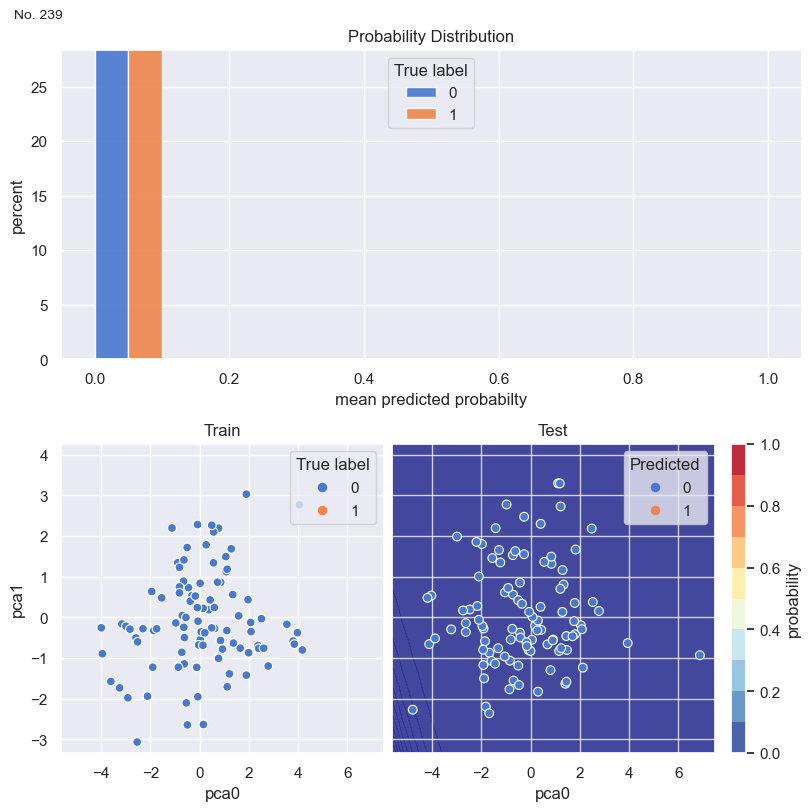

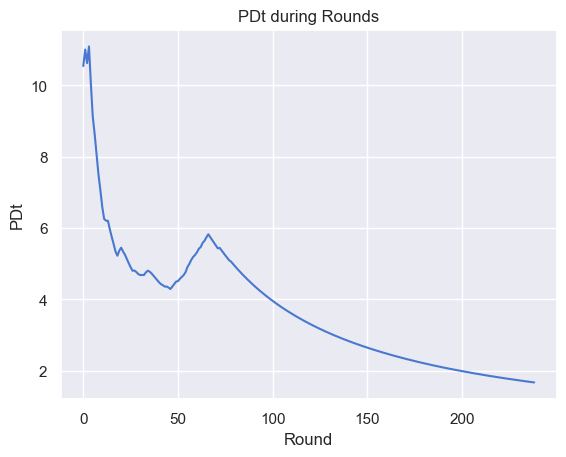

In [27]:
class Example1(PlotHelper):
    '''
    Update Method Steps:
    1. Selects a random subset of `sample` with a approximately size of `train.size * 0.02`.
    2. Performs recourse on the selected subset of 'sample' while preserving their original labels.
    3. Replaces a corresponding part of the training set with the updated samples.
    4. Refits the model with the modified training data.
    '''
    
    #add first k              k maybe 40% 80% 100%

    def update(self, model: nn.Module, train: Dataset, sample: Dataset):
        modelParams = list(model.parameters())
        weights = deepcopy(modelParams[0].data.reshape(-1))
        bias = deepcopy(modelParams[1].data)
        # print("Before update: ")
        # print(weights,bias)
            
        
        size = train.x.shape[0] // 4
        i = np.random.choice(sample.x.shape[0], size, False)
        x = sample.x[i]
        # print("x:",x)

        with pt.no_grad():
            y_prob: pt.Tensor = model(x)

        # print("predict: ",y_prob.data)
        y_pred = y_prob.flatten() < 0.5
        sub_sample = Dataset(x[y_pred], pt.ones((y_pred.count_nonzero(), 1)))

        recourse(model, sub_sample, 10)
        # recourse(model, sub_sample, 10,None,None)

        x[y_pred] = sub_sample.x

        j = np.random.choice(train.x.shape[0], size, False)
        train.x[j] = x
        train.y[j, 0] = (~y_pred).float()
        
        #紀錄新增進來的sample資料
        self.addEFTDataFrame(j)
       

        training(model, train, 50)
        self.EFTdataframe = self.EFTdataframe.assign(rounds = self.EFTdataframe['updateRounds'] + 1)
        self.round = self.round + 1
        
        
         #updated model predict the data with new sample
        data = np.vstack(self.EFTdataframe['x'])
        with pt.no_grad():
            y_pred = model(pt.tensor(data,dtype = pt.float))
        # print(y_pred)
        predictValue = deepcopy(y_pred.data)
        predictValue[predictValue > 0.5] = 1.0
        predictValue[predictValue < 0.5] = 0.0
        predictValue = predictValue.numpy().T.reshape(-1)
        # print("predictValue: ",predictValue)
        # print("data type: ",type(predictValue))
        for i in self.EFTdataframe.index:
            # for j in predictValue.numpy().T.reshape(-1):
            self.EFTdataframe.at[i,'Predict'].append(predictValue[i])
         # self.EFTdataframe.loc[predictValue.numpy().T.reshape(-1) != self.EFTdataframe['Predict'],['flip_times']] += 1
        for i in self.EFTdataframe.index:
            predictLength = len(self.EFTdataframe.at[i,'Predict'])
            # if predictLength > 1 and (self.EFTdataframe.at[i,'Predict'][predictLength - 2] != self.EFTdataframe.at[i,'Predict'][predictLength - 1]):
            if predictLength > 1 and (self.EFTdataframe.at[i,'Predict'][-2] != self.EFTdataframe.at[i,'Predict'][-1]):
                # self.EFTdataframe.loc[(self.EFTdataframe['rounds'] - self.EFTdataframe['startRounds'] > 1) and self.EFTdataframe['Predict'][self.round - 2] != self.EFTdataframe['Predict'][self.round - 1] ,['flip_times']] += 1
                self.EFTdataframe.at[i,'flip_times'] += 1
        #update EFP values
        # self.EFTdataframe['EFT'] = self.EFTdataframe['flip_times'] / self.EFTdataframe['rounds']
        self.EFTdataframe.loc[(self.EFTdataframe['updateRounds'] - 1) > 0,['EFT']] = self.EFTdataframe['flip_times'] / (self.EFTdataframe['updateRounds'] - 1)
        
        for i in self.EFTdataframe.index:
            if len(self.EFTdataframe.at[i,'Predict']) > 1:
                # self.EFTdataframe.at[i,'EFTList'].append(self.EFTdataframe.at[i,'flip_times'] / self.EFTdataframe.at[i,'rounds'])
                self.EFTdataframe.at[i,'EFTList'].append(self.EFTdataframe.at[i,'EFT'])
        # #updated model predict the data with new sample
        # data = np.vstack(self.EFTdataframe['x'])
        # with pt.no_grad():
        #     y_pred = model(pt.tensor(data,dtype = pt.float))
        # # print(y_pred)
        # predictValue = deepcopy(y_pred.data)
        # predictValue[predictValue > 0.5] = 1.0
        # predictValue[predictValue < 0.5] = 0.0
        # # print(predictValue)
        # self.EFTdataframe = self.EFTdataframe.assign(Predict = predictValue)

        # #update flip_times
        # self.EFTdataframe.loc[self.EFTdataframe['y'] != self.EFTdataframe['Predict'],['flip_times']] += 1

        # #update EFP values
        # self.EFTdataframe['EFT'] = self.EFTdataframe['flip_times'] / self.EFTdataframe['rounds']
        
        # for i in self.EFTdataframe.index:
        #     self.EFTdataframe.at[i,'EFTList'].append(self.EFTdataframe.at[i,'flip_times'] / self.EFTdataframe.at[i,'rounds'])
        # # display(self.EFTdataframe[self.EFTdataframe['flip_times'] > 0])
        # display(self.EFTdataframe)
        
        #calculate the PDt
        modelParams = list(model.parameters())
        modelParameter = np.concatenate((weights,bias))
        resultParameter = np.concatenate((modelParams[0].data.reshape(-1),modelParams[1].data))
        # print("Before update: ")
        # print(weights,bias)
        # print("After update: ")
        # print(modelParams[0].data.reshape(-1),modelParams[1].data)

        parameterL2 = np.linalg.norm(resultParameter - modelParameter)

        self.PDt.append(parameterL2)

# print(train.x)
# print(train.y)
ex1 = Example1(model, pca, train, test, sample)
ani1 = ex1.animate_all(240)
ani1.save('output/ex1.gif')

# ex1.draw_PDt()
# ex1.draw_EFT()
ex1.draw_PDt()
ex1.draw_EFT(240)
ex1.draw_R20_EFT(240,23)
ex1.draw_R20_EFT(240,40)
ex1.draw_R20_EFT(240,58)
display(ex1.EFTdataframe)


In [ ]:
class Example6(PlotHelper):
    '''
    Update Method Steps:
    1. Selects a random subset of `sample` with a size of `train.size * 0.02`.
    2. Performs recourse on the selected samples.
    3. Randomly relabels samples based on the model's probability scores.
    4. Replaces a corresponding part of the training set with the updated samples.
    5. Refits the model with the modified training data.
    '''
    
    def update(self, model: nn.Module, train: Dataset, sample: Dataset):
        size = train.x.shape[0] // 10
        i = np.random.choice(sample.x.shape[0], size, False)
        x = sample.x[i]

        with pt.no_grad():
            y_prob: pt.Tensor = model(x)

        y_pred = y_prob.flatten() < 0.5
        sub_sample = Dataset(x[y_pred], pt.full((y_pred.count_nonzero(), 1), 0.6))

        recourse(model, sub_sample, 5)

        x[y_pred] = sub_sample.x

        j = np.random.choice(train.x.shape[0], size, False)

        with pt.no_grad():
            y_prob: pt.Tensor = model(x)

        train.x[j] = x
        train.y[j] = (pt.rand_like(y_prob) > y_prob).float()

        training(model, train, 20)


ex6 = Example6(model, pca, train, test, sample)
ani5 = ex6.animate_all(200)
ani5.save('output/ex5.mp4')

In [ ]:
class Example6(PlotHelper):
    '''
    Update Method Steps:
    1. Selects a random subset of `sample` with a size of `train.size * 0.02`.
    2. Performs recourse on the selected samples.
    3. Randomly relabels samples based on the model's probability scores.
    4. Replaces a corresponding part of the training set with the updated samples.
    5. Refits the model with the modified training data.
    '''
    def update(self, model: nn.Module, train: Dataset, sample: Dataset):
        size = train.x.shape[0] // 10
        i = np.random.choice(sample.x.shape[0], size, False)
        x = sample.x[i]

        with pt.no_grad():
            y_prob: pt.Tensor = model(x)

        y_pred = y_prob.flatten() < 0.5
        sub_sample = Dataset(x[y_pred], pt.full((y_pred.count_nonzero(), 1), 0.6))

        recourse(model, sub_sample, 5, weight)

        x[y_pred] = sub_sample.x

        j = np.random.choice(train.x.shape[0], size, False)

        with pt.no_grad():
            y_prob: pt.Tensor = model(x)

        train.x[j] = x
        train.y[j] = (pt.rand_like(y_prob) > y_prob).float()

        training(model, train, 20)


weight = pt.arange(1, train.x.shape[1] + 1)
print(weight)
# pt.randn(train.x.shape[1])
ex6 = Example6(model, pca, train, test, sample)
ani6 = ex6.animate_all(200)
ani6.save('output/ex6.mp4')

binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,[1.0],0.0,0.0,1.0,0.0,[]
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,[1.0],0.0,0.0,1.0,0.0,[]
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,[1.0],0.0,0.0,1.0,0.0,[]
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,[1.0],0.0,0.0,1.0,0.0,[]
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,[1.0],0.0,0.0,1.0,0.0,[]
...,...,...,...,...,...,...,...,...
105,"[0.78657066822052, 1.7073811292648315, 0.36712...",1.0,[1.0],0.0,0.0,1.0,0.0,[]
106,"[0.08795009553432465, -1.0686280727386475, 0.1...",0.0,[0.0],0.0,0.0,1.0,0.0,[]
107,"[1.6772005558013916, 0.21907156705856323, 0.38...",0.0,[0.0],0.0,0.0,1.0,0.0,[]
108,"[0.16769152879714966, 0.508087694644928, -0.32...",0.0,[0.0],0.0,0.0,1.0,0.0,[]


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0]",0.0,0.0,2.0,0.0,[0.0]
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0]",0.0,0.0,2.0,0.0,[0.0]
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0]",0.0,0.0,2.0,0.0,[0.0]
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0]",0.0,0.0,2.0,0.0,[0.0]
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0]",0.0,0.0,2.0,0.0,[0.0]
...,...,...,...,...,...,...,...,...
115,"[0.39704665541648865, -0.31267717480659485, 0....",0.0,[0.0],0.0,1.0,1.0,0.0,[0.0]
116,"[-1.4168235063552856, -0.6032968759536743, 0.7...",0.0,[1.0],0.0,1.0,1.0,0.0,[0.0]
117,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,[1.0],0.0,1.0,1.0,0.0,[0.0]
118,"[0.1485310196876526, -0.9968671202659607, -0.2...",1.0,[1.0],0.0,1.0,1.0,0.0,[0.0]


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0]",1.0,0.0,3.0,0.5,"[0.0, 0.5]"
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0]",0.0,0.0,3.0,0.0,"[0.0, 0.0]"
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0]",0.0,0.0,3.0,0.0,"[0.0, 0.0]"
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0]",0.0,0.0,3.0,0.0,"[0.0, 0.0]"
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0]",0.0,0.0,3.0,0.0,"[0.0, 0.0]"
...,...,...,...,...,...,...,...,...
125,"[0.2447846233844757, -2.9538235664367676, 0.20...",1.0,[1.0],0.0,2.0,1.0,0.0,"[0.0, 0.0]"
126,"[-0.37439003586769104, -1.5144140720367432, -0...",0.0,[1.0],0.0,2.0,1.0,0.0,"[0.0, 0.0]"
127,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,[1.0],0.0,2.0,1.0,0.0,"[0.0, 0.0]"
128,"[0.9172489047050476, 1.168365240097046, 0.1266...",1.0,[1.0],0.0,2.0,1.0,0.0,"[0.0, 0.0]"


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0]",1.0,0.0,4.0,0.333333,"[0.0, 0.5, 0.3333333333333333]"
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0]",0.0,0.0,4.0,0.000000,"[0.0, 0.0, 0.0]"
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0]",1.0,0.0,4.0,0.333333,"[0.0, 0.0, 0.3333333333333333]"
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0]",0.0,0.0,4.0,0.000000,"[0.0, 0.0, 0.0]"
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0]",0.0,0.0,4.0,0.000000,"[0.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...,...
135,"[0.7854825854301453, 1.4801831245422363, -0.34...",0.0,[1.0],0.0,3.0,1.0,0.000000,"[0.0, 0.0, 0.0]"
136,"[-1.1341276168823242, -1.3362696170806885, -0....",1.0,[0.0],0.0,3.0,1.0,0.000000,"[0.0, 0.0, 0.0]"
137,"[0.08189667761325836, 0.05966189503669739, 2.0...",1.0,[1.0],0.0,3.0,1.0,0.000000,"[0.0, 0.0, 0.0]"
138,"[1.6772005558013916, 0.21907156705856323, 0.38...",0.0,[0.0],0.0,3.0,1.0,0.000000,"[0.0, 0.0, 0.0]"


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0]",1.0,0.0,5.0,0.25,"[0.0, 0.5, 0.3333333333333333, 0.25]"
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0]",0.0,0.0,5.0,0.00,"[0.0, 0.0, 0.0, 0.0]"
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0]",1.0,0.0,5.0,0.25,"[0.0, 0.0, 0.3333333333333333, 0.25]"
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0]",0.0,0.0,5.0,0.00,"[0.0, 0.0, 0.0, 0.0]"
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0]",0.0,0.0,5.0,0.00,"[0.0, 0.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...,...
145,"[0.6403371095657349, 0.9779082536697388, 1.213...",0.0,[0.0],0.0,4.0,1.0,0.00,"[0.0, 0.0, 0.0, 0.0]"
146,"[0.0779372975230217, 1.11386239528656, -1.1041...",0.0,[0.0],0.0,4.0,1.0,0.00,"[0.0, 0.0, 0.0, 0.0]"
147,"[-0.2284725457429886, -0.3633120059967041, 0.9...",0.0,[0.0],0.0,4.0,1.0,0.00,"[0.0, 0.0, 0.0, 0.0]"
148,"[0.78657066822052, 1.7073811292648315, 0.36712...",1.0,[1.0],0.0,4.0,1.0,0.00,"[0.0, 0.0, 0.0, 0.0]"


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0]",1.0,0.0,6.0,0.2,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2]"
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",0.0,0.0,6.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0]"
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0]",2.0,0.0,6.0,0.4,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4]"
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",0.0,0.0,6.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0]"
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",0.0,0.0,6.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...,...
155,"[1.8908404111862183, 1.170678734779358, 0.4180...",1.0,[1.0],0.0,5.0,1.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0]"
156,"[0.8569755554199219, -0.18509764969348907, 0.9...",0.0,[0.0],0.0,5.0,1.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0]"
157,"[0.7020303010940552, 0.4283529222011566, -0.46...",0.0,[0.0],0.0,5.0,1.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0]"
158,"[-1.0168944597244263, -1.700072169303894, -0.8...",0.0,[0.0],0.0,5.0,1.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0]"


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",1.0,0.0,7.0,0.166667,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",0.0,0.0,7.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0]",3.0,0.0,7.0,0.500000,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5]"
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",0.0,0.0,7.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",0.0,0.0,7.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...,...
165,"[-1.4106119871139526, 0.7384451627731323, 1.30...",1.0,[0.0],0.0,6.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
166,"[0.9078524112701416, -0.16648557782173157, -0....",0.0,[1.0],0.0,6.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
167,"[-0.4676095247268677, 1.378357172012329, -0.41...",1.0,[0.0],0.0,6.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
168,"[-0.3423808515071869, -0.1938551515340805, 0.5...",0.0,[0.0],0.0,6.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",2.0,0.0,8.0,0.285714,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",0.0,0.0,8.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0]",3.0,0.0,8.0,0.428571,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",0.0,0.0,8.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",0.0,0.0,8.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...,...
175,"[-0.8128235936164856, -2.074486255645752, 1.62...",0.0,[1.0],0.0,7.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
176,"[-0.022377334535121918, -0.21068492531776428, ...",1.0,[0.0],0.0,7.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
177,"[0.08795009553432465, -1.0686280727386475, 0.1...",0.0,[1.0],0.0,7.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
178,"[0.05197172611951828, 0.6752124428749084, 0.03...",0.0,[1.0],0.0,7.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",3.0,0.0,9.0,0.375,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",0.0,0.0,9.0,0.000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",3.0,0.0,9.0,0.375,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",0.0,0.0,9.0,0.000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",0.0,0.0,9.0,0.000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...,...
185,"[-2.527165651321411, 0.8646224141120911, 1.600...",1.0,[0.0],0.0,8.0,1.0,0.000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
186,"[0.8583512306213379, 0.9979543089866638, 0.166...",1.0,[1.0],0.0,8.0,1.0,0.000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
187,"[0.5090683698654175, 0.1449059396982193, 1.883...",0.0,[0.0],0.0,8.0,1.0,0.000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
188,"[0.08795009553432465, -1.0686280727386475, 0.1...",0.0,[1.0],0.0,8.0,1.0,0.000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",4.0,0.0,10.0,0.444444,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.0,0.0,10.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",3.0,0.0,10.0,0.333333,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.0,0.0,10.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.0,0.0,10.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...,...
195,"[-1.925642967224121, -0.4310844838619232, 1.27...",1.0,[0.0],0.0,9.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
196,"[1.2692556381225586, 0.1633346825838089, 0.881...",0.0,[1.0],0.0,9.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
197,"[0.6233422756195068, -0.9766203165054321, -1.1...",0.0,[0.0],0.0,9.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
198,"[-0.7930728197097778, 1.0084487199783325, 1.18...",1.0,[0.0],0.0,9.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",4.0,0.0,11.0,0.4,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.0,0.0,11.0,0.1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",3.0,0.0,11.0,0.3,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.0,0.0,11.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.0,0.0,11.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
205,"[-2.191253900527954, -0.45976462960243225, -0....",0.0,[0.0],0.0,10.0,1.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
206,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,[0.0],0.0,10.0,1.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
207,"[0.05197172611951828, 0.6752124428749084, 0.03...",0.0,[1.0],0.0,10.0,1.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
208,"[-2.351223945617676, -0.11792437732219696, -0....",0.0,[0.0],0.0,10.0,1.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",4.0,0.0,12.0,0.363636,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2.0,0.0,12.0,0.181818,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",3.0,0.0,12.0,0.272727,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.0,0.0,12.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.0,0.0,12.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
215,"[0.16769152879714966, 0.508087694644928, -0.32...",0.0,[0.0],0.0,11.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
216,"[0.0863986387848854, -1.3315123319625854, 2.34...",1.0,[1.0],0.0,11.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
217,"[1.2692556381225586, 0.1633346825838089, 0.881...",0.0,[0.0],0.0,11.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
218,"[-1.3866779804229736, -1.3420578241348267, -0....",1.0,[1.0],0.0,11.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",4.0,0.0,13.0,0.333333,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2.0,0.0,13.0,0.166667,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",4.0,0.0,13.0,0.333333,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.0,0.0,13.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.0,0.0,13.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
225,"[-0.7930728197097778, 1.0084487199783325, 1.18...",1.0,[1.0],0.0,12.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
226,"[-1.4467906951904297, -0.33535706996917725, 1....",1.0,[0.0],0.0,12.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
227,"[-1.2159669399261475, -0.041672736406326294, -...",1.0,[0.0],0.0,12.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
228,"[0.0863986387848854, -1.3315123319625854, 2.34...",1.0,[0.0],0.0,12.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",4.0,0.0,14.0,0.307692,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2.0,0.0,14.0,0.153846,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",5.0,0.0,14.0,0.384615,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.0,0.0,14.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.0,0.0,14.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
235,"[-1.3866779804229736, -1.3420578241348267, -0....",1.0,[1.0],0.0,13.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
236,"[-1.0168944597244263, -1.700072169303894, -0.8...",0.0,[0.0],0.0,13.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
237,"[0.7854825854301453, 1.4801831245422363, -0.34...",0.0,[1.0],0.0,13.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
238,"[1.5926899909973145, -1.670881986618042, -0.51...",1.0,[1.0],0.0,13.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",4.0,0.0,15.0,0.285714,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2.0,0.0,15.0,0.142857,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",5.0,0.0,15.0,0.357143,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.0,0.0,15.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.0,0.0,15.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
245,"[0.0863986387848854, -1.3315123319625854, 2.34...",1.0,[0.0],0.0,14.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
246,"[-0.5038936734199524, -1.4821275472640991, 0.3...",1.0,[0.0],0.0,14.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
247,"[0.7854825854301453, 1.4801831245422363, -0.34...",0.0,[1.0],0.0,14.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
248,"[1.1358674764633179, -0.1468881070613861, -0.2...",0.0,[0.0],0.0,14.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",5.0,0.0,16.0,0.333333,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",3.0,0.0,16.0,0.200000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",5.0,0.0,16.0,0.333333,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.0,0.0,16.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.0,0.0,16.0,0.066667,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
255,"[1.0480836629867554, 0.794426679611206, -0.609...",0.0,[1.0],0.0,15.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
256,"[-0.6081535220146179, -1.2433587312698364, -0....",1.0,[0.0],0.0,15.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
257,"[0.78657066822052, 1.7073811292648315, 0.36712...",1.0,[1.0],0.0,15.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
258,"[-0.2596779763698578, 1.002809762954712, 1.662...",1.0,[1.0],0.0,15.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",5.0,0.0,17.0,0.3125,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",3.0,0.0,17.0,0.1875,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",5.0,0.0,17.0,0.3125,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.0,0.0,17.0,0.0000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.0,0.0,17.0,0.0625,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
265,"[1.5926899909973145, -1.670881986618042, -0.51...",1.0,[1.0],0.0,16.0,1.0,0.0000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
266,"[2.5878305435180664, 2.68530535697937, -0.3894...",0.0,[1.0],0.0,16.0,1.0,0.0000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
267,"[-0.7133108973503113, 1.7347627878189087, 0.43...",0.0,[1.0],0.0,16.0,1.0,0.0000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
268,"[-1.3866779804229736, -1.3420578241348267, -0....",1.0,[0.0],0.0,16.0,1.0,0.0000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",5.0,0.0,18.0,0.294118,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",4.0,0.0,18.0,0.235294,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",5.0,0.0,18.0,0.294118,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.0,0.0,18.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2.0,0.0,18.0,0.117647,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
275,"[0.4784587025642395, 0.05013802647590637, 0.90...",1.0,[1.0],0.0,17.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
276,"[0.2066597044467926, 0.6290826201438904, 1.129...",0.0,[1.0],0.0,17.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
277,"[0.6233422756195068, -0.9766203165054321, -1.1...",0.0,[1.0],0.0,17.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
278,"[-2.1027016639709473, 0.4215136468410492, 0.33...",1.0,[0.0],0.0,17.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",6.0,0.0,19.0,0.333333,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",5.0,0.0,19.0,0.277778,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",5.0,0.0,19.0,0.277778,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.0,0.0,19.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",3.0,0.0,19.0,0.166667,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
285,"[0.16769152879714966, 0.508087694644928, -0.32...",0.0,[0.0],0.0,18.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
286,"[1.256520390510559, -0.7665912508964539, -1.08...",1.0,[1.0],0.0,18.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
287,"[-1.4106119871139526, 0.7384451627731323, 1.30...",1.0,[0.0],0.0,18.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
288,"[0.0488484650850296, -0.23657293617725372, -0....",0.0,[1.0],0.0,18.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",7.0,0.0,20.0,0.368421,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",6.0,0.0,20.0,0.315789,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",5.0,0.0,20.0,0.263158,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.0,0.0,20.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",4.0,0.0,20.0,0.210526,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
295,"[-2.1027016639709473, 0.4215136468410492, 0.33...",1.0,[0.0],0.0,19.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
296,"[0.0488484650850296, -0.23657293617725372, -0....",0.0,[1.0],0.0,19.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
297,"[2.121631383895874, 0.1580938994884491, 0.7297...",0.0,[1.0],0.0,19.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
298,"[0.6964829564094543, 0.10022523254156113, 0.21...",0.0,[1.0],0.0,19.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",8.0,0.0,21.0,0.40,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",6.0,0.0,21.0,0.30,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",5.0,0.0,21.0,0.25,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.0,0.0,21.0,0.00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",5.0,0.0,21.0,0.25,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
305,"[0.032396212220191956, 1.0725418329238892, -2....",0.0,[0.0],0.0,20.0,1.0,0.00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
306,"[-0.6081535220146179, -1.2433587312698364, -0....",1.0,[0.0],0.0,20.0,1.0,0.00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
307,"[0.78657066822052, 1.7073811292648315, 0.36712...",1.0,[1.0],0.0,20.0,1.0,0.00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
308,"[-0.7930728197097778, 1.0084487199783325, 1.18...",1.0,[0.0],0.0,20.0,1.0,0.00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",8.0,0.0,22.0,0.380952,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",6.0,0.0,22.0,0.285714,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",6.0,0.0,22.0,0.285714,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.0,0.0,22.0,0.047619,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",5.0,0.0,22.0,0.238095,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
315,"[0.5484632849693298, -0.1604500412940979, 0.76...",0.0,[1.0],0.0,21.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
316,"[-0.3423808515071869, -0.1938551515340805, 0.5...",0.0,[0.0],0.0,21.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
317,"[-1.522334337234497, 0.012169682420790195, -2....",0.0,[0.0],0.0,21.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
318,"[0.8074191808700562, -0.08900053799152374, 0.5...",0.0,[0.0],0.0,21.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",8.0,0.0,23.0,0.363636,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",6.0,0.0,23.0,0.272727,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",6.0,0.0,23.0,0.272727,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.0,0.0,23.0,0.045455,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",5.0,0.0,23.0,0.227273,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
325,"[0.9379895925521851, 1.0759341716766357, 0.616...",1.0,[0.0],0.0,22.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
326,"[-1.4467906951904297, -0.33535706996917725, 1....",1.0,[0.0],0.0,22.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
327,"[-1.1151034832000732, -0.3470640480518341, -1....",1.0,[0.0],0.0,22.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
328,"[1.2692556381225586, 0.1633346825838089, 0.881...",0.0,[1.0],0.0,22.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",8.0,0.0,24.0,0.347826,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",6.0,0.0,24.0,0.260870,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",6.0,0.0,24.0,0.260870,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.0,0.0,24.0,0.043478,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",5.0,0.0,24.0,0.217391,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
335,"[1.2692556381225586, 0.1633346825838089, 0.881...",0.0,[0.0],0.0,23.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
336,"[0.780222475528717, 0.2059607207775116, 0.7508...",1.0,[1.0],0.0,23.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
337,"[0.5484632849693298, -0.1604500412940979, 0.76...",0.0,[1.0],0.0,23.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
338,"[0.6964829564094543, 0.10022523254156113, 0.21...",0.0,[1.0],0.0,23.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",8.0,0.0,25.0,0.333333,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",6.0,0.0,25.0,0.250000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",6.0,0.0,25.0,0.250000,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.0,0.0,25.0,0.041667,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",6.0,0.0,25.0,0.250000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
345,"[0.2447846233844757, -2.9538235664367676, 0.20...",1.0,[0.0],0.0,24.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
346,"[2.5878305435180664, 2.68530535697937, -0.3894...",0.0,[0.0],0.0,24.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
347,"[0.0779372975230217, 1.11386239528656, -1.1041...",0.0,[1.0],0.0,24.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
348,"[-0.5054495334625244, 0.17281228303909302, -0....",1.0,[1.0],0.0,24.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",8.0,0.0,26.0,0.32,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",6.0,0.0,26.0,0.24,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",6.0,0.0,26.0,0.24,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.0,0.0,26.0,0.04,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",6.0,0.0,26.0,0.24,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
355,"[-0.2530868351459503, -0.5911468267440796, 0.1...",0.0,[0.0],0.0,25.0,1.0,0.00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
356,"[-1.3866779804229736, -1.3420578241348267, -0....",1.0,[0.0],0.0,25.0,1.0,0.00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
357,"[-0.26178768277168274, -0.03193388879299164, 0...",1.0,[1.0],0.0,25.0,1.0,0.00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
358,"[1.2692556381225586, 0.1633346825838089, 0.881...",0.0,[1.0],0.0,25.0,1.0,0.00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",8.0,0.0,27.0,0.307692,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",6.0,0.0,27.0,0.230769,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",6.0,0.0,27.0,0.230769,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.0,0.0,27.0,0.038462,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",6.0,0.0,27.0,0.230769,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
365,"[0.05304703116416931, 0.8849626779556274, -1.4...",1.0,[0.0],0.0,26.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
366,"[0.78657066822052, 1.7073811292648315, 0.36712...",1.0,[1.0],0.0,26.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
367,"[0.6964829564094543, 0.10022523254156113, 0.21...",0.0,[1.0],0.0,26.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
368,"[-0.6081535220146179, -1.2433587312698364, -0....",1.0,[1.0],0.0,26.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",8.0,0.0,28.0,0.296296,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",6.0,0.0,28.0,0.222222,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",7.0,0.0,28.0,0.259259,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.0,0.0,28.0,0.037037,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",6.0,0.0,28.0,0.222222,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
375,"[0.1485310196876526, -0.9968671202659607, -0.2...",1.0,[0.0],0.0,27.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
376,"[0.7020303010940552, 0.4283529222011566, -0.46...",0.0,[1.0],0.0,27.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
377,"[-1.0168944597244263, -1.700072169303894, -0.8...",0.0,[0.0],0.0,27.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
378,"[1.2175480127334595, 0.31977805495262146, 1.39...",1.0,[0.0],0.0,27.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",8.0,0.0,29.0,0.285714,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",7.0,0.0,29.0,0.250000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",8.0,0.0,29.0,0.285714,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.0,0.0,29.0,0.035714,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",6.0,0.0,29.0,0.214286,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
385,"[1.5422766208648682, -0.4998724162578583, -0.7...",0.0,[1.0],0.0,28.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
386,"[0.08189667761325836, 0.05966189503669739, 2.0...",1.0,[0.0],0.0,28.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
387,"[-2.351223945617676, -0.11792437732219696, -0....",0.0,[1.0],0.0,28.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
388,"[-1.4168235063552856, -0.6032968759536743, 0.7...",0.0,[0.0],0.0,28.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",9.0,0.0,30.0,0.310345,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",7.0,0.0,30.0,0.241379,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",9.0,0.0,30.0,0.310345,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.0,0.0,30.0,0.034483,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",6.0,0.0,30.0,0.206897,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
395,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,[0.0],0.0,29.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
396,"[-0.26178768277168274, -0.03193388879299164, 0...",1.0,[0.0],0.0,29.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
397,"[-1.522334337234497, 0.012169682420790195, -2....",0.0,[1.0],0.0,29.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
398,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,[0.0],0.0,29.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",9.0,0.0,31.0,0.300000,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",7.0,0.0,31.0,0.233333,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",10.0,0.0,31.0,0.333333,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.0,0.0,31.0,0.033333,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",6.0,0.0,31.0,0.200000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
405,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,[0.0],0.0,30.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
406,"[-0.1075042188167572, 1.3706083297729492, 1.06...",0.0,[1.0],0.0,30.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
407,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,[1.0],0.0,30.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
408,"[0.9964319467544556, -1.4920862913131714, 0.40...",1.0,[1.0],0.0,30.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",9.0,0.0,32.0,0.290323,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",7.0,0.0,32.0,0.225806,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",11.0,0.0,32.0,0.354839,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.0,0.0,32.0,0.032258,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",6.0,0.0,32.0,0.193548,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
415,"[0.8158390522003174, 0.5027148723602295, -0.44...",1.0,[1.0],0.0,31.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
416,"[0.5484632849693298, -0.1604500412940979, 0.76...",0.0,[1.0],0.0,31.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
417,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,[0.0],0.0,31.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
418,"[2.5878305435180664, 2.68530535697937, -0.3894...",0.0,[1.0],0.0,31.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",9.0,0.0,33.0,0.28125,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",7.0,0.0,33.0,0.21875,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",11.0,0.0,33.0,0.34375,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.0,0.0,33.0,0.03125,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",7.0,0.0,33.0,0.21875,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
425,"[-0.2284725457429886, -0.3633120059967041, 0.9...",0.0,[1.0],0.0,32.0,1.0,0.00000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
426,"[2.121631383895874, 0.1580938994884491, 0.7297...",0.0,[0.0],0.0,32.0,1.0,0.00000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
427,"[-0.2596779763698578, 1.002809762954712, 1.662...",1.0,[1.0],0.0,32.0,1.0,0.00000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
428,"[-0.7548661828041077, 0.022339239716529846, 0....",0.0,[0.0],0.0,32.0,1.0,0.00000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",9.0,0.0,34.0,0.272727,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",7.0,0.0,34.0,0.212121,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",11.0,0.0,34.0,0.333333,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.0,0.0,34.0,0.030303,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",7.0,0.0,34.0,0.212121,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
435,"[-0.19752933084964752, -1.2595627307891846, -0...",1.0,[0.0],0.0,33.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
436,"[1.8908404111862183, 1.170678734779358, 0.4180...",1.0,[0.0],0.0,33.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
437,"[0.6964829564094543, 0.10022523254156113, 0.21...",0.0,[0.0],0.0,33.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
438,"[0.08795009553432465, -1.0686280727386475, 0.1...",0.0,[0.0],0.0,33.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",9.0,0.0,35.0,0.264706,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",7.0,0.0,35.0,0.205882,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",11.0,0.0,35.0,0.323529,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.0,0.0,35.0,0.029412,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",7.0,0.0,35.0,0.205882,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
445,"[-0.6081535220146179, -1.2433587312698364, -0....",1.0,[0.0],0.0,34.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
446,"[2.5878305435180664, 2.68530535697937, -0.3894...",0.0,[0.0],0.0,34.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
447,"[0.39704665541648865, -0.31267717480659485, 0....",0.0,[0.0],0.0,34.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
448,"[-1.9158689975738525, -0.43840888142585754, -0...",1.0,[0.0],0.0,34.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",9.0,0.0,36.0,0.257143,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",7.0,0.0,36.0,0.200000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",12.0,0.0,36.0,0.342857,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.0,0.0,36.0,0.028571,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",7.0,0.0,36.0,0.200000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
455,"[0.6403371095657349, 0.9779082536697388, 1.213...",0.0,[1.0],0.0,35.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
456,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,[1.0],0.0,35.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
457,"[0.2517852485179901, 1.760043740272522, -1.620...",0.0,[0.0],0.0,35.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
458,"[1.8920564651489258, -1.4714992046356201, -0.5...",1.0,[1.0],0.0,35.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",9.0,0.0,37.0,0.250000,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",8.0,0.0,37.0,0.222222,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",13.0,0.0,37.0,0.361111,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.0,0.0,37.0,0.027778,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",8.0,0.0,37.0,0.222222,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
465,"[-0.5038936734199524, -1.4821275472640991, 0.3...",1.0,[0.0],0.0,36.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
466,"[0.2066597044467926, 0.6290826201438904, 1.129...",0.0,[0.0],0.0,36.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
467,"[-0.3117977976799011, -1.7473630905151367, 0.2...",1.0,[0.0],0.0,36.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
468,"[2.019371509552002, 1.1144042015075684, 0.1199...",1.0,[0.0],0.0,36.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",10.0,0.0,38.0,0.270270,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",9.0,0.0,38.0,0.243243,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",13.0,0.0,38.0,0.351351,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.0,0.0,38.0,0.027027,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",9.0,0.0,38.0,0.243243,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
475,"[-1.1341276168823242, -1.3362696170806885, -0....",1.0,[0.0],0.0,37.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
476,"[-0.3117977976799011, -1.7473630905151367, 0.2...",1.0,[0.0],0.0,37.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
477,"[0.7020303010940552, 0.4283529222011566, -0.46...",0.0,[1.0],0.0,37.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
478,"[2.5878305435180664, 2.68530535697937, -0.3894...",0.0,[1.0],0.0,37.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",10.0,0.0,39.0,0.263158,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",9.0,0.0,39.0,0.236842,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",13.0,0.0,39.0,0.342105,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.0,0.0,39.0,0.026316,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",9.0,0.0,39.0,0.236842,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
485,"[-1.4467906951904297, -0.33535706996917725, 1....",1.0,[0.0],0.0,38.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
486,"[-0.4676095247268677, 1.378357172012329, -0.41...",1.0,[0.0],0.0,38.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
487,"[-0.5482150912284851, 1.381719708442688, -0.24...",0.0,[1.0],0.0,38.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
488,"[-0.6081535220146179, -1.2433587312698364, -0....",1.0,[0.0],0.0,38.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",10.0,0.0,40.0,0.256410,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",9.0,0.0,40.0,0.230769,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",13.0,0.0,40.0,0.333333,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.0,0.0,40.0,0.025641,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",9.0,0.0,40.0,0.230769,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
495,"[0.05197172611951828, 0.6752124428749084, 0.03...",0.0,[1.0],0.0,39.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
496,"[-0.8929905295372009, 1.6021312475204468, -0.3...",0.0,[0.0],0.0,39.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
497,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,[0.0],0.0,39.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
498,"[-1.0168944597244263, -1.700072169303894, -0.8...",0.0,[1.0],0.0,39.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",10.0,0.0,41.0,0.250,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",9.0,0.0,41.0,0.225,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",13.0,0.0,41.0,0.325,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.0,0.0,41.0,0.025,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",9.0,0.0,41.0,0.225,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
505,"[-0.3852560222148895, -0.8501690626144409, 0.7...",1.0,[0.0],0.0,40.0,1.0,0.000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
506,"[2.5878305435180664, 2.68530535697937, -0.3894...",0.0,[1.0],0.0,40.0,1.0,0.000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
507,"[0.9379895925521851, 1.0759341716766357, 0.616...",1.0,[0.0],0.0,40.0,1.0,0.000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
508,"[0.2517852485179901, 1.760043740272522, -1.620...",0.0,[1.0],0.0,40.0,1.0,0.000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",10.0,0.0,42.0,0.243902,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",9.0,0.0,42.0,0.219512,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",13.0,0.0,42.0,0.317073,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2.0,0.0,42.0,0.048780,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",10.0,0.0,42.0,0.243902,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
515,"[1.8920564651489258, -1.4714992046356201, -0.5...",1.0,[1.0],0.0,41.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
516,"[1.2692556381225586, 0.1633346825838089, 0.881...",0.0,[1.0],0.0,41.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
517,"[1.1358674764633179, -0.1468881070613861, -0.2...",0.0,[1.0],0.0,41.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
518,"[0.6403371095657349, 0.9779082536697388, 1.213...",0.0,[0.0],0.0,41.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",11.0,0.0,43.0,0.261905,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",9.0,0.0,43.0,0.214286,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",13.0,0.0,43.0,0.309524,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2.0,0.0,43.0,0.047619,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",11.0,0.0,43.0,0.261905,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
525,"[-0.8929905295372009, 1.6021312475204468, -0.3...",0.0,[0.0],0.0,42.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
526,"[-1.1341276168823242, -1.3362696170806885, -0....",1.0,[1.0],0.0,42.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
527,"[-1.4467906951904297, -0.33535706996917725, 1....",1.0,[1.0],0.0,42.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
528,"[-1.4168235063552856, -0.6032968759536743, 0.7...",0.0,[0.0],0.0,42.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",11.0,0.0,44.0,0.255814,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",10.0,0.0,44.0,0.232558,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",13.0,0.0,44.0,0.302326,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2.0,0.0,44.0,0.046512,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",12.0,0.0,44.0,0.279070,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
535,"[-0.8929905295372009, 1.6021312475204468, -0.3...",0.0,[0.0],0.0,43.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
536,"[1.5422766208648682, -0.4998724162578583, -0.7...",0.0,[1.0],0.0,43.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
537,"[-0.3852560222148895, -0.8501690626144409, 0.7...",1.0,[0.0],0.0,43.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
538,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,[1.0],0.0,43.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",11.0,0.0,45.0,0.250000,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",10.0,0.0,45.0,0.227273,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",13.0,0.0,45.0,0.295455,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",3.0,0.0,45.0,0.068182,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",13.0,0.0,45.0,0.295455,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
545,"[-0.5482150912284851, 1.381719708442688, -0.24...",0.0,[1.0],0.0,44.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
546,"[0.05197172611951828, 0.6752124428749084, 0.03...",0.0,[0.0],0.0,44.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
547,"[-0.3852560222148895, -0.8501690626144409, 0.7...",1.0,[0.0],0.0,44.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
548,"[-0.022377334535121918, -0.21068492531776428, ...",1.0,[0.0],0.0,44.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",11.0,0.0,46.0,0.244444,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",10.0,0.0,46.0,0.222222,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",13.0,0.0,46.0,0.288889,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",4.0,0.0,46.0,0.088889,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",14.0,0.0,46.0,0.311111,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
555,"[-1.0168944597244263, -1.700072169303894, -0.8...",0.0,[1.0],0.0,45.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
556,"[1.5422766208648682, -0.4998724162578583, -0.7...",0.0,[1.0],0.0,45.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
557,"[-0.37439003586769104, -1.5144140720367432, -0...",0.0,[1.0],0.0,45.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
558,"[0.8158390522003174, 0.5027148723602295, -0.44...",1.0,[0.0],0.0,45.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",11.0,0.0,47.0,0.239130,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",10.0,0.0,47.0,0.217391,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",13.0,0.0,47.0,0.282609,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",5.0,0.0,47.0,0.108696,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",14.0,0.0,47.0,0.304348,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
565,"[1.8908404111862183, 1.170678734779358, 0.4180...",1.0,[0.0],0.0,46.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
566,"[-2.191253900527954, -0.45976462960243225, -0....",0.0,[1.0],0.0,46.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
567,"[0.0370066799223423, -0.02008102834224701, 0.8...",0.0,[0.0],0.0,46.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
568,"[-1.1341276168823242, -1.3362696170806885, -0....",1.0,[1.0],0.0,46.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",11.0,0.0,48.0,0.234043,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",10.0,0.0,48.0,0.212766,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",13.0,0.0,48.0,0.276596,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",6.0,0.0,48.0,0.127660,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",14.0,0.0,48.0,0.297872,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
575,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,[0.0],0.0,47.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
576,"[1.5926899909973145, -1.670881986618042, -0.51...",1.0,[0.0],0.0,47.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
577,"[-1.1151034832000732, -0.3470640480518341, -1....",1.0,[0.0],0.0,47.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
578,"[-0.2530868351459503, -0.5911468267440796, 0.1...",0.0,[0.0],0.0,47.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",11.0,0.0,49.0,0.229167,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",10.0,0.0,49.0,0.208333,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",13.0,0.0,49.0,0.270833,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",6.0,0.0,49.0,0.125000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",14.0,0.0,49.0,0.291667,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
585,"[-1.1341276168823242, -1.3362696170806885, -0....",1.0,[1.0],0.0,48.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
586,"[0.0488484650850296, -0.23657293617725372, -0....",0.0,[0.0],0.0,48.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
587,"[-1.2159669399261475, -0.041672736406326294, -...",1.0,[0.0],0.0,48.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
588,"[2.5878305435180664, 2.68530535697937, -0.3894...",0.0,[0.0],0.0,48.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",11.0,0.0,50.0,0.224490,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",10.0,0.0,50.0,0.204082,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",13.0,0.0,50.0,0.265306,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",6.0,0.0,50.0,0.122449,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",14.0,0.0,50.0,0.285714,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
595,"[1.1244174242019653, 0.9911531209945679, -0.44...",1.0,[1.0],0.0,49.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
596,"[1.5422766208648682, -0.4998724162578583, -0.7...",0.0,[1.0],0.0,49.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
597,"[0.05304703116416931, 0.8849626779556274, -1.4...",1.0,[1.0],0.0,49.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
598,"[-0.5482150912284851, 1.381719708442688, -0.24...",0.0,[0.0],0.0,49.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",11.0,0.0,51.0,0.22,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",10.0,0.0,51.0,0.20,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",13.0,0.0,51.0,0.26,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",6.0,0.0,51.0,0.12,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",14.0,0.0,51.0,0.28,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
605,"[-1.1341276168823242, -1.3362696170806885, -0....",1.0,[1.0],0.0,50.0,1.0,0.00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
606,"[0.5090683698654175, 0.1449059396982193, 1.883...",0.0,[1.0],0.0,50.0,1.0,0.00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
607,"[-0.3423808515071869, -0.1938551515340805, 0.5...",0.0,[0.0],0.0,50.0,1.0,0.00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
608,"[-0.5038936734199524, -1.4821275472640991, 0.3...",1.0,[1.0],0.0,50.0,1.0,0.00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",11.0,0.0,52.0,0.215686,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",10.0,0.0,52.0,0.196078,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",13.0,0.0,52.0,0.254902,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",6.0,0.0,52.0,0.117647,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",14.0,0.0,52.0,0.274510,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
615,"[1.5926899909973145, -1.670881986618042, -0.51...",1.0,[0.0],0.0,51.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
616,"[0.30193063616752625, 1.0386543273925781, -0.4...",1.0,[1.0],0.0,51.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
617,"[-1.3866779804229736, -1.3420578241348267, -0....",1.0,[1.0],0.0,51.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
618,"[-2.191253900527954, -0.45976462960243225, -0....",0.0,[1.0],0.0,51.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",12.0,0.0,53.0,0.230769,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",10.0,0.0,53.0,0.192308,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",14.0,0.0,53.0,0.269231,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",6.0,0.0,53.0,0.115385,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",15.0,0.0,53.0,0.288462,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
625,"[2.5878305435180664, 2.68530535697937, -0.3894...",0.0,[1.0],0.0,52.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
626,"[0.08189667761325836, 0.05966189503669739, 2.0...",1.0,[1.0],0.0,52.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
627,"[1.8920564651489258, -1.4714992046356201, -0.5...",1.0,[0.0],0.0,52.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
628,"[1.2692556381225586, 0.1633346825838089, 0.881...",0.0,[0.0],0.0,52.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",13.0,0.0,54.0,0.245283,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",10.0,0.0,54.0,0.188679,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",15.0,0.0,54.0,0.283019,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",6.0,0.0,54.0,0.113208,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",16.0,0.0,54.0,0.301887,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
635,"[-0.3117977976799011, -1.7473630905151367, 0.2...",1.0,[0.0],0.0,53.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
636,"[-0.3423808515071869, -0.1938551515340805, 0.5...",0.0,[0.0],0.0,53.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
637,"[-0.03914402797818184, 1.0752215385437012, -0....",0.0,[0.0],0.0,53.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
638,"[-0.8929905295372009, 1.6021312475204468, -0.3...",0.0,[0.0],0.0,53.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",13.0,0.0,55.0,0.240741,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",11.0,0.0,55.0,0.203704,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",16.0,0.0,55.0,0.296296,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",6.0,0.0,55.0,0.111111,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",17.0,0.0,55.0,0.314815,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
645,"[-0.3852560222148895, -0.8501690626144409, 0.7...",1.0,[0.0],0.0,54.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
646,"[-1.3866779804229736, -1.3420578241348267, -0....",1.0,[0.0],0.0,54.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
647,"[0.032396212220191956, 1.0725418329238892, -2....",0.0,[0.0],0.0,54.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
648,"[0.0863986387848854, -1.3315123319625854, 2.34...",1.0,[0.0],0.0,54.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",14.0,0.0,56.0,0.254545,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",12.0,0.0,56.0,0.218182,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",17.0,0.0,56.0,0.309091,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",6.0,0.0,56.0,0.109091,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",18.0,0.0,56.0,0.327273,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
655,"[-1.1341276168823242, -1.3362696170806885, -0....",1.0,[1.0],0.0,55.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
656,"[-0.4676095247268677, 1.378357172012329, -0.41...",1.0,[1.0],0.0,55.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
657,"[-1.925642967224121, -0.4310844838619232, 1.27...",1.0,[0.0],0.0,55.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
658,"[-0.3852560222148895, -0.8501690626144409, 0.7...",1.0,[0.0],0.0,55.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",15.0,0.0,57.0,0.267857,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",12.0,0.0,57.0,0.214286,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",17.0,0.0,57.0,0.303571,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",6.0,0.0,57.0,0.107143,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",18.0,0.0,57.0,0.321429,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
665,"[-0.3423808515071869, -0.1938551515340805, 0.5...",0.0,[0.0],0.0,56.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
666,"[-1.2159669399261475, -0.041672736406326294, -...",1.0,[1.0],0.0,56.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
667,"[-0.23778893053531647, -0.5849044322967529, 0....",1.0,[1.0],0.0,56.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
668,"[-0.8128235936164856, -2.074486255645752, 1.62...",0.0,[1.0],0.0,56.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",15.0,0.0,58.0,0.263158,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",12.0,0.0,58.0,0.210526,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",17.0,0.0,58.0,0.298246,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",6.0,0.0,58.0,0.105263,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",18.0,0.0,58.0,0.315789,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
675,"[-1.0168944597244263, -1.700072169303894, -0.8...",0.0,[1.0],0.0,57.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
676,"[-0.5482150912284851, 1.381719708442688, -0.24...",0.0,[1.0],0.0,57.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
677,"[0.2447846233844757, -2.9538235664367676, 0.20...",1.0,[0.0],0.0,57.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
678,"[-0.8929905295372009, 1.6021312475204468, -0.3...",0.0,[0.0],0.0,57.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",15.0,0.0,59.0,0.258621,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",12.0,0.0,59.0,0.206897,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",17.0,0.0,59.0,0.293103,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",7.0,0.0,59.0,0.120690,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",18.0,0.0,59.0,0.310345,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
685,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,[1.0],0.0,58.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
686,"[0.2066597044467926, 0.6290826201438904, 1.129...",0.0,[0.0],0.0,58.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
687,"[0.6119949817657471, 0.3672342896461487, -0.20...",1.0,[1.0],0.0,58.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
688,"[0.8074191808700562, -0.08900053799152374, 0.5...",0.0,[1.0],0.0,58.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",15.0,0.0,60.0,0.254237,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",12.0,0.0,60.0,0.203390,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",17.0,0.0,60.0,0.288136,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",8.0,0.0,60.0,0.135593,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",18.0,0.0,60.0,0.305085,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
695,"[-0.5038936734199524, -1.4821275472640991, 0.3...",1.0,[0.0],0.0,59.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
696,"[-0.7950521111488342, -0.4017942547798157, -0....",0.0,[0.0],0.0,59.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
697,"[2.019371509552002, 1.1144042015075684, 0.1199...",1.0,[1.0],0.0,59.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
698,"[-0.5054495334625244, 0.17281228303909302, -0....",1.0,[1.0],0.0,59.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",15.0,0.0,61.0,0.250000,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",12.0,0.0,61.0,0.200000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",17.0,0.0,61.0,0.283333,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",8.0,0.0,61.0,0.133333,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",18.0,0.0,61.0,0.300000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
705,"[-0.1075042188167572, 1.3706083297729492, 1.06...",0.0,[1.0],0.0,60.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
706,"[0.032396212220191956, 1.0725418329238892, -2....",0.0,[0.0],0.0,60.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
707,"[-2.1027016639709473, 0.4215136468410492, 0.33...",1.0,[1.0],0.0,60.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
708,"[-0.5038936734199524, -1.4821275472640991, 0.3...",1.0,[1.0],0.0,60.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",16.0,0.0,62.0,0.262295,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",12.0,0.0,62.0,0.196721,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",17.0,0.0,62.0,0.278689,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",8.0,0.0,62.0,0.131148,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",18.0,0.0,62.0,0.295082,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
715,"[-0.7930728197097778, 1.0084487199783325, 1.18...",1.0,[0.0],0.0,61.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
716,"[1.256520390510559, -0.7665912508964539, -1.08...",1.0,[0.0],0.0,61.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
717,"[-0.5038936734199524, -1.4821275472640991, 0.3...",1.0,[0.0],0.0,61.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
718,"[-1.2159669399261475, -0.041672736406326294, -...",1.0,[1.0],0.0,61.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",17.0,0.0,63.0,0.274194,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",12.0,0.0,63.0,0.193548,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",17.0,0.0,63.0,0.274194,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",8.0,0.0,63.0,0.129032,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",18.0,0.0,63.0,0.290323,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
725,"[-1.4168235063552856, -0.6032968759536743, 0.7...",0.0,[0.0],0.0,62.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
726,"[-0.22821752727031708, -0.6645854711532593, 0....",1.0,[1.0],0.0,62.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
727,"[0.6403371095657349, 0.9779082536697388, 1.213...",0.0,[0.0],0.0,62.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
728,"[-0.022377334535121918, -0.21068492531776428, ...",1.0,[0.0],0.0,62.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",17.0,0.0,64.0,0.269841,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",13.0,0.0,64.0,0.206349,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",17.0,0.0,64.0,0.269841,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",8.0,0.0,64.0,0.126984,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",18.0,0.0,64.0,0.285714,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
735,"[0.08795009553432465, -1.0686280727386475, 0.1...",0.0,[1.0],0.0,63.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
736,"[-1.9158689975738525, -0.43840888142585754, -0...",1.0,[1.0],0.0,63.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
737,"[0.16769152879714966, 0.508087694644928, -0.32...",0.0,[1.0],0.0,63.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
738,"[1.1358674764633179, -0.1468881070613861, -0.2...",0.0,[0.0],0.0,63.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",18.0,0.0,65.0,0.281250,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",13.0,0.0,65.0,0.203125,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",17.0,0.0,65.0,0.265625,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",8.0,0.0,65.0,0.125000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",18.0,0.0,65.0,0.281250,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
745,"[0.08795009553432465, -1.0686280727386475, 0.1...",0.0,[0.0],0.0,64.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
746,"[0.08189667761325836, 0.05966189503669739, 2.0...",1.0,[1.0],0.0,64.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
747,"[0.2447846233844757, -2.9538235664367676, 0.20...",1.0,[1.0],0.0,64.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
748,"[1.0480836629867554, 0.794426679611206, -0.609...",0.0,[1.0],0.0,64.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",19.0,0.0,66.0,0.292308,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",13.0,0.0,66.0,0.200000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",17.0,0.0,66.0,0.261538,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",8.0,0.0,66.0,0.123077,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",18.0,0.0,66.0,0.276923,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
755,"[-0.022377334535121918, -0.21068492531776428, ...",1.0,[1.0],0.0,65.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
756,"[0.2517852485179901, 1.760043740272522, -1.620...",0.0,[1.0],0.0,65.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
757,"[0.6233422756195068, -0.9766203165054321, -1.1...",0.0,[1.0],0.0,65.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
758,"[0.9379895925521851, 1.0759341716766357, 0.616...",1.0,[1.0],0.0,65.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",19.0,0.0,67.0,0.287879,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",13.0,0.0,67.0,0.196970,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",17.0,0.0,67.0,0.257576,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",9.0,0.0,67.0,0.136364,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",18.0,0.0,67.0,0.272727,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
765,"[0.9379895925521851, 1.0759341716766357, 0.616...",1.0,[1.0],0.0,66.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
766,"[0.3530392348766327, -0.8320704698562622, 0.16...",0.0,[1.0],0.0,66.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
767,"[0.7020303010940552, 0.4283529222011566, -0.46...",0.0,[0.0],0.0,66.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
768,"[0.2066597044467926, 0.6290826201438904, 1.129...",0.0,[1.0],0.0,66.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",19.0,0.0,68.0,0.283582,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",13.0,0.0,68.0,0.194030,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",17.0,0.0,68.0,0.253731,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",9.0,0.0,68.0,0.134328,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",18.0,0.0,68.0,0.268657,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
775,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,[1.0],0.0,67.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
776,"[0.0370066799223423, -0.02008102834224701, 0.8...",0.0,[0.0],0.0,67.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
777,"[-0.3117977976799011, -1.7473630905151367, 0.2...",1.0,[0.0],0.0,67.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
778,"[-0.22821752727031708, -0.6645854711532593, 0....",1.0,[1.0],0.0,67.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",19.0,0.0,69.0,0.279412,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",13.0,0.0,69.0,0.191176,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",17.0,0.0,69.0,0.250000,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",10.0,0.0,69.0,0.147059,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",18.0,0.0,69.0,0.264706,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
785,"[1.6772005558013916, 0.21907156705856323, 0.38...",0.0,[0.0],0.0,68.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
786,"[0.08795009553432465, -1.0686280727386475, 0.1...",0.0,[0.0],0.0,68.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
787,"[1.0480836629867554, 0.794426679611206, -0.609...",0.0,[1.0],0.0,68.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
788,"[-0.7950521111488342, -0.4017942547798157, -0....",0.0,[0.0],0.0,68.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",19.0,0.0,70.0,0.275362,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",14.0,0.0,70.0,0.202899,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",17.0,0.0,70.0,0.246377,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",11.0,0.0,70.0,0.159420,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",18.0,0.0,70.0,0.260870,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
795,"[-0.022377334535121918, -0.21068492531776428, ...",1.0,[1.0],0.0,69.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
796,"[-1.925642967224121, -0.4310844838619232, 1.27...",1.0,[0.0],0.0,69.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
797,"[1.0480836629867554, 0.794426679611206, -0.609...",0.0,[1.0],0.0,69.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
798,"[0.78657066822052, 1.7073811292648315, 0.36712...",1.0,[0.0],0.0,69.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",19.0,0.0,71.0,0.271429,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",14.0,0.0,71.0,0.200000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",17.0,0.0,71.0,0.242857,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",12.0,0.0,71.0,0.171429,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",18.0,0.0,71.0,0.257143,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
805,"[-0.5482150912284851, 1.381719708442688, -0.24...",0.0,[1.0],0.0,70.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
806,"[0.7854825854301453, 1.4801831245422363, -0.34...",0.0,[1.0],0.0,70.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
807,"[2.019371509552002, 1.1144042015075684, 0.1199...",1.0,[1.0],0.0,70.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
808,"[-0.5038936734199524, -1.4821275472640991, 0.3...",1.0,[0.0],0.0,70.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",20.0,0.0,72.0,0.281690,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",15.0,0.0,72.0,0.211268,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",17.0,0.0,72.0,0.239437,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",12.0,0.0,72.0,0.169014,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",19.0,0.0,72.0,0.267606,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
815,"[0.0863986387848854, -1.3315123319625854, 2.34...",1.0,[0.0],0.0,71.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
816,"[-2.351223945617676, -0.11792437732219696, -0....",0.0,[1.0],0.0,71.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
817,"[-0.7133108973503113, 1.7347627878189087, 0.43...",0.0,[0.0],0.0,71.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
818,"[0.6119949817657471, 0.3672342896461487, -0.20...",1.0,[1.0],0.0,71.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",21.0,0.0,73.0,0.291667,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",16.0,0.0,73.0,0.222222,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",17.0,0.0,73.0,0.236111,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",12.0,0.0,73.0,0.166667,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",20.0,0.0,73.0,0.277778,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
825,"[0.16769152879714966, 0.508087694644928, -0.32...",0.0,[1.0],0.0,72.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
826,"[0.4784587025642395, 0.05013802647590637, 0.90...",1.0,[1.0],0.0,72.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
827,"[1.6772005558013916, 0.21907156705856323, 0.38...",0.0,[0.0],0.0,72.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
828,"[-1.3866779804229736, -1.3420578241348267, -0....",1.0,[0.0],0.0,72.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",21.0,0.0,74.0,0.287671,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",16.0,0.0,74.0,0.219178,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",17.0,0.0,74.0,0.232877,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",13.0,0.0,74.0,0.178082,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",20.0,0.0,74.0,0.273973,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
835,"[0.2447846233844757, -2.9538235664367676, 0.20...",1.0,[0.0],0.0,73.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
836,"[-0.022377334535121918, -0.21068492531776428, ...",1.0,[1.0],0.0,73.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
837,"[-1.0168944597244263, -1.700072169303894, -0.8...",0.0,[0.0],0.0,73.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
838,"[1.0480836629867554, 0.794426679611206, -0.609...",0.0,[1.0],0.0,73.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",21.0,0.0,75.0,0.283784,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",17.0,0.0,75.0,0.229730,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",17.0,0.0,75.0,0.229730,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",14.0,0.0,75.0,0.189189,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",21.0,0.0,75.0,0.283784,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
845,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,[0.0],0.0,74.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
846,"[-0.8128235936164856, -2.074486255645752, 1.62...",0.0,[0.0],0.0,74.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
847,"[0.39704665541648865, -0.31267717480659485, 0....",0.0,[1.0],0.0,74.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
848,"[-0.1075042188167572, 1.3706083297729492, 1.06...",0.0,[1.0],0.0,74.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",21.0,0.0,76.0,0.280000,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",18.0,0.0,76.0,0.240000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",17.0,0.0,76.0,0.226667,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",15.0,0.0,76.0,0.200000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",22.0,0.0,76.0,0.293333,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
855,"[0.6233422756195068, -0.9766203165054321, -1.1...",0.0,[0.0],0.0,75.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
856,"[-2.527165651321411, 0.8646224141120911, 1.600...",1.0,[0.0],0.0,75.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
857,"[-0.19752933084964752, -1.2595627307891846, -0...",1.0,[0.0],0.0,75.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
858,"[-0.3423808515071869, -0.1938551515340805, 0.5...",0.0,[0.0],0.0,75.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",21.0,0.0,77.0,0.276316,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",18.0,0.0,77.0,0.236842,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",17.0,0.0,77.0,0.223684,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",15.0,0.0,77.0,0.197368,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",23.0,0.0,77.0,0.302632,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
865,"[0.032396212220191956, 1.0725418329238892, -2....",0.0,[0.0],0.0,76.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
866,"[1.1244174242019653, 0.9911531209945679, -0.44...",1.0,[1.0],0.0,76.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
867,"[0.8158390522003174, 0.5027148723602295, -0.44...",1.0,[0.0],0.0,76.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
868,"[-0.3852560222148895, -0.8501690626144409, 0.7...",1.0,[0.0],0.0,76.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",21.0,0.0,78.0,0.272727,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",19.0,0.0,78.0,0.246753,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",17.0,0.0,78.0,0.220779,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",15.0,0.0,78.0,0.194805,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",24.0,0.0,78.0,0.311688,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
875,"[0.2066597044467926, 0.6290826201438904, 1.129...",0.0,[0.0],0.0,77.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
876,"[0.08795009553432465, -1.0686280727386475, 0.1...",0.0,[0.0],0.0,77.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
877,"[-1.925642967224121, -0.4310844838619232, 1.27...",1.0,[1.0],0.0,77.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
878,"[0.16769152879714966, 0.508087694644928, -0.32...",0.0,[0.0],0.0,77.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",21.0,0.0,79.0,0.269231,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",20.0,0.0,79.0,0.256410,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",18.0,0.0,79.0,0.230769,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",15.0,0.0,79.0,0.192308,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",24.0,0.0,79.0,0.307692,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
885,"[0.6964829564094543, 0.10022523254156113, 0.21...",0.0,[0.0],0.0,78.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
886,"[0.7854825854301453, 1.4801831245422363, -0.34...",0.0,[0.0],0.0,78.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
887,"[-0.1075042188167572, 1.3706083297729492, 1.06...",0.0,[1.0],0.0,78.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
888,"[0.9964319467544556, -1.4920862913131714, 0.40...",1.0,[0.0],0.0,78.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",21.0,0.0,80.0,0.265823,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",20.0,0.0,80.0,0.253165,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",19.0,0.0,80.0,0.240506,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",15.0,0.0,80.0,0.189873,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",24.0,0.0,80.0,0.303797,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
895,"[0.8074191808700562, -0.08900053799152374, 0.5...",0.0,[1.0],0.0,79.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
896,"[0.6964829564094543, 0.10022523254156113, 0.21...",0.0,[0.0],0.0,79.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
897,"[0.8583512306213379, 0.9979543089866638, 0.166...",1.0,[0.0],0.0,79.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
898,"[-0.3117977976799011, -1.7473630905151367, 0.2...",1.0,[0.0],0.0,79.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",21.0,0.0,81.0,0.2625,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",20.0,0.0,81.0,0.2500,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",19.0,0.0,81.0,0.2375,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",15.0,0.0,81.0,0.1875,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",24.0,0.0,81.0,0.3000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
905,"[0.7020303010940552, 0.4283529222011566, -0.46...",0.0,[0.0],0.0,80.0,1.0,0.0000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
906,"[-2.191253900527954, -0.45976462960243225, -0....",0.0,[1.0],0.0,80.0,1.0,0.0000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
907,"[1.1244174242019653, 0.9911531209945679, -0.44...",1.0,[1.0],0.0,80.0,1.0,0.0000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
908,"[-0.26178768277168274, -0.03193388879299164, 0...",1.0,[0.0],0.0,80.0,1.0,0.0000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",22.0,0.0,82.0,0.271605,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",20.0,0.0,82.0,0.246914,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",20.0,0.0,82.0,0.246914,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",15.0,0.0,82.0,0.185185,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",24.0,0.0,82.0,0.296296,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
915,"[1.3586184978485107, -0.6403697729110718, 0.53...",1.0,[0.0],0.0,81.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
916,"[0.9964319467544556, -1.4920862913131714, 0.40...",1.0,[0.0],0.0,81.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
917,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,[1.0],0.0,81.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
918,"[-1.522334337234497, 0.012169682420790195, -2....",0.0,[0.0],0.0,81.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",22.0,0.0,83.0,0.268293,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",20.0,0.0,83.0,0.243902,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",21.0,0.0,83.0,0.256098,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",16.0,0.0,83.0,0.195122,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",24.0,0.0,83.0,0.292683,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
925,"[0.8074191808700562, -0.08900053799152374, 0.5...",0.0,[1.0],0.0,82.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
926,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,[1.0],0.0,82.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
927,"[-0.7950521111488342, -0.4017942547798157, -0....",0.0,[0.0],0.0,82.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
928,"[1.6772005558013916, 0.21907156705856323, 0.38...",0.0,[0.0],0.0,82.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",22.0,0.0,84.0,0.265060,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",20.0,0.0,84.0,0.240964,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",22.0,0.0,84.0,0.265060,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",16.0,0.0,84.0,0.192771,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",24.0,0.0,84.0,0.289157,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
935,"[0.1485310196876526, -0.9968671202659607, -0.2...",1.0,[1.0],0.0,83.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
936,"[1.256520390510559, -0.7665912508964539, -1.08...",1.0,[1.0],0.0,83.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
937,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,[1.0],0.0,83.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
938,"[1.8908404111862183, 1.170678734779358, 0.4180...",1.0,[0.0],0.0,83.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",23.0,0.0,85.0,0.273810,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",20.0,0.0,85.0,0.238095,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",23.0,0.0,85.0,0.273810,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",16.0,0.0,85.0,0.190476,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",24.0,0.0,85.0,0.285714,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
945,"[0.08795009553432465, -1.0686280727386475, 0.1...",0.0,[1.0],0.0,84.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
946,"[1.5926899909973145, -1.670881986618042, -0.51...",1.0,[0.0],0.0,84.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
947,"[-1.4106119871139526, 0.7384451627731323, 1.30...",1.0,[0.0],0.0,84.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
948,"[-0.2596779763698578, 1.002809762954712, 1.662...",1.0,[0.0],0.0,84.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",23.0,0.0,86.0,0.270588,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",20.0,0.0,86.0,0.235294,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",23.0,0.0,86.0,0.270588,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",16.0,0.0,86.0,0.188235,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",24.0,0.0,86.0,0.282353,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
955,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,[1.0],0.0,85.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
956,"[1.2175480127334595, 0.31977805495262146, 1.39...",1.0,[0.0],0.0,85.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
957,"[0.78657066822052, 1.7073811292648315, 0.36712...",1.0,[1.0],0.0,85.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
958,"[-0.2596779763698578, 1.002809762954712, 1.662...",1.0,[1.0],0.0,85.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",24.0,0.0,87.0,0.279070,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",20.0,0.0,87.0,0.232558,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",23.0,0.0,87.0,0.267442,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",16.0,0.0,87.0,0.186047,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",24.0,0.0,87.0,0.279070,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
965,"[2.019371509552002, 1.1144042015075684, 0.1199...",1.0,[1.0],0.0,86.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
966,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,[1.0],0.0,86.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
967,"[1.2175480127334595, 0.31977805495262146, 1.39...",1.0,[1.0],0.0,86.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
968,"[2.121631383895874, 0.1580938994884491, 0.7297...",0.0,[1.0],0.0,86.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",24.0,0.0,88.0,0.275862,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",20.0,0.0,88.0,0.229885,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",23.0,0.0,88.0,0.264368,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",16.0,0.0,88.0,0.183908,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",24.0,0.0,88.0,0.275862,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
975,"[0.9078524112701416, -0.16648557782173157, -0....",0.0,[1.0],0.0,87.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
976,"[-1.4467906951904297, -0.33535706996917725, 1....",1.0,[1.0],0.0,87.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
977,"[1.256520390510559, -0.7665912508964539, -1.08...",1.0,[0.0],0.0,87.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
978,"[1.5422766208648682, -0.4998724162578583, -0.7...",0.0,[1.0],0.0,87.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",25.0,0.0,89.0,0.284091,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",20.0,0.0,89.0,0.227273,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",23.0,0.0,89.0,0.261364,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",16.0,0.0,89.0,0.181818,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",24.0,0.0,89.0,0.272727,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
985,"[1.2175480127334595, 0.31977805495262146, 1.39...",1.0,[1.0],0.0,88.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
986,"[-1.055855631828308, 1.028813362121582, -1.528...",1.0,[1.0],0.0,88.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
987,"[-0.5482150912284851, 1.381719708442688, -0.24...",0.0,[1.0],0.0,88.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
988,"[0.7854825854301453, 1.4801831245422363, -0.34...",0.0,[1.0],0.0,88.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",25.0,0.0,90.0,0.280899,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",20.0,0.0,90.0,0.224719,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",23.0,0.0,90.0,0.258427,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",16.0,0.0,90.0,0.179775,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",24.0,0.0,90.0,0.269663,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
995,"[-0.8929905295372009, 1.6021312475204468, -0.3...",0.0,[1.0],0.0,89.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
996,"[0.6119949817657471, 0.3672342896461487, -0.20...",1.0,[1.0],0.0,89.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
997,"[0.8074191808700562, -0.08900053799152374, 0.5...",0.0,[0.0],0.0,89.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
998,"[0.6233422756195068, -0.9766203165054321, -1.1...",0.0,[1.0],0.0,89.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",25.0,0.0,91.0,0.277778,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",21.0,0.0,91.0,0.233333,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",23.0,0.0,91.0,0.255556,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",16.0,0.0,91.0,0.177778,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",25.0,0.0,91.0,0.277778,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1005,"[-0.3117977976799011, -1.7473630905151367, 0.2...",1.0,[0.0],0.0,90.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1006,"[0.2517852485179901, 1.760043740272522, -1.620...",0.0,[0.0],0.0,90.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1007,"[0.3530392348766327, -0.8320704698562622, 0.16...",0.0,[1.0],0.0,90.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1008,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,[0.0],0.0,90.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",25.0,0.0,92.0,0.274725,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",21.0,0.0,92.0,0.230769,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",23.0,0.0,92.0,0.252747,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",16.0,0.0,92.0,0.175824,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",25.0,0.0,92.0,0.274725,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1015,"[0.8074191808700562, -0.08900053799152374, 0.5...",0.0,[0.0],0.0,91.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1016,"[0.30193063616752625, 1.0386543273925781, -0.4...",1.0,[0.0],0.0,91.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1017,"[-0.8128235936164856, -2.074486255645752, 1.62...",0.0,[1.0],0.0,91.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1018,"[-0.8929905295372009, 1.6021312475204468, -0.3...",0.0,[1.0],0.0,91.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",25.0,0.0,93.0,0.271739,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",21.0,0.0,93.0,0.228261,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",23.0,0.0,93.0,0.250000,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",16.0,0.0,93.0,0.173913,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",25.0,0.0,93.0,0.271739,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1025,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,[0.0],0.0,92.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1026,"[0.9379895925521851, 1.0759341716766357, 0.616...",1.0,[1.0],0.0,92.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1027,"[-0.3117977976799011, -1.7473630905151367, 0.2...",1.0,[0.0],0.0,92.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1028,"[0.78657066822052, 1.7073811292648315, 0.36712...",1.0,[1.0],0.0,92.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",25.0,0.0,94.0,0.268817,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",21.0,0.0,94.0,0.225806,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",23.0,0.0,94.0,0.247312,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",16.0,0.0,94.0,0.172043,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",25.0,0.0,94.0,0.268817,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1035,"[0.8074191808700562, -0.08900053799152374, 0.5...",0.0,[0.0],0.0,93.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1036,"[2.5878305435180664, 2.68530535697937, -0.3894...",0.0,[1.0],0.0,93.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1037,"[0.16769152879714966, 0.508087694644928, -0.32...",0.0,[0.0],0.0,93.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1038,"[0.759442150592804, 0.27982160449028015, 0.565...",1.0,[1.0],0.0,93.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",25.0,0.0,95.0,0.265957,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",22.0,0.0,95.0,0.234043,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",23.0,0.0,95.0,0.244681,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",16.0,0.0,95.0,0.170213,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",25.0,0.0,95.0,0.265957,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1045,"[0.6964829564094543, 0.10022523254156113, 0.21...",0.0,[1.0],0.0,94.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1046,"[0.16769152879714966, 0.508087694644928, -0.32...",0.0,[1.0],0.0,94.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1047,"[0.0488484650850296, -0.23657293617725372, -0....",0.0,[1.0],0.0,94.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1048,"[-0.5482150912284851, 1.381719708442688, -0.24...",0.0,[0.0],0.0,94.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",25.0,0.0,96.0,0.263158,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",22.0,0.0,96.0,0.231579,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",23.0,0.0,96.0,0.242105,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",16.0,0.0,96.0,0.168421,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",26.0,0.0,96.0,0.273684,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1055,"[0.2447846233844757, -2.9538235664367676, 0.20...",1.0,[1.0],0.0,95.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1056,"[0.032396212220191956, 1.0725418329238892, -2....",0.0,[0.0],0.0,95.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1057,"[-1.1341276168823242, -1.3362696170806885, -0....",1.0,[1.0],0.0,95.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1058,"[0.39704665541648865, -0.31267717480659485, 0....",0.0,[1.0],0.0,95.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",25.0,0.0,97.0,0.260417,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",23.0,0.0,97.0,0.239583,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",23.0,0.0,97.0,0.239583,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",16.0,0.0,97.0,0.166667,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",26.0,0.0,97.0,0.270833,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1065,"[-0.19752933084964752, -1.2595627307891846, -0...",1.0,[1.0],0.0,96.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1066,"[-0.2284725457429886, -0.3633120059967041, 0.9...",0.0,[0.0],0.0,96.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1067,"[1.4538590908050537, -0.31241732835769653, -0....",1.0,[1.0],0.0,96.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1068,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,[0.0],0.0,96.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",25.0,0.0,98.0,0.257732,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",24.0,0.0,98.0,0.247423,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",23.0,0.0,98.0,0.237113,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",16.0,0.0,98.0,0.164948,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",27.0,0.0,98.0,0.278351,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1075,"[0.8583512306213379, 0.9979543089866638, 0.166...",1.0,[1.0],0.0,97.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1076,"[-1.1341276168823242, -1.3362696170806885, -0....",1.0,[1.0],0.0,97.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1077,"[0.8074191808700562, -0.08900053799152374, 0.5...",0.0,[0.0],0.0,97.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1078,"[-0.3852560222148895, -0.8501690626144409, 0.7...",1.0,[0.0],0.0,97.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",25.0,0.0,99.0,0.255102,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",24.0,0.0,99.0,0.244898,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",23.0,0.0,99.0,0.234694,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",16.0,0.0,99.0,0.163265,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",28.0,0.0,99.0,0.285714,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1085,"[1.0480836629867554, 0.794426679611206, -0.609...",0.0,[0.0],0.0,98.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1086,"[1.3586184978485107, -0.6403697729110718, 0.53...",1.0,[1.0],0.0,98.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1087,"[0.9964319467544556, -1.4920862913131714, 0.40...",1.0,[0.0],0.0,98.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1088,"[-1.3866779804229736, -1.3420578241348267, -0....",1.0,[1.0],0.0,98.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",25.0,0.0,100.0,0.252525,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",25.0,0.0,100.0,0.252525,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",24.0,0.0,100.0,0.242424,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",16.0,0.0,100.0,0.161616,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",29.0,0.0,100.0,0.292929,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1095,"[0.0779372975230217, 1.11386239528656, -1.1041...",0.0,[0.0],0.0,99.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1096,"[0.780222475528717, 0.2059607207775116, 0.7508...",1.0,[1.0],0.0,99.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1097,"[-1.4467906951904297, -0.33535706996917725, 1....",1.0,[1.0],0.0,99.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1098,"[0.032396212220191956, 1.0725418329238892, -2....",0.0,[0.0],0.0,99.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",25.0,0.0,101.0,0.25,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",25.0,0.0,101.0,0.25,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",24.0,0.0,101.0,0.24,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",16.0,0.0,101.0,0.16,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",30.0,0.0,101.0,0.30,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1105,"[-1.925642967224121, -0.4310844838619232, 1.27...",1.0,[1.0],0.0,100.0,1.0,0.00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1106,"[0.8569755554199219, -0.18509764969348907, 0.9...",0.0,[0.0],0.0,100.0,1.0,0.00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1107,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,[1.0],0.0,100.0,1.0,0.00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1108,"[0.39704665541648865, -0.31267717480659485, 0....",0.0,[0.0],0.0,100.0,1.0,0.00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",26.0,0.0,102.0,0.257426,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",25.0,0.0,102.0,0.247525,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",24.0,0.0,102.0,0.237624,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",17.0,0.0,102.0,0.168317,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",30.0,0.0,102.0,0.297030,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1115,"[1.1358674764633179, -0.1468881070613861, -0.2...",0.0,[0.0],0.0,101.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1116,"[0.39704665541648865, -0.31267717480659485, 0....",0.0,[0.0],0.0,101.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1117,"[-1.4106119871139526, 0.7384451627731323, 1.30...",1.0,[1.0],0.0,101.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1118,"[0.08189667761325836, 0.05966189503669739, 2.0...",1.0,[0.0],0.0,101.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",27.0,0.0,103.0,0.264706,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",26.0,0.0,103.0,0.254902,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",25.0,0.0,103.0,0.245098,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",17.0,0.0,103.0,0.166667,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",30.0,0.0,103.0,0.294118,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1125,"[0.6233422756195068, -0.9766203165054321, -1.1...",0.0,[1.0],0.0,102.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1126,"[0.9964319467544556, -1.4920862913131714, 0.40...",1.0,[1.0],0.0,102.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1127,"[0.9078524112701416, -0.16648557782173157, -0....",0.0,[1.0],0.0,102.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1128,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,[1.0],0.0,102.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",27.0,0.0,104.0,0.262136,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",27.0,0.0,104.0,0.262136,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",26.0,0.0,104.0,0.252427,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",18.0,0.0,104.0,0.174757,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",30.0,0.0,104.0,0.291262,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1135,"[0.0779372975230217, 1.11386239528656, -1.1041...",0.0,[0.0],0.0,103.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1136,"[-0.37439003586769104, -1.5144140720367432, -0...",0.0,[1.0],0.0,103.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1137,"[0.08189667761325836, 0.05966189503669739, 2.0...",1.0,[1.0],0.0,103.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1138,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,[1.0],0.0,103.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",28.0,0.0,105.0,0.269231,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",28.0,0.0,105.0,0.269231,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",26.0,0.0,105.0,0.250000,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",19.0,0.0,105.0,0.182692,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",31.0,0.0,105.0,0.298077,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1145,"[-1.4467906951904297, -0.33535706996917725, 1....",1.0,[0.0],0.0,104.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1146,"[-0.4676095247268677, 1.378357172012329, -0.41...",1.0,[0.0],0.0,104.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1147,"[-0.7548661828041077, 0.022339239716529846, 0....",0.0,[1.0],0.0,104.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1148,"[-1.522334337234497, 0.012169682420790195, -2....",0.0,[0.0],0.0,104.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",28.0,0.0,106.0,0.266667,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",29.0,0.0,106.0,0.276190,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",26.0,0.0,106.0,0.247619,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",20.0,0.0,106.0,0.190476,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",31.0,0.0,106.0,0.295238,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1155,"[-0.14312639832496643, 2.0644943714141846, -1....",0.0,[1.0],0.0,105.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1156,"[-0.3852560222148895, -0.8501690626144409, 0.7...",1.0,[1.0],0.0,105.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1157,"[-1.925642967224121, -0.4310844838619232, 1.27...",1.0,[1.0],0.0,105.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1158,"[-0.2596779763698578, 1.002809762954712, 1.662...",1.0,[1.0],0.0,105.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",29.0,0.0,107.0,0.273585,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",30.0,0.0,107.0,0.283019,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",26.0,0.0,107.0,0.245283,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",21.0,0.0,107.0,0.198113,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",31.0,0.0,107.0,0.292453,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1165,"[-0.2284725457429886, -0.3633120059967041, 0.9...",0.0,[1.0],0.0,106.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1166,"[-0.22821752727031708, -0.6645854711532593, 0....",1.0,[0.0],0.0,106.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1167,"[0.0370066799223423, -0.02008102834224701, 0.8...",0.0,[1.0],0.0,106.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1168,"[-0.1075042188167572, 1.3706083297729492, 1.06...",0.0,[0.0],0.0,106.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",29.0,0.0,108.0,0.271028,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",31.0,0.0,108.0,0.289720,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",26.0,0.0,108.0,0.242991,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",22.0,0.0,108.0,0.205607,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",31.0,0.0,108.0,0.289720,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1175,"[1.1358674764633179, -0.1468881070613861, -0.2...",0.0,[1.0],0.0,107.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1176,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,[0.0],0.0,107.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1177,"[0.6233422756195068, -0.9766203165054321, -1.1...",0.0,[1.0],0.0,107.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1178,"[0.08189667761325836, 0.05966189503669739, 2.0...",1.0,[1.0],0.0,107.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",30.0,0.0,109.0,0.277778,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",31.0,0.0,109.0,0.287037,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",26.0,0.0,109.0,0.240741,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",22.0,0.0,109.0,0.203704,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",31.0,0.0,109.0,0.287037,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1185,"[1.5422766208648682, -0.4998724162578583, -0.7...",0.0,[0.0],0.0,108.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1186,"[-0.8929905295372009, 1.6021312475204468, -0.3...",0.0,[0.0],0.0,108.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1187,"[-1.1341276168823242, -1.3362696170806885, -0....",1.0,[0.0],0.0,108.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1188,"[0.032396212220191956, 1.0725418329238892, -2....",0.0,[0.0],0.0,108.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",30.0,0.0,110.0,0.275229,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",32.0,0.0,110.0,0.293578,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",26.0,0.0,110.0,0.238532,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",22.0,0.0,110.0,0.201835,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",32.0,0.0,110.0,0.293578,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1195,"[0.9078524112701416, -0.16648557782173157, -0....",0.0,[1.0],0.0,109.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1196,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,[1.0],0.0,109.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1197,"[-0.26178768277168274, -0.03193388879299164, 0...",1.0,[0.0],0.0,109.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1198,"[-1.2159669399261475, -0.041672736406326294, -...",1.0,[0.0],0.0,109.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",30.0,0.0,111.0,0.272727,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",32.0,0.0,111.0,0.290909,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",26.0,0.0,111.0,0.236364,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",22.0,0.0,111.0,0.200000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",32.0,0.0,111.0,0.290909,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1205,"[0.780222475528717, 0.2059607207775116, 0.7508...",1.0,[0.0],0.0,110.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1206,"[0.0863986387848854, -1.3315123319625854, 2.34...",1.0,[0.0],0.0,110.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1207,"[-1.1341276168823242, -1.3362696170806885, -0....",1.0,[0.0],0.0,110.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1208,"[-2.191253900527954, -0.45976462960243225, -0....",0.0,[0.0],0.0,110.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",31.0,0.0,112.0,0.279279,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",32.0,0.0,112.0,0.288288,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",27.0,0.0,112.0,0.243243,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",23.0,0.0,112.0,0.207207,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",32.0,0.0,112.0,0.288288,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1215,"[1.6772005558013916, 0.21907156705856323, 0.38...",0.0,[0.0],0.0,111.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1216,"[-0.26178768277168274, -0.03193388879299164, 0...",1.0,[1.0],0.0,111.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1217,"[0.8583512306213379, 0.9979543089866638, 0.166...",1.0,[1.0],0.0,111.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1218,"[-1.4106119871139526, 0.7384451627731323, 1.30...",1.0,[0.0],0.0,111.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",31.0,0.0,113.0,0.276786,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",32.0,0.0,113.0,0.285714,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",27.0,0.0,113.0,0.241071,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",23.0,0.0,113.0,0.205357,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",32.0,0.0,113.0,0.285714,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1225,"[0.0863986387848854, -1.3315123319625854, 2.34...",1.0,[0.0],0.0,112.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1226,"[-0.6081535220146179, -1.2433587312698364, -0....",1.0,[0.0],0.0,112.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1227,"[0.08795009553432465, -1.0686280727386475, 0.1...",0.0,[1.0],0.0,112.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1228,"[1.1358674764633179, -0.1468881070613861, -0.2...",0.0,[0.0],0.0,112.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",32.0,0.0,114.0,0.283186,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",32.0,0.0,114.0,0.283186,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",27.0,0.0,114.0,0.238938,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",24.0,0.0,114.0,0.212389,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",32.0,0.0,114.0,0.283186,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1235,"[-0.3117977976799011, -1.7473630905151367, 0.2...",1.0,[1.0],0.0,113.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1236,"[-0.5038936734199524, -1.4821275472640991, 0.3...",1.0,[1.0],0.0,113.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1237,"[-1.0168944597244263, -1.700072169303894, -0.8...",0.0,[1.0],0.0,113.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1238,"[0.780222475528717, 0.2059607207775116, 0.7508...",1.0,[0.0],0.0,113.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",32.0,0.0,115.0,0.280702,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",32.0,0.0,115.0,0.280702,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",28.0,0.0,115.0,0.245614,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",24.0,0.0,115.0,0.210526,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",32.0,0.0,115.0,0.280702,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1245,"[0.8583512306213379, 0.9979543089866638, 0.166...",1.0,[1.0],0.0,114.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1246,"[0.9964319467544556, -1.4920862913131714, 0.40...",1.0,[1.0],0.0,114.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1247,"[-0.5482150912284851, 1.381719708442688, -0.24...",0.0,[0.0],0.0,114.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1248,"[-0.4676095247268677, 1.378357172012329, -0.41...",1.0,[1.0],0.0,114.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",32.0,0.0,116.0,0.278261,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",32.0,0.0,116.0,0.278261,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",28.0,0.0,116.0,0.243478,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",25.0,0.0,116.0,0.217391,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",32.0,0.0,116.0,0.278261,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1255,"[0.3530392348766327, -0.8320704698562622, 0.16...",0.0,[1.0],0.0,115.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1256,"[-1.9158689975738525, -0.43840888142585754, -0...",1.0,[0.0],0.0,115.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1257,"[0.0488484650850296, -0.23657293617725372, -0....",0.0,[0.0],0.0,115.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1258,"[1.4538590908050537, -0.31241732835769653, -0....",1.0,[1.0],0.0,115.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",32.0,0.0,117.0,0.275862,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",32.0,0.0,117.0,0.275862,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",29.0,0.0,117.0,0.250000,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",26.0,0.0,117.0,0.224138,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",32.0,0.0,117.0,0.275862,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1265,"[-0.5482150912284851, 1.381719708442688, -0.24...",0.0,[0.0],0.0,116.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1266,"[-1.4106119871139526, 0.7384451627731323, 1.30...",1.0,[0.0],0.0,116.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1267,"[-1.2159669399261475, -0.041672736406326294, -...",1.0,[0.0],0.0,116.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1268,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,[1.0],0.0,116.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",32.0,0.0,118.0,0.273504,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",32.0,0.0,118.0,0.273504,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",29.0,0.0,118.0,0.247863,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",26.0,0.0,118.0,0.222222,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",33.0,0.0,118.0,0.282051,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1275,"[0.08189667761325836, 0.05966189503669739, 2.0...",1.0,[1.0],0.0,117.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1276,"[-0.2284725457429886, -0.3633120059967041, 0.9...",0.0,[1.0],0.0,117.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1277,"[-0.19752933084964752, -1.2595627307891846, -0...",1.0,[1.0],0.0,117.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1278,"[-0.022377334535121918, -0.21068492531776428, ...",1.0,[1.0],0.0,117.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",32.0,0.0,119.0,0.271186,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",32.0,0.0,119.0,0.271186,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",29.0,0.0,119.0,0.245763,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",26.0,0.0,119.0,0.220339,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",34.0,0.0,119.0,0.288136,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1285,"[-1.4106119871139526, 0.7384451627731323, 1.30...",1.0,[0.0],0.0,118.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1286,"[1.256520390510559, -0.7665912508964539, -1.08...",1.0,[0.0],0.0,118.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1287,"[0.8583512306213379, 0.9979543089866638, 0.166...",1.0,[1.0],0.0,118.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1288,"[2.5878305435180664, 2.68530535697937, -0.3894...",0.0,[1.0],0.0,118.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",33.0,0.0,120.0,0.277311,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",32.0,0.0,120.0,0.268908,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",29.0,0.0,120.0,0.243697,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",26.0,0.0,120.0,0.218487,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",35.0,0.0,120.0,0.294118,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1295,"[-1.1341276168823242, -1.3362696170806885, -0....",1.0,[0.0],0.0,119.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1296,"[0.39704665541648865, -0.31267717480659485, 0....",0.0,[1.0],0.0,119.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1297,"[-0.4676095247268677, 1.378357172012329, -0.41...",1.0,[1.0],0.0,119.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1298,"[1.256520390510559, -0.7665912508964539, -1.08...",1.0,[0.0],0.0,119.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",34.0,0.0,121.0,0.283333,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",33.0,0.0,121.0,0.275000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",29.0,0.0,121.0,0.241667,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",27.0,0.0,121.0,0.225000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",35.0,0.0,121.0,0.291667,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1305,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,[0.0],0.0,120.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1306,"[1.8920564651489258, -1.4714992046356201, -0.5...",1.0,[1.0],0.0,120.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1307,"[1.5422766208648682, -0.4998724162578583, -0.7...",0.0,[0.0],0.0,120.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1308,"[-0.23778893053531647, -0.5849044322967529, 0....",1.0,[1.0],0.0,120.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",34.0,0.0,122.0,0.280992,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",34.0,0.0,122.0,0.280992,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",30.0,0.0,122.0,0.247934,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",28.0,0.0,122.0,0.231405,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",35.0,0.0,122.0,0.289256,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1315,"[0.05197172611951828, 0.6752124428749084, 0.03...",0.0,[1.0],0.0,121.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1316,"[0.780222475528717, 0.2059607207775116, 0.7508...",1.0,[1.0],0.0,121.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1317,"[0.08795009553432465, -1.0686280727386475, 0.1...",0.0,[0.0],0.0,121.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1318,"[-0.2284725457429886, -0.3633120059967041, 0.9...",0.0,[0.0],0.0,121.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",34.0,0.0,123.0,0.278689,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",34.0,0.0,123.0,0.278689,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",30.0,0.0,123.0,0.245902,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",28.0,0.0,123.0,0.229508,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",35.0,0.0,123.0,0.286885,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1325,"[-1.4467906951904297, -0.33535706996917725, 1....",1.0,[1.0],0.0,122.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1326,"[-2.351223945617676, -0.11792437732219696, -0....",0.0,[0.0],0.0,122.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1327,"[0.780222475528717, 0.2059607207775116, 0.7508...",1.0,[1.0],0.0,122.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1328,"[-2.1027016639709473, 0.4215136468410492, 0.33...",1.0,[1.0],0.0,122.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",34.0,0.0,124.0,0.276423,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",35.0,0.0,124.0,0.284553,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",30.0,0.0,124.0,0.243902,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",28.0,0.0,124.0,0.227642,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",35.0,0.0,124.0,0.284553,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1335,"[-0.7950521111488342, -0.4017942547798157, -0....",0.0,[1.0],0.0,123.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1336,"[-1.055855631828308, 1.028813362121582, -1.528...",1.0,[0.0],0.0,123.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1337,"[2.121631383895874, 0.1580938994884491, 0.7297...",0.0,[1.0],0.0,123.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1338,"[0.7854825854301453, 1.4801831245422363, -0.34...",0.0,[1.0],0.0,123.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",34.0,0.0,125.0,0.274194,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",35.0,0.0,125.0,0.282258,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",30.0,0.0,125.0,0.241935,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",28.0,0.0,125.0,0.225806,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",36.0,0.0,125.0,0.290323,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1345,"[-1.4106119871139526, 0.7384451627731323, 1.30...",1.0,[1.0],0.0,124.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1346,"[-0.5482150912284851, 1.381719708442688, -0.24...",0.0,[0.0],0.0,124.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1347,"[-0.022377334535121918, -0.21068492531776428, ...",1.0,[1.0],0.0,124.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1348,"[-0.8128235936164856, -2.074486255645752, 1.62...",0.0,[1.0],0.0,124.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",34.0,0.0,126.0,0.272,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",36.0,0.0,126.0,0.288,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",30.0,0.0,126.0,0.240,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",29.0,0.0,126.0,0.232,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",37.0,0.0,126.0,0.296,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1355,"[-0.14312639832496643, 2.0644943714141846, -1....",0.0,[0.0],0.0,125.0,1.0,0.000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1356,"[0.032396212220191956, 1.0725418329238892, -2....",0.0,[1.0],0.0,125.0,1.0,0.000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1357,"[-0.22821752727031708, -0.6645854711532593, 0....",1.0,[1.0],0.0,125.0,1.0,0.000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1358,"[-2.527165651321411, 0.8646224141120911, 1.600...",1.0,[1.0],0.0,125.0,1.0,0.000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",34.0,0.0,127.0,0.269841,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",37.0,0.0,127.0,0.293651,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",30.0,0.0,127.0,0.238095,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",29.0,0.0,127.0,0.230159,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",37.0,0.0,127.0,0.293651,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1365,"[-1.3866779804229736, -1.3420578241348267, -0....",1.0,[0.0],0.0,126.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1366,"[1.0480836629867554, 0.794426679611206, -0.609...",0.0,[0.0],0.0,126.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1367,"[1.1244174242019653, 0.9911531209945679, -0.44...",1.0,[1.0],0.0,126.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1368,"[0.8569755554199219, -0.18509764969348907, 0.9...",0.0,[1.0],0.0,126.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",34.0,0.0,128.0,0.267717,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",37.0,0.0,128.0,0.291339,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",30.0,0.0,128.0,0.236220,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",29.0,0.0,128.0,0.228346,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",37.0,0.0,128.0,0.291339,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1375,"[-0.23778893053531647, -0.5849044322967529, 0....",1.0,[0.0],0.0,127.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1376,"[-0.022377334535121918, -0.21068492531776428, ...",1.0,[0.0],0.0,127.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1377,"[0.4784587025642395, 0.05013802647590637, 0.90...",1.0,[1.0],0.0,127.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1378,"[0.5484632849693298, -0.1604500412940979, 0.76...",0.0,[0.0],0.0,127.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",34.0,0.0,129.0,0.265625,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",37.0,0.0,129.0,0.289062,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",30.0,0.0,129.0,0.234375,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",29.0,0.0,129.0,0.226562,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",37.0,0.0,129.0,0.289062,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1385,"[-1.0168944597244263, -1.700072169303894, -0.8...",0.0,[0.0],0.0,128.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1386,"[1.5926899909973145, -1.670881986618042, -0.51...",1.0,[1.0],0.0,128.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1387,"[0.7854825854301453, 1.4801831245422363, -0.34...",0.0,[0.0],0.0,128.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1388,"[-0.8929905295372009, 1.6021312475204468, -0.3...",0.0,[0.0],0.0,128.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",34.0,0.0,130.0,0.263566,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",37.0,0.0,130.0,0.286822,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",30.0,0.0,130.0,0.232558,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",29.0,0.0,130.0,0.224806,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",38.0,0.0,130.0,0.294574,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1395,"[0.032396212220191956, 1.0725418329238892, -2....",0.0,[1.0],0.0,129.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1396,"[1.4538590908050537, -0.31241732835769653, -0....",1.0,[0.0],0.0,129.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1397,"[0.08795009553432465, -1.0686280727386475, 0.1...",0.0,[1.0],0.0,129.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1398,"[-0.022377334535121918, -0.21068492531776428, ...",1.0,[0.0],0.0,129.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",34.0,0.0,131.0,0.261538,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",37.0,0.0,131.0,0.284615,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",30.0,0.0,131.0,0.230769,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",29.0,0.0,131.0,0.223077,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",38.0,0.0,131.0,0.292308,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1405,"[-0.5038936734199524, -1.4821275472640991, 0.3...",1.0,[0.0],0.0,130.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1406,"[-0.6081535220146179, -1.2433587312698364, -0....",1.0,[1.0],0.0,130.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1407,"[-0.8929905295372009, 1.6021312475204468, -0.3...",0.0,[1.0],0.0,130.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1408,"[-0.5482150912284851, 1.381719708442688, -0.24...",0.0,[1.0],0.0,130.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",34.0,0.0,132.0,0.259542,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",37.0,0.0,132.0,0.282443,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",31.0,0.0,132.0,0.236641,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",29.0,0.0,132.0,0.221374,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",38.0,0.0,132.0,0.290076,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1415,"[0.30193063616752625, 1.0386543273925781, -0.4...",1.0,[1.0],0.0,131.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1416,"[0.2066597044467926, 0.6290826201438904, 1.129...",0.0,[1.0],0.0,131.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1417,"[0.9078524112701416, -0.16648557782173157, -0....",0.0,[1.0],0.0,131.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1418,"[0.8074191808700562, -0.08900053799152374, 0.5...",0.0,[1.0],0.0,131.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",34.0,0.0,133.0,0.257576,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",37.0,0.0,133.0,0.280303,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",32.0,0.0,133.0,0.242424,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",29.0,0.0,133.0,0.219697,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",38.0,0.0,133.0,0.287879,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1425,"[0.05197172611951828, 0.6752124428749084, 0.03...",0.0,[0.0],0.0,132.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1426,"[1.4538590908050537, -0.31241732835769653, -0....",1.0,[0.0],0.0,132.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1427,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,[1.0],0.0,132.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1428,"[-2.351223945617676, -0.11792437732219696, -0....",0.0,[1.0],0.0,132.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",34.0,0.0,134.0,0.255639,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",37.0,0.0,134.0,0.278195,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",33.0,0.0,134.0,0.248120,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",29.0,0.0,134.0,0.218045,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",39.0,0.0,134.0,0.293233,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1435,"[-2.527165651321411, 0.8646224141120911, 1.600...",1.0,[1.0],0.0,133.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1436,"[1.8908404111862183, 1.170678734779358, 0.4180...",1.0,[1.0],0.0,133.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1437,"[-1.4168235063552856, -0.6032968759536743, 0.7...",0.0,[0.0],0.0,133.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1438,"[0.2517852485179901, 1.760043740272522, -1.620...",0.0,[1.0],0.0,133.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",34.0,0.0,135.0,0.253731,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",38.0,0.0,135.0,0.283582,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",34.0,0.0,135.0,0.253731,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",30.0,0.0,135.0,0.223881,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",40.0,0.0,135.0,0.298507,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1445,"[0.6964829564094543, 0.10022523254156113, 0.21...",0.0,[1.0],0.0,134.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1446,"[1.1358674764633179, -0.1468881070613861, -0.2...",0.0,[0.0],0.0,134.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1447,"[-0.2530868351459503, -0.5911468267440796, 0.1...",0.0,[1.0],0.0,134.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1448,"[0.0488484650850296, -0.23657293617725372, -0....",0.0,[0.0],0.0,134.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",35.0,0.0,136.0,0.259259,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",38.0,0.0,136.0,0.281481,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",35.0,0.0,136.0,0.259259,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",30.0,0.0,136.0,0.222222,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",40.0,0.0,136.0,0.296296,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1455,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,[1.0],0.0,135.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1456,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,[0.0],0.0,135.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1457,"[0.0863986387848854, -1.3315123319625854, 2.34...",1.0,[1.0],0.0,135.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1458,"[0.2447846233844757, -2.9538235664367676, 0.20...",1.0,[1.0],0.0,135.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",35.0,0.0,137.0,0.257353,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",38.0,0.0,137.0,0.279412,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",35.0,0.0,137.0,0.257353,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",30.0,0.0,137.0,0.220588,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",40.0,0.0,137.0,0.294118,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1465,"[0.6403371095657349, 0.9779082536697388, 1.213...",0.0,[0.0],0.0,136.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1466,"[0.0779372975230217, 1.11386239528656, -1.1041...",0.0,[0.0],0.0,136.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1467,"[-0.7930728197097778, 1.0084487199783325, 1.18...",1.0,[0.0],0.0,136.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1468,"[-0.3852560222148895, -0.8501690626144409, 0.7...",1.0,[0.0],0.0,136.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",35.0,0.0,138.0,0.255474,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",38.0,0.0,138.0,0.277372,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",35.0,0.0,138.0,0.255474,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",30.0,0.0,138.0,0.218978,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",40.0,0.0,138.0,0.291971,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1475,"[2.019371509552002, 1.1144042015075684, 0.1199...",1.0,[1.0],0.0,137.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1476,"[0.05197172611951828, 0.6752124428749084, 0.03...",0.0,[0.0],0.0,137.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1477,"[-1.9158689975738525, -0.43840888142585754, -0...",1.0,[0.0],0.0,137.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1478,"[0.0863986387848854, -1.3315123319625854, 2.34...",1.0,[0.0],0.0,137.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",35.0,0.0,139.0,0.253623,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",38.0,0.0,139.0,0.275362,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",35.0,0.0,139.0,0.253623,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",30.0,0.0,139.0,0.217391,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",40.0,0.0,139.0,0.289855,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1485,"[0.05197172611951828, 0.6752124428749084, 0.03...",0.0,[0.0],0.0,138.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1486,"[-1.4106119871139526, 0.7384451627731323, 1.30...",1.0,[0.0],0.0,138.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1487,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,[1.0],0.0,138.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1488,"[-1.9158689975738525, -0.43840888142585754, -0...",1.0,[0.0],0.0,138.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",35.0,0.0,140.0,0.251799,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",39.0,0.0,140.0,0.280576,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",35.0,0.0,140.0,0.251799,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",31.0,0.0,140.0,0.223022,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",40.0,0.0,140.0,0.287770,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1495,"[0.05304703116416931, 0.8849626779556274, -1.4...",1.0,[1.0],0.0,139.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1496,"[-2.191253900527954, -0.45976462960243225, -0....",0.0,[0.0],0.0,139.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1497,"[1.5422766208648682, -0.4998724162578583, -0.7...",0.0,[1.0],0.0,139.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1498,"[1.0480836629867554, 0.794426679611206, -0.609...",0.0,[1.0],0.0,139.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",35.0,0.0,141.0,0.250000,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",39.0,0.0,141.0,0.278571,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",35.0,0.0,141.0,0.250000,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",31.0,0.0,141.0,0.221429,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",40.0,0.0,141.0,0.285714,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1505,"[1.2175480127334595, 0.31977805495262146, 1.39...",1.0,[0.0],0.0,140.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1506,"[1.5422766208648682, -0.4998724162578583, -0.7...",0.0,[1.0],0.0,140.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1507,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,[0.0],0.0,140.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1508,"[2.019371509552002, 1.1144042015075684, 0.1199...",1.0,[1.0],0.0,140.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",35.0,0.0,142.0,0.248227,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",39.0,0.0,142.0,0.276596,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",35.0,0.0,142.0,0.248227,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",31.0,0.0,142.0,0.219858,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",40.0,0.0,142.0,0.283688,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1515,"[-0.03914402797818184, 1.0752215385437012, -0....",0.0,[0.0],0.0,141.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1516,"[0.0863986387848854, -1.3315123319625854, 2.34...",1.0,[0.0],0.0,141.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1517,"[-1.4168235063552856, -0.6032968759536743, 0.7...",0.0,[0.0],0.0,141.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1518,"[-0.2530868351459503, -0.5911468267440796, 0.1...",0.0,[0.0],0.0,141.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",36.0,0.0,143.0,0.253521,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",40.0,0.0,143.0,0.281690,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",35.0,0.0,143.0,0.246479,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",31.0,0.0,143.0,0.218310,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",40.0,0.0,143.0,0.281690,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1525,"[0.5484632849693298, -0.1604500412940979, 0.76...",0.0,[1.0],0.0,142.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1526,"[-2.351223945617676, -0.11792437732219696, -0....",0.0,[1.0],0.0,142.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1527,"[-0.7133108973503113, 1.7347627878189087, 0.43...",0.0,[1.0],0.0,142.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1528,"[0.9964319467544556, -1.4920862913131714, 0.40...",1.0,[0.0],0.0,142.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",37.0,0.0,144.0,0.258741,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",41.0,0.0,144.0,0.286713,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",35.0,0.0,144.0,0.244755,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",31.0,0.0,144.0,0.216783,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",40.0,0.0,144.0,0.279720,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1535,"[-0.6081535220146179, -1.2433587312698364, -0....",1.0,[1.0],0.0,143.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1536,"[-0.4676095247268677, 1.378357172012329, -0.41...",1.0,[0.0],0.0,143.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1537,"[-1.2159669399261475, -0.041672736406326294, -...",1.0,[0.0],0.0,143.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1538,"[0.7020303010940552, 0.4283529222011566, -0.46...",0.0,[0.0],0.0,143.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",38.0,0.0,145.0,0.263889,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",41.0,0.0,145.0,0.284722,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",35.0,0.0,145.0,0.243056,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",31.0,0.0,145.0,0.215278,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",41.0,0.0,145.0,0.284722,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1545,"[-1.0168944597244263, -1.700072169303894, -0.8...",0.0,[1.0],0.0,144.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1546,"[-1.2159669399261475, -0.041672736406326294, -...",1.0,[0.0],0.0,144.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1547,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,[0.0],0.0,144.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1548,"[0.0779372975230217, 1.11386239528656, -1.1041...",0.0,[1.0],0.0,144.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",38.0,0.0,146.0,0.262069,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",41.0,0.0,146.0,0.282759,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",36.0,0.0,146.0,0.248276,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",31.0,0.0,146.0,0.213793,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",41.0,0.0,146.0,0.282759,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1555,"[-0.1075042188167572, 1.3706083297729492, 1.06...",0.0,[0.0],0.0,145.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1556,"[-1.925642967224121, -0.4310844838619232, 1.27...",1.0,[0.0],0.0,145.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1557,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,[0.0],0.0,145.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1558,"[0.6403371095657349, 0.9779082536697388, 1.213...",0.0,[0.0],0.0,145.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",38.0,0.0,147.0,0.260274,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",42.0,0.0,147.0,0.287671,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",36.0,0.0,147.0,0.246575,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",31.0,0.0,147.0,0.212329,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",41.0,0.0,147.0,0.280822,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1565,"[0.16769152879714966, 0.508087694644928, -0.32...",0.0,[1.0],0.0,146.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1566,"[1.0480836629867554, 0.794426679611206, -0.609...",0.0,[0.0],0.0,146.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1567,"[0.9379895925521851, 1.0759341716766357, 0.616...",1.0,[0.0],0.0,146.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1568,"[1.5926899909973145, -1.670881986618042, -0.51...",1.0,[1.0],0.0,146.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",38.0,0.0,148.0,0.258503,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",42.0,0.0,148.0,0.285714,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",37.0,0.0,148.0,0.251701,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",31.0,0.0,148.0,0.210884,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",41.0,0.0,148.0,0.278912,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1575,"[0.2517852485179901, 1.760043740272522, -1.620...",0.0,[1.0],0.0,147.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1576,"[-1.2159669399261475, -0.041672736406326294, -...",1.0,[1.0],0.0,147.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1577,"[0.780222475528717, 0.2059607207775116, 0.7508...",1.0,[1.0],0.0,147.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1578,"[0.9379895925521851, 1.0759341716766357, 0.616...",1.0,[1.0],0.0,147.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",38.0,0.0,149.0,0.256757,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",42.0,0.0,149.0,0.283784,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",38.0,0.0,149.0,0.256757,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",31.0,0.0,149.0,0.209459,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",41.0,0.0,149.0,0.277027,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1585,"[0.0779372975230217, 1.11386239528656, -1.1041...",0.0,[1.0],0.0,148.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1586,"[1.5926899909973145, -1.670881986618042, -0.51...",1.0,[0.0],0.0,148.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1587,"[0.39704665541648865, -0.31267717480659485, 0....",0.0,[0.0],0.0,148.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1588,"[1.2692556381225586, 0.1633346825838089, 0.881...",0.0,[1.0],0.0,148.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",39.0,0.0,150.0,0.261745,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",43.0,0.0,150.0,0.288591,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",38.0,0.0,150.0,0.255034,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",31.0,0.0,150.0,0.208054,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",41.0,0.0,150.0,0.275168,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1595,"[0.4784587025642395, 0.05013802647590637, 0.90...",1.0,[1.0],0.0,149.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1596,"[-0.37439003586769104, -1.5144140720367432, -0...",0.0,[1.0],0.0,149.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1597,"[0.2066597044467926, 0.6290826201438904, 1.129...",0.0,[0.0],0.0,149.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1598,"[0.30193063616752625, 1.0386543273925781, -0.4...",1.0,[0.0],0.0,149.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",39.0,0.0,151.0,0.260000,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",44.0,0.0,151.0,0.293333,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",39.0,0.0,151.0,0.260000,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",31.0,0.0,151.0,0.206667,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",41.0,0.0,151.0,0.273333,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1605,"[0.032396212220191956, 1.0725418329238892, -2....",0.0,[0.0],0.0,150.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1606,"[-0.5054495334625244, 0.17281228303909302, -0....",1.0,[0.0],0.0,150.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1607,"[0.6403371095657349, 0.9779082536697388, 1.213...",0.0,[1.0],0.0,150.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1608,"[-0.7133108973503113, 1.7347627878189087, 0.43...",0.0,[0.0],0.0,150.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",39.0,0.0,152.0,0.258278,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",45.0,0.0,152.0,0.298013,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",40.0,0.0,152.0,0.264901,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",31.0,0.0,152.0,0.205298,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",41.0,0.0,152.0,0.271523,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1615,"[0.5484632849693298, -0.1604500412940979, 0.76...",0.0,[0.0],0.0,151.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1616,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,[0.0],0.0,151.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1617,"[1.5422766208648682, -0.4998724162578583, -0.7...",0.0,[0.0],0.0,151.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1618,"[0.39704665541648865, -0.31267717480659485, 0....",0.0,[0.0],0.0,151.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",39.0,0.0,153.0,0.256579,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",45.0,0.0,153.0,0.296053,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",40.0,0.0,153.0,0.263158,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",32.0,0.0,153.0,0.210526,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",41.0,0.0,153.0,0.269737,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1625,"[-1.4106119871139526, 0.7384451627731323, 1.30...",1.0,[0.0],0.0,152.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1626,"[-0.4676095247268677, 1.378357172012329, -0.41...",1.0,[0.0],0.0,152.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1627,"[-1.9158689975738525, -0.43840888142585754, -0...",1.0,[0.0],0.0,152.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1628,"[-1.925642967224121, -0.4310844838619232, 1.27...",1.0,[1.0],0.0,152.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",39.0,0.0,154.0,0.254902,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",46.0,0.0,154.0,0.300654,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",41.0,0.0,154.0,0.267974,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",33.0,0.0,154.0,0.215686,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",41.0,0.0,154.0,0.267974,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1635,"[-0.5038936734199524, -1.4821275472640991, 0.3...",1.0,[0.0],0.0,153.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1636,"[-0.03914402797818184, 1.0752215385437012, -0....",0.0,[0.0],0.0,153.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1637,"[1.256520390510559, -0.7665912508964539, -1.08...",1.0,[0.0],0.0,153.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1638,"[0.6233422756195068, -0.9766203165054321, -1.1...",0.0,[0.0],0.0,153.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",40.0,0.0,155.0,0.259740,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",46.0,0.0,155.0,0.298701,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",41.0,0.0,155.0,0.266234,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",34.0,0.0,155.0,0.220779,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",41.0,0.0,155.0,0.266234,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1645,"[0.3530392348766327, -0.8320704698562622, 0.16...",0.0,[1.0],0.0,154.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1646,"[-1.4106119871139526, 0.7384451627731323, 1.30...",1.0,[0.0],0.0,154.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1647,"[0.9078524112701416, -0.16648557782173157, -0....",0.0,[0.0],0.0,154.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1648,"[0.8569755554199219, -0.18509764969348907, 0.9...",0.0,[0.0],0.0,154.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",41.0,0.0,156.0,0.264516,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",46.0,0.0,156.0,0.296774,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",41.0,0.0,156.0,0.264516,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",35.0,0.0,156.0,0.225806,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",41.0,0.0,156.0,0.264516,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1655,"[0.6964829564094543, 0.10022523254156113, 0.21...",0.0,[1.0],0.0,155.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1656,"[-0.5038936734199524, -1.4821275472640991, 0.3...",1.0,[0.0],0.0,155.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1657,"[1.256520390510559, -0.7665912508964539, -1.08...",1.0,[0.0],0.0,155.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1658,"[-0.3852560222148895, -0.8501690626144409, 0.7...",1.0,[1.0],0.0,155.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",41.0,0.0,157.0,0.262821,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",47.0,0.0,157.0,0.301282,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",41.0,0.0,157.0,0.262821,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",36.0,0.0,157.0,0.230769,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",41.0,0.0,157.0,0.262821,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1665,"[-0.7133108973503113, 1.7347627878189087, 0.43...",0.0,[0.0],0.0,156.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1666,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,[0.0],0.0,156.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1667,"[0.8074191808700562, -0.08900053799152374, 0.5...",0.0,[1.0],0.0,156.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1668,"[-0.1075042188167572, 1.3706083297729492, 1.06...",0.0,[0.0],0.0,156.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",42.0,0.0,158.0,0.267516,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",47.0,0.0,158.0,0.299363,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",41.0,0.0,158.0,0.261146,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",36.0,0.0,158.0,0.229299,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",41.0,0.0,158.0,0.261146,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1675,"[0.9964319467544556, -1.4920862913131714, 0.40...",1.0,[1.0],0.0,157.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1676,"[-0.2596779763698578, 1.002809762954712, 1.662...",1.0,[0.0],0.0,157.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1677,"[2.5878305435180664, 2.68530535697937, -0.3894...",0.0,[1.0],0.0,157.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1678,"[0.9172489047050476, 1.168365240097046, 0.1266...",1.0,[1.0],0.0,157.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",42.0,0.0,159.0,0.265823,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",47.0,0.0,159.0,0.297468,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",41.0,0.0,159.0,0.259494,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",36.0,0.0,159.0,0.227848,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",41.0,0.0,159.0,0.259494,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1685,"[1.4538590908050537, -0.31241732835769653, -0....",1.0,[0.0],0.0,158.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1686,"[-1.3866779804229736, -1.3420578241348267, -0....",1.0,[0.0],0.0,158.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1687,"[-1.522334337234497, 0.012169682420790195, -2....",0.0,[0.0],0.0,158.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1688,"[-1.1341276168823242, -1.3362696170806885, -0....",1.0,[0.0],0.0,158.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",42.0,0.0,160.0,0.264151,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",48.0,0.0,160.0,0.301887,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",42.0,0.0,160.0,0.264151,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",36.0,0.0,160.0,0.226415,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",41.0,0.0,160.0,0.257862,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1695,"[-0.26178768277168274, -0.03193388879299164, 0...",1.0,[0.0],0.0,159.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1696,"[0.39704665541648865, -0.31267717480659485, 0....",0.0,[1.0],0.0,159.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1697,"[-0.03914402797818184, 1.0752215385437012, -0....",0.0,[0.0],0.0,159.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1698,"[0.6964829564094543, 0.10022523254156113, 0.21...",0.0,[1.0],0.0,159.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",43.0,0.0,161.0,0.26875,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",49.0,0.0,161.0,0.30625,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",42.0,0.0,161.0,0.26250,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",36.0,0.0,161.0,0.22500,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",42.0,0.0,161.0,0.26250,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1705,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,[0.0],0.0,160.0,1.0,0.00000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1706,"[1.256520390510559, -0.7665912508964539, -1.08...",1.0,[1.0],0.0,160.0,1.0,0.00000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1707,"[0.05304703116416931, 0.8849626779556274, -1.4...",1.0,[0.0],0.0,160.0,1.0,0.00000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1708,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,[0.0],0.0,160.0,1.0,0.00000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",43.0,0.0,162.0,0.267081,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",50.0,0.0,162.0,0.310559,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",42.0,0.0,162.0,0.260870,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",36.0,0.0,162.0,0.223602,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",42.0,0.0,162.0,0.260870,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1715,"[-0.5054495334625244, 0.17281228303909302, -0....",1.0,[0.0],0.0,161.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1716,"[0.2447846233844757, -2.9538235664367676, 0.20...",1.0,[1.0],0.0,161.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1717,"[-0.22821752727031708, -0.6645854711532593, 0....",1.0,[1.0],0.0,161.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1718,"[1.4538590908050537, -0.31241732835769653, -0....",1.0,[1.0],0.0,161.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",43.0,0.0,163.0,0.265432,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",51.0,0.0,163.0,0.314815,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",43.0,0.0,163.0,0.265432,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",36.0,0.0,163.0,0.222222,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",43.0,0.0,163.0,0.265432,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1725,"[-0.23778893053531647, -0.5849044322967529, 0....",1.0,[1.0],0.0,162.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1726,"[-0.7950521111488342, -0.4017942547798157, -0....",0.0,[0.0],0.0,162.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1727,"[-1.925642967224121, -0.4310844838619232, 1.27...",1.0,[0.0],0.0,162.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1728,"[-0.022377334535121918, -0.21068492531776428, ...",1.0,[1.0],0.0,162.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",43.0,0.0,164.0,0.263804,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",51.0,0.0,164.0,0.312883,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",44.0,0.0,164.0,0.269939,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",36.0,0.0,164.0,0.220859,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",44.0,0.0,164.0,0.269939,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1735,"[0.759442150592804, 0.27982160449028015, 0.565...",1.0,[0.0],0.0,163.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1736,"[1.0480836629867554, 0.794426679611206, -0.609...",0.0,[1.0],0.0,163.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1737,"[1.256520390510559, -0.7665912508964539, -1.08...",1.0,[1.0],0.0,163.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1738,"[0.0488484650850296, -0.23657293617725372, -0....",0.0,[0.0],0.0,163.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",43.0,0.0,165.0,0.262195,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",51.0,0.0,165.0,0.310976,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",45.0,0.0,165.0,0.274390,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",36.0,0.0,165.0,0.219512,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",45.0,0.0,165.0,0.274390,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1745,"[0.39704665541648865, -0.31267717480659485, 0....",0.0,[0.0],0.0,164.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1746,"[0.8583512306213379, 0.9979543089866638, 0.166...",1.0,[0.0],0.0,164.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1747,"[0.0488484650850296, -0.23657293617725372, -0....",0.0,[0.0],0.0,164.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1748,"[0.759442150592804, 0.27982160449028015, 0.565...",1.0,[0.0],0.0,164.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",43.0,0.0,166.0,0.260606,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",51.0,0.0,166.0,0.309091,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",45.0,0.0,166.0,0.272727,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",37.0,0.0,166.0,0.224242,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",46.0,0.0,166.0,0.278788,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1755,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,[0.0],0.0,165.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1756,"[-1.522334337234497, 0.012169682420790195, -2....",0.0,[1.0],0.0,165.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1757,"[0.6233422756195068, -0.9766203165054321, -1.1...",0.0,[0.0],0.0,165.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1758,"[-0.5054495334625244, 0.17281228303909302, -0....",1.0,[0.0],0.0,165.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",43.0,0.0,167.0,0.259036,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",51.0,0.0,167.0,0.307229,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",45.0,0.0,167.0,0.271084,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",38.0,0.0,167.0,0.228916,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",47.0,0.0,167.0,0.283133,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1765,"[-1.925642967224121, -0.4310844838619232, 1.27...",1.0,[0.0],0.0,166.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1766,"[1.4538590908050537, -0.31241732835769653, -0....",1.0,[0.0],0.0,166.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1767,"[0.1485310196876526, -0.9968671202659607, -0.2...",1.0,[0.0],0.0,166.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1768,"[-2.351223945617676, -0.11792437732219696, -0....",0.0,[0.0],0.0,166.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",44.0,0.0,168.0,0.263473,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",52.0,0.0,168.0,0.311377,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",46.0,0.0,168.0,0.275449,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",39.0,0.0,168.0,0.233533,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",48.0,0.0,168.0,0.287425,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1775,"[-0.03914402797818184, 1.0752215385437012, -0....",0.0,[1.0],0.0,167.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1776,"[0.9964319467544556, -1.4920862913131714, 0.40...",1.0,[0.0],0.0,167.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1777,"[0.0370066799223423, -0.02008102834224701, 0.8...",0.0,[0.0],0.0,167.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1778,"[0.032396212220191956, 1.0725418329238892, -2....",0.0,[1.0],0.0,167.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",44.0,0.0,169.0,0.261905,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",53.0,0.0,169.0,0.315476,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",47.0,0.0,169.0,0.279762,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",40.0,0.0,169.0,0.238095,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",49.0,0.0,169.0,0.291667,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1785,"[0.0863986387848854, -1.3315123319625854, 2.34...",1.0,[0.0],0.0,168.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1786,"[-1.3866779804229736, -1.3420578241348267, -0....",1.0,[0.0],0.0,168.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1787,"[1.1244174242019653, 0.9911531209945679, -0.44...",1.0,[1.0],0.0,168.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1788,"[0.9172489047050476, 1.168365240097046, 0.1266...",1.0,[0.0],0.0,168.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",44.0,0.0,170.0,0.260355,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",53.0,0.0,170.0,0.313609,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",48.0,0.0,170.0,0.284024,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",40.0,0.0,170.0,0.236686,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",50.0,0.0,170.0,0.295858,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1795,"[0.3530392348766327, -0.8320704698562622, 0.16...",0.0,[0.0],0.0,169.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1796,"[-1.4168235063552856, -0.6032968759536743, 0.7...",0.0,[0.0],0.0,169.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1797,"[-1.1151034832000732, -0.3470640480518341, -1....",1.0,[1.0],0.0,169.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1798,"[0.5484632849693298, -0.1604500412940979, 0.76...",0.0,[1.0],0.0,169.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",44.0,0.0,171.0,0.258824,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",53.0,0.0,171.0,0.311765,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",49.0,0.0,171.0,0.288235,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",40.0,0.0,171.0,0.235294,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",51.0,0.0,171.0,0.300000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1805,"[0.39704665541648865, -0.31267717480659485, 0....",0.0,[0.0],0.0,170.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1806,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,[0.0],0.0,170.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1807,"[-0.2284725457429886, -0.3633120059967041, 0.9...",0.0,[0.0],0.0,170.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1808,"[0.0779372975230217, 1.11386239528656, -1.1041...",0.0,[0.0],0.0,170.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",44.0,0.0,172.0,0.257310,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",53.0,0.0,172.0,0.309942,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",50.0,0.0,172.0,0.292398,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",40.0,0.0,172.0,0.233918,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",51.0,0.0,172.0,0.298246,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1815,"[1.3586184978485107, -0.6403697729110718, 0.53...",1.0,[0.0],0.0,171.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1816,"[0.9078524112701416, -0.16648557782173157, -0....",0.0,[0.0],0.0,171.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1817,"[0.5484632849693298, -0.1604500412940979, 0.76...",0.0,[1.0],0.0,171.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1818,"[-1.522334337234497, 0.012169682420790195, -2....",0.0,[0.0],0.0,171.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",45.0,0.0,173.0,0.261628,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",53.0,0.0,173.0,0.308140,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",50.0,0.0,173.0,0.290698,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",40.0,0.0,173.0,0.232558,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",52.0,0.0,173.0,0.302326,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1825,"[0.7020303010940552, 0.4283529222011566, -0.46...",0.0,[1.0],0.0,172.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1826,"[-1.1151034832000732, -0.3470640480518341, -1....",1.0,[0.0],0.0,172.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1827,"[-0.8128235936164856, -2.074486255645752, 1.62...",0.0,[0.0],0.0,172.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1828,"[1.0480836629867554, 0.794426679611206, -0.609...",0.0,[0.0],0.0,172.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",45.0,0.0,174.0,0.260116,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",53.0,0.0,174.0,0.306358,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",50.0,0.0,174.0,0.289017,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",40.0,0.0,174.0,0.231214,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",52.0,0.0,174.0,0.300578,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1835,"[0.2517852485179901, 1.760043740272522, -1.620...",0.0,[1.0],0.0,173.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1836,"[0.4784587025642395, 0.05013802647590637, 0.90...",1.0,[0.0],0.0,173.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1837,"[2.5878305435180664, 2.68530535697937, -0.3894...",0.0,[1.0],0.0,173.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1838,"[1.256520390510559, -0.7665912508964539, -1.08...",1.0,[1.0],0.0,173.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",45.0,0.0,175.0,0.258621,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",53.0,0.0,175.0,0.304598,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",51.0,0.0,175.0,0.293103,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",41.0,0.0,175.0,0.235632,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",52.0,0.0,175.0,0.298851,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1845,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,[0.0],0.0,174.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1846,"[-0.6081535220146179, -1.2433587312698364, -0....",1.0,[1.0],0.0,174.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1847,"[-0.22821752727031708, -0.6645854711532593, 0....",1.0,[0.0],0.0,174.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1848,"[0.08189667761325836, 0.05966189503669739, 2.0...",1.0,[0.0],0.0,174.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",45.0,0.0,176.0,0.257143,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",53.0,0.0,176.0,0.302857,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",51.0,0.0,176.0,0.291429,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",41.0,0.0,176.0,0.234286,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",52.0,0.0,176.0,0.297143,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1855,"[-1.0168944597244263, -1.700072169303894, -0.8...",0.0,[0.0],0.0,175.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1856,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,[0.0],0.0,175.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1857,"[0.0779372975230217, 1.11386239528656, -1.1041...",0.0,[1.0],0.0,175.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1858,"[-2.1027016639709473, 0.4215136468410492, 0.33...",1.0,[1.0],0.0,175.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",45.0,0.0,177.0,0.255682,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",53.0,0.0,177.0,0.301136,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",51.0,0.0,177.0,0.289773,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",42.0,0.0,177.0,0.238636,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",53.0,0.0,177.0,0.301136,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1865,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,[0.0],0.0,176.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1866,"[0.2447846233844757, -2.9538235664367676, 0.20...",1.0,[1.0],0.0,176.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1867,"[-1.925642967224121, -0.4310844838619232, 1.27...",1.0,[0.0],0.0,176.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1868,"[1.8908404111862183, 1.170678734779358, 0.4180...",1.0,[1.0],0.0,176.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",46.0,0.0,178.0,0.259887,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",53.0,0.0,178.0,0.299435,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",51.0,0.0,178.0,0.288136,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",42.0,0.0,178.0,0.237288,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",53.0,0.0,178.0,0.299435,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1875,"[1.8908404111862183, 1.170678734779358, 0.4180...",1.0,[0.0],0.0,177.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1876,"[-0.5038936734199524, -1.4821275472640991, 0.3...",1.0,[0.0],0.0,177.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1877,"[-0.14312639832496643, 2.0644943714141846, -1....",0.0,[0.0],0.0,177.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1878,"[-0.6081535220146179, -1.2433587312698364, -0....",1.0,[1.0],0.0,177.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",46.0,0.0,179.0,0.258427,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",53.0,0.0,179.0,0.297753,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",51.0,0.0,179.0,0.286517,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",43.0,0.0,179.0,0.241573,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",53.0,0.0,179.0,0.297753,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1885,"[0.0863986387848854, -1.3315123319625854, 2.34...",1.0,[0.0],0.0,178.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1886,"[0.6233422756195068, -0.9766203165054321, -1.1...",0.0,[0.0],0.0,178.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1887,"[1.1244174242019653, 0.9911531209945679, -0.44...",1.0,[0.0],0.0,178.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1888,"[-0.7133108973503113, 1.7347627878189087, 0.43...",0.0,[1.0],0.0,178.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",46.0,0.0,180.0,0.256983,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",53.0,0.0,180.0,0.296089,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",52.0,0.0,180.0,0.290503,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",43.0,0.0,180.0,0.240223,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",53.0,0.0,180.0,0.296089,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1895,"[0.6964829564094543, 0.10022523254156113, 0.21...",0.0,[1.0],0.0,179.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1896,"[2.019371509552002, 1.1144042015075684, 0.1199...",1.0,[0.0],0.0,179.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1897,"[-1.1151034832000732, -0.3470640480518341, -1....",1.0,[1.0],0.0,179.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1898,"[1.3586184978485107, -0.6403697729110718, 0.53...",1.0,[0.0],0.0,179.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",47.0,0.0,181.0,0.261111,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",53.0,0.0,181.0,0.294444,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",52.0,0.0,181.0,0.288889,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",43.0,0.0,181.0,0.238889,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",53.0,0.0,181.0,0.294444,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1905,"[2.019371509552002, 1.1144042015075684, 0.1199...",1.0,[0.0],0.0,180.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1906,"[1.6772005558013916, 0.21907156705856323, 0.38...",0.0,[0.0],0.0,180.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1907,"[-0.022377334535121918, -0.21068492531776428, ...",1.0,[0.0],0.0,180.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1908,"[-0.2530868351459503, -0.5911468267440796, 0.1...",0.0,[0.0],0.0,180.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",48.0,0.0,182.0,0.265193,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",53.0,0.0,182.0,0.292818,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",52.0,0.0,182.0,0.287293,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",44.0,0.0,182.0,0.243094,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",53.0,0.0,182.0,0.292818,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1915,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,[1.0],0.0,181.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1916,"[0.6403371095657349, 0.9779082536697388, 1.213...",0.0,[0.0],0.0,181.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1917,"[-0.03914402797818184, 1.0752215385437012, -0....",0.0,[0.0],0.0,181.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1918,"[0.30193063616752625, 1.0386543273925781, -0.4...",1.0,[0.0],0.0,181.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",49.0,0.0,183.0,0.269231,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",53.0,0.0,183.0,0.291209,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",53.0,0.0,183.0,0.291209,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",44.0,0.0,183.0,0.241758,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",53.0,0.0,183.0,0.291209,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1925,"[-0.03914402797818184, 1.0752215385437012, -0....",0.0,[1.0],0.0,182.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1926,"[1.2175480127334595, 0.31977805495262146, 1.39...",1.0,[1.0],0.0,182.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1927,"[-0.14312639832496643, 2.0644943714141846, -1....",0.0,[0.0],0.0,182.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1928,"[-1.522334337234497, 0.012169682420790195, -2....",0.0,[0.0],0.0,182.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",49.0,0.0,184.0,0.267760,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",53.0,0.0,184.0,0.289617,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",53.0,0.0,184.0,0.289617,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",44.0,0.0,184.0,0.240437,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",53.0,0.0,184.0,0.289617,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1935,"[0.08795009553432465, -1.0686280727386475, 0.1...",0.0,[0.0],0.0,183.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1936,"[1.6772005558013916, 0.21907156705856323, 0.38...",0.0,[1.0],0.0,183.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1937,"[-2.527165651321411, 0.8646224141120911, 1.600...",1.0,[0.0],0.0,183.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1938,"[0.9078524112701416, -0.16648557782173157, -0....",0.0,[0.0],0.0,183.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",49.0,0.0,185.0,0.266304,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",53.0,0.0,185.0,0.288043,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",53.0,0.0,185.0,0.288043,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",44.0,0.0,185.0,0.239130,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",53.0,0.0,185.0,0.288043,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1945,"[-1.4106119871139526, 0.7384451627731323, 1.30...",1.0,[0.0],0.0,184.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1946,"[0.8569755554199219, -0.18509764969348907, 0.9...",0.0,[1.0],0.0,184.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1947,"[0.8074191808700562, -0.08900053799152374, 0.5...",0.0,[0.0],0.0,184.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1948,"[0.780222475528717, 0.2059607207775116, 0.7508...",1.0,[0.0],0.0,184.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",49.0,0.0,186.0,0.264865,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",53.0,0.0,186.0,0.286486,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",53.0,0.0,186.0,0.286486,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",44.0,0.0,186.0,0.237838,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",53.0,0.0,186.0,0.286486,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1955,"[0.08189667761325836, 0.05966189503669739, 2.0...",1.0,[0.0],0.0,185.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1956,"[-0.3852560222148895, -0.8501690626144409, 0.7...",1.0,[1.0],0.0,185.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1957,"[-1.055855631828308, 1.028813362121582, -1.528...",1.0,[0.0],0.0,185.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1958,"[2.121631383895874, 0.1580938994884491, 0.7297...",0.0,[1.0],0.0,185.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",49.0,0.0,187.0,0.263441,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",53.0,0.0,187.0,0.284946,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",54.0,0.0,187.0,0.290323,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",44.0,0.0,187.0,0.236559,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",54.0,0.0,187.0,0.290323,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1965,"[0.6119949817657471, 0.3672342896461487, -0.20...",1.0,[0.0],0.0,186.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1966,"[0.6403371095657349, 0.9779082536697388, 1.213...",0.0,[1.0],0.0,186.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1967,"[-1.055855631828308, 1.028813362121582, -1.528...",1.0,[1.0],0.0,186.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1968,"[0.2066597044467926, 0.6290826201438904, 1.129...",0.0,[1.0],0.0,186.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",49.0,0.0,188.0,0.262032,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",53.0,0.0,188.0,0.283422,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",54.0,0.0,188.0,0.288770,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",44.0,0.0,188.0,0.235294,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",55.0,0.0,188.0,0.294118,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1975,"[0.05197172611951828, 0.6752124428749084, 0.03...",0.0,[0.0],0.0,187.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1976,"[0.0863986387848854, -1.3315123319625854, 2.34...",1.0,[1.0],0.0,187.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1977,"[1.256520390510559, -0.7665912508964539, -1.08...",1.0,[0.0],0.0,187.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1978,"[0.08795009553432465, -1.0686280727386475, 0.1...",0.0,[1.0],0.0,187.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",49.0,0.0,189.0,0.260638,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",54.0,0.0,189.0,0.287234,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",54.0,0.0,189.0,0.287234,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",44.0,0.0,189.0,0.234043,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",55.0,0.0,189.0,0.292553,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1985,"[0.6119949817657471, 0.3672342896461487, -0.20...",1.0,[0.0],0.0,188.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1986,"[-2.527165651321411, 0.8646224141120911, 1.600...",1.0,[1.0],0.0,188.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1987,"[0.39704665541648865, -0.31267717480659485, 0....",0.0,[0.0],0.0,188.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1988,"[0.7020303010940552, 0.4283529222011566, -0.46...",0.0,[1.0],0.0,188.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",49.0,0.0,190.0,0.259259,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",54.0,0.0,190.0,0.285714,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",54.0,0.0,190.0,0.285714,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",45.0,0.0,190.0,0.238095,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",56.0,0.0,190.0,0.296296,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
1995,"[0.759442150592804, 0.27982160449028015, 0.565...",1.0,[1.0],0.0,189.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1996,"[-0.3117977976799011, -1.7473630905151367, 0.2...",1.0,[0.0],0.0,189.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1997,"[1.8920564651489258, -1.4714992046356201, -0.5...",1.0,[1.0],0.0,189.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1998,"[0.5484632849693298, -0.1604500412940979, 0.76...",0.0,[1.0],0.0,189.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",49.0,0.0,191.0,0.257895,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",55.0,0.0,191.0,0.289474,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",54.0,0.0,191.0,0.284211,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",46.0,0.0,191.0,0.242105,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",57.0,0.0,191.0,0.300000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
2005,"[0.9172489047050476, 1.168365240097046, 0.1266...",1.0,[1.0],0.0,190.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2006,"[0.5484632849693298, -0.1604500412940979, 0.76...",0.0,[0.0],0.0,190.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2007,"[0.2447846233844757, -2.9538235664367676, 0.20...",1.0,[1.0],0.0,190.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2008,"[-0.5054495334625244, 0.17281228303909302, -0....",1.0,[0.0],0.0,190.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",49.0,0.0,192.0,0.256545,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",55.0,0.0,192.0,0.287958,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",55.0,0.0,192.0,0.287958,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",46.0,0.0,192.0,0.240838,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",57.0,0.0,192.0,0.298429,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
2015,"[0.08795009553432465, -1.0686280727386475, 0.1...",0.0,[1.0],0.0,191.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2016,"[1.0480836629867554, 0.794426679611206, -0.609...",0.0,[0.0],0.0,191.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2017,"[-0.2530868351459503, -0.5911468267440796, 0.1...",0.0,[1.0],0.0,191.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2018,"[0.4784587025642395, 0.05013802647590637, 0.90...",1.0,[1.0],0.0,191.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",49.0,0.0,193.0,0.255208,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",56.0,0.0,193.0,0.291667,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",55.0,0.0,193.0,0.286458,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",47.0,0.0,193.0,0.244792,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",57.0,0.0,193.0,0.296875,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
2025,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,[0.0],0.0,192.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2026,"[1.2692556381225586, 0.1633346825838089, 0.881...",0.0,[0.0],0.0,192.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2027,"[0.2447846233844757, -2.9538235664367676, 0.20...",1.0,[1.0],0.0,192.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2028,"[0.05197172611951828, 0.6752124428749084, 0.03...",0.0,[0.0],0.0,192.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",49.0,0.0,194.0,0.253886,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",57.0,0.0,194.0,0.295337,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",55.0,0.0,194.0,0.284974,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",47.0,0.0,194.0,0.243523,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",57.0,0.0,194.0,0.295337,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
2035,"[-1.2159669399261475, -0.041672736406326294, -...",1.0,[1.0],0.0,193.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2036,"[1.6772005558013916, 0.21907156705856323, 0.38...",0.0,[0.0],0.0,193.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2037,"[0.30193063616752625, 1.0386543273925781, -0.4...",1.0,[0.0],0.0,193.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2038,"[-0.03914402797818184, 1.0752215385437012, -0....",0.0,[1.0],0.0,193.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",49.0,0.0,195.0,0.252577,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",57.0,0.0,195.0,0.293814,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",55.0,0.0,195.0,0.283505,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",47.0,0.0,195.0,0.242268,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",57.0,0.0,195.0,0.293814,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
2045,"[0.5484632849693298, -0.1604500412940979, 0.76...",0.0,[1.0],0.0,194.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2046,"[2.019371509552002, 1.1144042015075684, 0.1199...",1.0,[0.0],0.0,194.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2047,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,[0.0],0.0,194.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2048,"[0.2517852485179901, 1.760043740272522, -1.620...",0.0,[0.0],0.0,194.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",50.0,0.0,196.0,0.256410,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",58.0,0.0,196.0,0.297436,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",56.0,0.0,196.0,0.287179,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",47.0,0.0,196.0,0.241026,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",58.0,0.0,196.0,0.297436,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
2055,"[-1.522334337234497, 0.012169682420790195, -2....",0.0,[0.0],0.0,195.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2056,"[1.3586184978485107, -0.6403697729110718, 0.53...",1.0,[0.0],0.0,195.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2057,"[-0.14312639832496643, 2.0644943714141846, -1....",0.0,[1.0],0.0,195.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2058,"[0.8569755554199219, -0.18509764969348907, 0.9...",0.0,[1.0],0.0,195.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",50.0,0.0,197.0,0.255102,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",59.0,0.0,197.0,0.301020,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",56.0,0.0,197.0,0.285714,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",47.0,0.0,197.0,0.239796,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",59.0,0.0,197.0,0.301020,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
2065,"[0.032396212220191956, 1.0725418329238892, -2....",0.0,[1.0],0.0,196.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2066,"[-1.4467906951904297, -0.33535706996917725, 1....",1.0,[1.0],0.0,196.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2067,"[-0.22821752727031708, -0.6645854711532593, 0....",1.0,[1.0],0.0,196.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2068,"[-0.2284725457429886, -0.3633120059967041, 0.9...",0.0,[1.0],0.0,196.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",50.0,0.0,198.0,0.253807,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",60.0,0.0,198.0,0.304569,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",56.0,0.0,198.0,0.284264,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",47.0,0.0,198.0,0.238579,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",59.0,0.0,198.0,0.299492,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
2075,"[-1.1341276168823242, -1.3362696170806885, -0....",1.0,[1.0],0.0,197.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2076,"[-0.3117977976799011, -1.7473630905151367, 0.2...",1.0,[1.0],0.0,197.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2077,"[0.9964319467544556, -1.4920862913131714, 0.40...",1.0,[0.0],0.0,197.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2078,"[1.5422766208648682, -0.4998724162578583, -0.7...",0.0,[0.0],0.0,197.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",50.0,0.0,199.0,0.252525,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",60.0,0.0,199.0,0.303030,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",56.0,0.0,199.0,0.282828,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",47.0,0.0,199.0,0.237374,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",59.0,0.0,199.0,0.297980,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
2085,"[0.8583512306213379, 0.9979543089866638, 0.166...",1.0,[1.0],0.0,198.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2086,"[0.8158390522003174, 0.5027148723602295, -0.44...",1.0,[0.0],0.0,198.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2087,"[1.8920564651489258, -1.4714992046356201, -0.5...",1.0,[0.0],0.0,198.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2088,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,[1.0],0.0,198.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",50.0,0.0,200.0,0.251256,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",61.0,0.0,200.0,0.306533,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",56.0,0.0,200.0,0.281407,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",47.0,0.0,200.0,0.236181,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",59.0,0.0,200.0,0.296482,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
2095,"[0.4784587025642395, 0.05013802647590637, 0.90...",1.0,[0.0],0.0,199.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2096,"[0.2447846233844757, -2.9538235664367676, 0.20...",1.0,[0.0],0.0,199.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2097,"[0.032396212220191956, 1.0725418329238892, -2....",0.0,[1.0],0.0,199.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2098,"[0.2066597044467926, 0.6290826201438904, 1.129...",0.0,[0.0],0.0,199.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",50.0,0.0,201.0,0.250,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",61.0,0.0,201.0,0.305,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",56.0,0.0,201.0,0.280,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",47.0,0.0,201.0,0.235,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",59.0,0.0,201.0,0.295,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
2105,"[-0.3852560222148895, -0.8501690626144409, 0.7...",1.0,[1.0],0.0,200.0,1.0,0.000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2106,"[0.7854825854301453, 1.4801831245422363, -0.34...",0.0,[0.0],0.0,200.0,1.0,0.000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2107,"[0.08795009553432465, -1.0686280727386475, 0.1...",0.0,[0.0],0.0,200.0,1.0,0.000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2108,"[-0.7930728197097778, 1.0084487199783325, 1.18...",1.0,[0.0],0.0,200.0,1.0,0.000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",50.0,0.0,202.0,0.248756,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",61.0,0.0,202.0,0.303483,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",56.0,0.0,202.0,0.278607,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",48.0,0.0,202.0,0.238806,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",59.0,0.0,202.0,0.293532,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
2115,"[-0.14312639832496643, 2.0644943714141846, -1....",0.0,[1.0],0.0,201.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2116,"[0.9964319467544556, -1.4920862913131714, 0.40...",1.0,[1.0],0.0,201.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2117,"[-0.22821752727031708, -0.6645854711532593, 0....",1.0,[1.0],0.0,201.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2118,"[0.39704665541648865, -0.31267717480659485, 0....",0.0,[0.0],0.0,201.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",50.0,0.0,203.0,0.247525,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",61.0,0.0,203.0,0.301980,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",56.0,0.0,203.0,0.277228,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",49.0,0.0,203.0,0.242574,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",59.0,0.0,203.0,0.292079,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
2125,"[-0.022377334535121918, -0.21068492531776428, ...",1.0,[0.0],0.0,202.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2126,"[0.9964319467544556, -1.4920862913131714, 0.40...",1.0,[1.0],0.0,202.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2127,"[0.3530392348766327, -0.8320704698562622, 0.16...",0.0,[0.0],0.0,202.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2128,"[0.2447846233844757, -2.9538235664367676, 0.20...",1.0,[0.0],0.0,202.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",50.0,0.0,204.0,0.246305,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",61.0,0.0,204.0,0.300493,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",57.0,0.0,204.0,0.280788,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",50.0,0.0,204.0,0.246305,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",60.0,0.0,204.0,0.295567,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
2135,"[-0.14312639832496643, 2.0644943714141846, -1....",0.0,[0.0],0.0,203.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2136,"[0.5484632849693298, -0.1604500412940979, 0.76...",0.0,[0.0],0.0,203.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2137,"[0.9379895925521851, 1.0759341716766357, 0.616...",1.0,[0.0],0.0,203.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2138,"[-1.925642967224121, -0.4310844838619232, 1.27...",1.0,[0.0],0.0,203.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",51.0,0.0,205.0,0.250000,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",61.0,0.0,205.0,0.299020,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",57.0,0.0,205.0,0.279412,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",51.0,0.0,205.0,0.250000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",61.0,0.0,205.0,0.299020,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
2145,"[-2.1027016639709473, 0.4215136468410492, 0.33...",1.0,[1.0],0.0,204.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2146,"[0.05197172611951828, 0.6752124428749084, 0.03...",0.0,[0.0],0.0,204.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2147,"[1.256520390510559, -0.7665912508964539, -1.08...",1.0,[0.0],0.0,204.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2148,"[0.0863986387848854, -1.3315123319625854, 2.34...",1.0,[0.0],0.0,204.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",51.0,0.0,206.0,0.248780,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",61.0,0.0,206.0,0.297561,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",57.0,0.0,206.0,0.278049,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",51.0,0.0,206.0,0.248780,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",61.0,0.0,206.0,0.297561,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
2155,"[-0.1075042188167572, 1.3706083297729492, 1.06...",0.0,[0.0],0.0,205.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2156,"[0.0779372975230217, 1.11386239528656, -1.1041...",0.0,[0.0],0.0,205.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2157,"[-0.3423808515071869, -0.1938551515340805, 0.5...",0.0,[0.0],0.0,205.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2158,"[2.019371509552002, 1.1144042015075684, 0.1199...",1.0,[0.0],0.0,205.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",51.0,0.0,207.0,0.247573,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",61.0,0.0,207.0,0.296117,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",57.0,0.0,207.0,0.276699,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",52.0,0.0,207.0,0.252427,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",62.0,0.0,207.0,0.300971,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
2165,"[0.05197172611951828, 0.6752124428749084, 0.03...",0.0,[1.0],0.0,206.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2166,"[-0.37439003586769104, -1.5144140720367432, -0...",0.0,[0.0],0.0,206.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2167,"[0.8583512306213379, 0.9979543089866638, 0.166...",1.0,[0.0],0.0,206.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2168,"[-0.26178768277168274, -0.03193388879299164, 0...",1.0,[1.0],0.0,206.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",52.0,0.0,208.0,0.251208,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",62.0,0.0,208.0,0.299517,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",58.0,0.0,208.0,0.280193,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",52.0,0.0,208.0,0.251208,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",62.0,0.0,208.0,0.299517,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
2175,"[-1.4467906951904297, -0.33535706996917725, 1....",1.0,[0.0],0.0,207.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2176,"[-0.5054495334625244, 0.17281228303909302, -0....",1.0,[1.0],0.0,207.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2177,"[0.4784587025642395, 0.05013802647590637, 0.90...",1.0,[0.0],0.0,207.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2178,"[-0.23778893053531647, -0.5849044322967529, 0....",1.0,[1.0],0.0,207.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",52.0,0.0,209.0,0.250000,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",62.0,0.0,209.0,0.298077,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",59.0,0.0,209.0,0.283654,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",53.0,0.0,209.0,0.254808,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",63.0,0.0,209.0,0.302885,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
2185,"[0.9078524112701416, -0.16648557782173157, -0....",0.0,[1.0],0.0,208.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2186,"[-0.14312639832496643, 2.0644943714141846, -1....",0.0,[0.0],0.0,208.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2187,"[1.5926899909973145, -1.670881986618042, -0.51...",1.0,[0.0],0.0,208.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2188,"[-0.8929905295372009, 1.6021312475204468, -0.3...",0.0,[0.0],0.0,208.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",52.0,0.0,210.0,0.248804,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",62.0,0.0,210.0,0.296651,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",59.0,0.0,210.0,0.282297,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",53.0,0.0,210.0,0.253589,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",63.0,0.0,210.0,0.301435,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
2195,"[0.4784587025642395, 0.05013802647590637, 0.90...",1.0,[0.0],0.0,209.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2196,"[-1.925642967224121, -0.4310844838619232, 1.27...",1.0,[0.0],0.0,209.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2197,"[2.019371509552002, 1.1144042015075684, 0.1199...",1.0,[0.0],0.0,209.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2198,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,[0.0],0.0,209.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",52.0,0.0,211.0,0.247619,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",62.0,0.0,211.0,0.295238,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",59.0,0.0,211.0,0.280952,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",53.0,0.0,211.0,0.252381,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",63.0,0.0,211.0,0.300000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
2205,"[-0.4676095247268677, 1.378357172012329, -0.41...",1.0,[1.0],0.0,210.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2206,"[0.8583512306213379, 0.9979543089866638, 0.166...",1.0,[1.0],0.0,210.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2207,"[-1.055855631828308, 1.028813362121582, -1.528...",1.0,[0.0],0.0,210.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2208,"[1.8920564651489258, -1.4714992046356201, -0.5...",1.0,[0.0],0.0,210.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",52.0,0.0,212.0,0.246445,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",62.0,0.0,212.0,0.293839,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",59.0,0.0,212.0,0.279621,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",53.0,0.0,212.0,0.251185,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",63.0,0.0,212.0,0.298578,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
2215,"[0.032396212220191956, 1.0725418329238892, -2....",0.0,[1.0],0.0,211.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2216,"[-1.3866779804229736, -1.3420578241348267, -0....",1.0,[0.0],0.0,211.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2217,"[0.78657066822052, 1.7073811292648315, 0.36712...",1.0,[1.0],0.0,211.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2218,"[0.6233422756195068, -0.9766203165054321, -1.1...",0.0,[0.0],0.0,211.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",52.0,0.0,213.0,0.245283,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",62.0,0.0,213.0,0.292453,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",59.0,0.0,213.0,0.278302,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",54.0,0.0,213.0,0.254717,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",63.0,0.0,213.0,0.297170,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
2225,"[1.1244174242019653, 0.9911531209945679, -0.44...",1.0,[0.0],0.0,212.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2226,"[1.5926899909973145, -1.670881986618042, -0.51...",1.0,[0.0],0.0,212.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2227,"[0.8158390522003174, 0.5027148723602295, -0.44...",1.0,[1.0],0.0,212.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2228,"[1.2692556381225586, 0.1633346825838089, 0.881...",0.0,[1.0],0.0,212.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",53.0,0.0,214.0,0.248826,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",62.0,0.0,214.0,0.291080,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",60.0,0.0,214.0,0.281690,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",55.0,0.0,214.0,0.258216,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",63.0,0.0,214.0,0.295775,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
2235,"[0.6233422756195068, -0.9766203165054321, -1.1...",0.0,[0.0],0.0,213.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2236,"[-1.9158689975738525, -0.43840888142585754, -0...",1.0,[1.0],0.0,213.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2237,"[2.121631383895874, 0.1580938994884491, 0.7297...",0.0,[0.0],0.0,213.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2238,"[0.5090683698654175, 0.1449059396982193, 1.883...",0.0,[0.0],0.0,213.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",54.0,0.0,215.0,0.252336,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",62.0,0.0,215.0,0.289720,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",60.0,0.0,215.0,0.280374,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",55.0,0.0,215.0,0.257009,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",63.0,0.0,215.0,0.294393,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
2245,"[0.8074191808700562, -0.08900053799152374, 0.5...",0.0,[1.0],0.0,214.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2246,"[-0.3852560222148895, -0.8501690626144409, 0.7...",1.0,[1.0],0.0,214.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2247,"[2.5878305435180664, 2.68530535697937, -0.3894...",0.0,[0.0],0.0,214.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2248,"[-1.1151034832000732, -0.3470640480518341, -1....",1.0,[1.0],0.0,214.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",55.0,0.0,216.0,0.255814,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",62.0,0.0,216.0,0.288372,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",60.0,0.0,216.0,0.279070,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",55.0,0.0,216.0,0.255814,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",63.0,0.0,216.0,0.293023,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
2255,"[0.39704665541648865, -0.31267717480659485, 0....",0.0,[1.0],0.0,215.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2256,"[1.1358674764633179, -0.1468881070613861, -0.2...",0.0,[1.0],0.0,215.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2257,"[-0.3117977976799011, -1.7473630905151367, 0.2...",1.0,[0.0],0.0,215.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2258,"[-0.8128235936164856, -2.074486255645752, 1.62...",0.0,[0.0],0.0,215.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",56.0,0.0,217.0,0.259259,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",62.0,0.0,217.0,0.287037,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",60.0,0.0,217.0,0.277778,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",55.0,0.0,217.0,0.254630,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",63.0,0.0,217.0,0.291667,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
2265,"[-0.2530868351459503, -0.5911468267440796, 0.1...",0.0,[1.0],0.0,216.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2266,"[-0.7548661828041077, 0.022339239716529846, 0....",0.0,[1.0],0.0,216.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2267,"[0.7020303010940552, 0.4283529222011566, -0.46...",0.0,[1.0],0.0,216.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2268,"[-1.3866779804229736, -1.3420578241348267, -0....",1.0,[0.0],0.0,216.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",56.0,0.0,218.0,0.258065,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",62.0,0.0,218.0,0.285714,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",60.0,0.0,218.0,0.276498,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",55.0,0.0,218.0,0.253456,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",64.0,0.0,218.0,0.294931,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
2275,"[0.8569755554199219, -0.18509764969348907, 0.9...",0.0,[0.0],0.0,217.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2276,"[0.759442150592804, 0.27982160449028015, 0.565...",1.0,[1.0],0.0,217.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2277,"[-0.4676095247268677, 1.378357172012329, -0.41...",1.0,[1.0],0.0,217.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2278,"[1.256520390510559, -0.7665912508964539, -1.08...",1.0,[1.0],0.0,217.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",57.0,0.0,219.0,0.261468,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",62.0,0.0,219.0,0.284404,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",61.0,0.0,219.0,0.279817,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",55.0,0.0,219.0,0.252294,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",64.0,0.0,219.0,0.293578,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
2285,"[0.2517852485179901, 1.760043740272522, -1.620...",0.0,[1.0],0.0,218.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2286,"[-1.522334337234497, 0.012169682420790195, -2....",0.0,[0.0],0.0,218.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2287,"[0.1485310196876526, -0.9968671202659607, -0.2...",1.0,[0.0],0.0,218.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2288,"[-1.4168235063552856, -0.6032968759536743, 0.7...",0.0,[1.0],0.0,218.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",58.0,0.0,220.0,0.264840,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",62.0,0.0,220.0,0.283105,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",62.0,0.0,220.0,0.283105,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",55.0,0.0,220.0,0.251142,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",65.0,0.0,220.0,0.296804,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
2295,"[1.0480836629867554, 0.794426679611206, -0.609...",0.0,[1.0],0.0,219.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2296,"[1.8920564651489258, -1.4714992046356201, -0.5...",1.0,[0.0],0.0,219.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2297,"[1.3586184978485107, -0.6403697729110718, 0.53...",1.0,[0.0],0.0,219.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2298,"[-0.14312639832496643, 2.0644943714141846, -1....",0.0,[0.0],0.0,219.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",58.0,0.0,221.0,0.263636,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",62.0,0.0,221.0,0.281818,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",63.0,0.0,221.0,0.286364,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",55.0,0.0,221.0,0.250000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",65.0,0.0,221.0,0.295455,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
2305,"[-1.2159669399261475, -0.041672736406326294, -...",1.0,[0.0],0.0,220.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2306,"[2.121631383895874, 0.1580938994884491, 0.7297...",0.0,[0.0],0.0,220.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2307,"[2.5878305435180664, 2.68530535697937, -0.3894...",0.0,[0.0],0.0,220.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2308,"[-0.4676095247268677, 1.378357172012329, -0.41...",1.0,[1.0],0.0,220.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",58.0,0.0,222.0,0.262443,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",62.0,0.0,222.0,0.280543,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",63.0,0.0,222.0,0.285068,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",55.0,0.0,222.0,0.248869,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",65.0,0.0,222.0,0.294118,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
2315,"[-1.2159669399261475, -0.041672736406326294, -...",1.0,[0.0],0.0,221.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2316,"[-2.191253900527954, -0.45976462960243225, -0....",0.0,[0.0],0.0,221.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2317,"[-0.5038936734199524, -1.4821275472640991, 0.3...",1.0,[0.0],0.0,221.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2318,"[0.759442150592804, 0.27982160449028015, 0.565...",1.0,[0.0],0.0,221.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",58.0,0.0,223.0,0.261261,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",62.0,0.0,223.0,0.279279,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",63.0,0.0,223.0,0.283784,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",56.0,0.0,223.0,0.252252,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",65.0,0.0,223.0,0.292793,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
2325,"[0.7020303010940552, 0.4283529222011566, -0.46...",0.0,[0.0],0.0,222.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2326,"[-0.22821752727031708, -0.6645854711532593, 0....",1.0,[0.0],0.0,222.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2327,"[1.5422766208648682, -0.4998724162578583, -0.7...",0.0,[0.0],0.0,222.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2328,"[0.759442150592804, 0.27982160449028015, 0.565...",1.0,[1.0],0.0,222.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",58.0,0.0,224.0,0.260090,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",62.0,0.0,224.0,0.278027,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",63.0,0.0,224.0,0.282511,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",56.0,0.0,224.0,0.251121,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",65.0,0.0,224.0,0.291480,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
2335,"[-0.6081535220146179, -1.2433587312698364, -0....",1.0,[0.0],0.0,223.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2336,"[1.2175480127334595, 0.31977805495262146, 1.39...",1.0,[0.0],0.0,223.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2337,"[2.121631383895874, 0.1580938994884491, 0.7297...",0.0,[0.0],0.0,223.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2338,"[0.6403371095657349, 0.9779082536697388, 1.213...",0.0,[1.0],0.0,223.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",58.0,0.0,225.0,0.258929,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",62.0,0.0,225.0,0.276786,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",63.0,0.0,225.0,0.281250,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",56.0,0.0,225.0,0.250000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",65.0,0.0,225.0,0.290179,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
2345,"[-1.0168944597244263, -1.700072169303894, -0.8...",0.0,[0.0],0.0,224.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2346,"[-2.1027016639709473, 0.4215136468410492, 0.33...",1.0,[1.0],0.0,224.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2347,"[-0.2530868351459503, -0.5911468267440796, 0.1...",0.0,[1.0],0.0,224.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2348,"[-0.7950521111488342, -0.4017942547798157, -0....",0.0,[0.0],0.0,224.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",59.0,0.0,226.0,0.262222,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",62.0,0.0,226.0,0.275556,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",64.0,0.0,226.0,0.284444,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",56.0,0.0,226.0,0.248889,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",65.0,0.0,226.0,0.288889,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
2355,"[0.39704665541648865, -0.31267717480659485, 0....",0.0,[1.0],0.0,225.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2356,"[0.0488484650850296, -0.23657293617725372, -0....",0.0,[1.0],0.0,225.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2357,"[0.0779372975230217, 1.11386239528656, -1.1041...",0.0,[0.0],0.0,225.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2358,"[-0.7548661828041077, 0.022339239716529846, 0....",0.0,[1.0],0.0,225.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",59.0,0.0,227.0,0.261062,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",62.0,0.0,227.0,0.274336,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",65.0,0.0,227.0,0.287611,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",56.0,0.0,227.0,0.247788,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",65.0,0.0,227.0,0.287611,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
2365,"[0.78657066822052, 1.7073811292648315, 0.36712...",1.0,[0.0],0.0,226.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2366,"[1.5422766208648682, -0.4998724162578583, -0.7...",0.0,[1.0],0.0,226.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2367,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,[0.0],0.0,226.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2368,"[0.7020303010940552, 0.4283529222011566, -0.46...",0.0,[1.0],0.0,226.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",59.0,0.0,228.0,0.259912,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",63.0,0.0,228.0,0.277533,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",65.0,0.0,228.0,0.286344,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",56.0,0.0,228.0,0.246696,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",65.0,0.0,228.0,0.286344,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
2375,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,[0.0],0.0,227.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2376,"[0.032396212220191956, 1.0725418329238892, -2....",0.0,[0.0],0.0,227.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2377,"[-0.7950521111488342, -0.4017942547798157, -0....",0.0,[0.0],0.0,227.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2378,"[0.5484632849693298, -0.1604500412940979, 0.76...",0.0,[1.0],0.0,227.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",59.0,0.0,229.0,0.258772,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",63.0,0.0,229.0,0.276316,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",65.0,0.0,229.0,0.285088,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",56.0,0.0,229.0,0.245614,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",65.0,0.0,229.0,0.285088,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
2385,"[1.4538590908050537, -0.31241732835769653, -0....",1.0,[0.0],0.0,228.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2386,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,[1.0],0.0,228.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2387,"[0.6233422756195068, -0.9766203165054321, -1.1...",0.0,[1.0],0.0,228.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2388,"[1.2692556381225586, 0.1633346825838089, 0.881...",0.0,[1.0],0.0,228.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",59.0,0.0,230.0,0.257642,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",63.0,0.0,230.0,0.275109,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",65.0,0.0,230.0,0.283843,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",56.0,0.0,230.0,0.244541,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",65.0,0.0,230.0,0.283843,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
2395,"[-2.351223945617676, -0.11792437732219696, -0....",0.0,[0.0],0.0,229.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2396,"[-0.7930728197097778, 1.0084487199783325, 1.18...",1.0,[1.0],0.0,229.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2397,"[-0.37439003586769104, -1.5144140720367432, -0...",0.0,[1.0],0.0,229.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2398,"[-1.1341276168823242, -1.3362696170806885, -0....",1.0,[0.0],0.0,229.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",59.0,0.0,231.0,0.256522,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",63.0,0.0,231.0,0.273913,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",65.0,0.0,231.0,0.282609,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",56.0,0.0,231.0,0.243478,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",65.0,0.0,231.0,0.282609,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
2405,"[0.6119949817657471, 0.3672342896461487, -0.20...",1.0,[0.0],0.0,230.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2406,"[0.5484632849693298, -0.1604500412940979, 0.76...",0.0,[1.0],0.0,230.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2407,"[-0.8128235936164856, -2.074486255645752, 1.62...",0.0,[1.0],0.0,230.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2408,"[0.05197172611951828, 0.6752124428749084, 0.03...",0.0,[1.0],0.0,230.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",59.0,0.0,232.0,0.255411,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",63.0,0.0,232.0,0.272727,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",65.0,0.0,232.0,0.281385,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",56.0,0.0,232.0,0.242424,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",65.0,0.0,232.0,0.281385,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
2415,"[-0.2284725457429886, -0.3633120059967041, 0.9...",0.0,[1.0],0.0,231.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2416,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,[0.0],0.0,231.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2417,"[0.0488484650850296, -0.23657293617725372, -0....",0.0,[0.0],0.0,231.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2418,"[1.8908404111862183, 1.170678734779358, 0.4180...",1.0,[1.0],0.0,231.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",59.0,0.0,233.0,0.254310,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",63.0,0.0,233.0,0.271552,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",65.0,0.0,233.0,0.280172,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",56.0,0.0,233.0,0.241379,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",65.0,0.0,233.0,0.280172,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
2425,"[1.1244174242019653, 0.9911531209945679, -0.44...",1.0,[0.0],0.0,232.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2426,"[1.6772005558013916, 0.21907156705856323, 0.38...",0.0,[1.0],0.0,232.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2427,"[-1.055855631828308, 1.028813362121582, -1.528...",1.0,[0.0],0.0,232.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2428,"[-2.351223945617676, -0.11792437732219696, -0....",0.0,[0.0],0.0,232.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",59.0,0.0,234.0,0.253219,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",63.0,0.0,234.0,0.270386,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",65.0,0.0,234.0,0.278970,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",56.0,0.0,234.0,0.240343,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",65.0,0.0,234.0,0.278970,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
2435,"[0.759442150592804, 0.27982160449028015, 0.565...",1.0,[1.0],0.0,233.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2436,"[-0.6081535220146179, -1.2433587312698364, -0....",1.0,[1.0],0.0,233.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2437,"[-0.03914402797818184, 1.0752215385437012, -0....",0.0,[0.0],0.0,233.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2438,"[-1.2159669399261475, -0.041672736406326294, -...",1.0,[0.0],0.0,233.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",59.0,0.0,235.0,0.252137,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",63.0,0.0,235.0,0.269231,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",65.0,0.0,235.0,0.277778,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",56.0,0.0,235.0,0.239316,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",65.0,0.0,235.0,0.277778,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
2445,"[0.6403371095657349, 0.9779082536697388, 1.213...",0.0,[1.0],0.0,234.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2446,"[0.8569755554199219, -0.18509764969348907, 0.9...",0.0,[1.0],0.0,234.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2447,"[-2.527165651321411, 0.8646224141120911, 1.600...",1.0,[0.0],0.0,234.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2448,"[-0.8929905295372009, 1.6021312475204468, -0.3...",0.0,[0.0],0.0,234.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",60.0,0.0,236.0,0.255319,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",63.0,0.0,236.0,0.268085,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",65.0,0.0,236.0,0.276596,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",57.0,0.0,236.0,0.242553,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",65.0,0.0,236.0,0.276596,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
2455,"[1.4538590908050537, -0.31241732835769653, -0....",1.0,[1.0],0.0,235.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2456,"[0.39704665541648865, -0.31267717480659485, 0....",0.0,[0.0],0.0,235.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2457,"[-0.7548661828041077, 0.022339239716529846, 0....",0.0,[1.0],0.0,235.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2458,"[-0.3117977976799011, -1.7473630905151367, 0.2...",1.0,[0.0],0.0,235.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",60.0,0.0,237.0,0.254237,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",64.0,0.0,237.0,0.271186,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",65.0,0.0,237.0,0.275424,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",57.0,0.0,237.0,0.241525,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",65.0,0.0,237.0,0.275424,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
2465,"[1.6772005558013916, 0.21907156705856323, 0.38...",0.0,[0.0],0.0,236.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2466,"[0.0370066799223423, -0.02008102834224701, 0.8...",0.0,[0.0],0.0,236.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2467,"[-1.925642967224121, -0.4310844838619232, 1.27...",1.0,[0.0],0.0,236.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2468,"[0.16769152879714966, 0.508087694644928, -0.32...",0.0,[0.0],0.0,236.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",60.0,0.0,238.0,0.253165,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",65.0,0.0,238.0,0.274262,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",65.0,0.0,238.0,0.274262,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",57.0,0.0,238.0,0.240506,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",65.0,0.0,238.0,0.274262,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
2475,"[0.7854825854301453, 1.4801831245422363, -0.34...",0.0,[1.0],0.0,237.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2476,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,[1.0],0.0,237.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2477,"[1.2692556381225586, 0.1633346825838089, 0.881...",0.0,[1.0],0.0,237.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2478,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,[0.0],0.0,237.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


binomial y_pred tensor([False, False, False, False, False, False, False, False, False, False])
no Recourse:


,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",61.0,0.0,239.0,0.256303,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",65.0,0.0,239.0,0.273109,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",65.0,0.0,239.0,0.273109,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",57.0,0.0,239.0,0.239496,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",66.0,0.0,239.0,0.277311,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
2485,"[0.2517852485179901, 1.760043740272522, -1.620...",0.0,[0.0],0.0,238.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2486,"[-0.2596779763698578, 1.002809762954712, 1.662...",1.0,[0.0],0.0,238.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2487,"[-0.8929905295372009, 1.6021312475204468, -0.3...",0.0,[0.0],0.0,238.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2488,"[0.5090683698654175, 0.1449059396982193, 1.883...",0.0,[0.0],0.0,238.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


startRound :  0
startRound :  0
startRound :  0
startRound :  0
startRound :  0
startRound :  0
startRound :  0
startRound :  0
startRound :  0
startRound :  0
startRound :  0
startRound :  0
startRound :  0
startRound :  0
startRound :  0
startRound :  0
startRound :  0
startRound :  0
startRound :  0
startRound :  0
startRound :  0
startRound :  0
startRound :  0
startRound :  0
startRound :  0
startRound :  0
startRound :  0
startRound :  0
startRound :  0
startRound :  0
startRound :  0
startRound :  0
startRound :  0
startRound :  0
startRound :  0
startRound :  0
startRound :  0
startRound :  0
startRound :  0
startRound :  0
startRound :  0
startRound :  0
startRound :  0
startRound :  0
startRound :  0
startRound :  0
startRound :  0
startRound :  0
startRound :  0
startRound :  0
startRound :  0
startRound :  0
startRound :  0
startRound :  0
startRound :  0
startRound :  0
startRound :  0
startRound :  0
startRound :  0
startRound :  0
startRound :  0
startRound :  0
startRou

,x,y,Predict,flip_times,startRounds,updateRounds,EFT,EFTList
0,"[0.2136027067899704, 0.555422842502594, 0.2268...",1.0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",61.0,0.0,239.0,0.256303,"[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16..."
1,"[-0.14215117692947388, 1.2171299457550049, -0....",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",65.0,0.0,239.0,0.273109,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[-1.9007741212844849, -0.7378332018852234, -0....",1.0,"[1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",65.0,0.0,239.0,0.273109,"[0.0, 0.0, 0.3333333333333333, 0.25, 0.4, 0.5,..."
3,"[-0.38684096932411194, -0.823643147945404, 2.3...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",57.0,0.0,239.0,0.239496,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[-0.18789292871952057, -1.5266544818878174, -2...",1.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",66.0,0.0,239.0,0.277311,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
2485,"[0.2517852485179901, 1.760043740272522, -1.620...",0.0,[0.0],0.0,238.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2486,"[-0.2596779763698578, 1.002809762954712, 1.662...",1.0,[0.0],0.0,238.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2487,"[-0.8929905295372009, 1.6021312475204468, -0.3...",0.0,[0.0],0.0,238.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2488,"[0.5090683698654175, 0.1449059396982193, 1.883...",0.0,[0.0],0.0,238.0,1.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


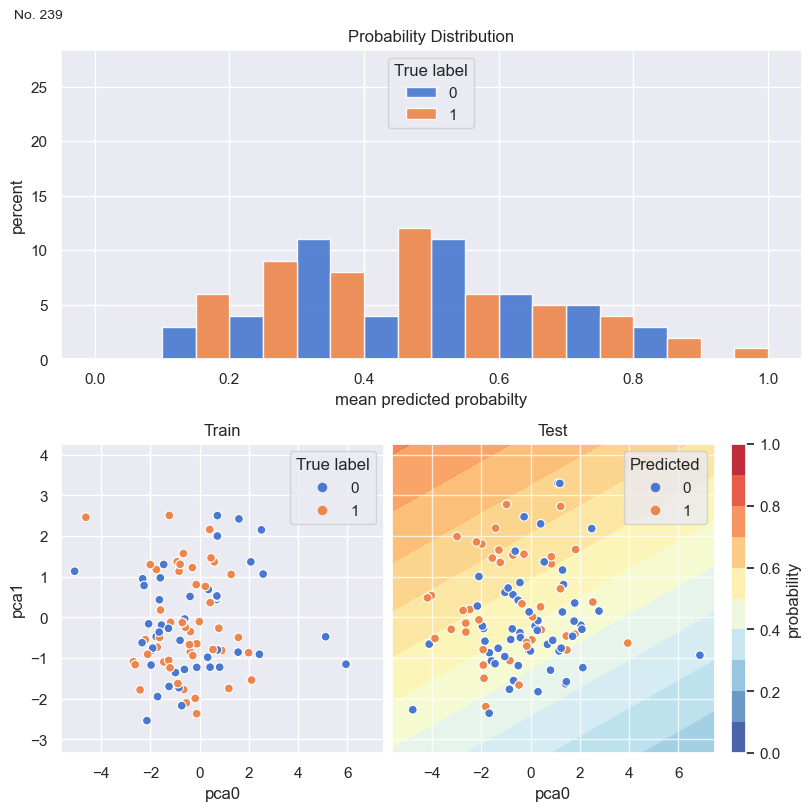

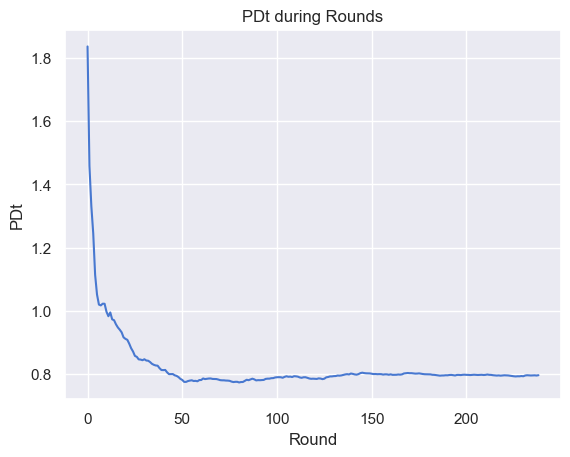

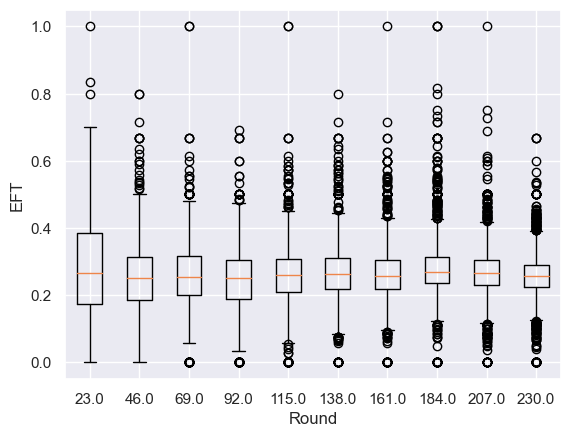

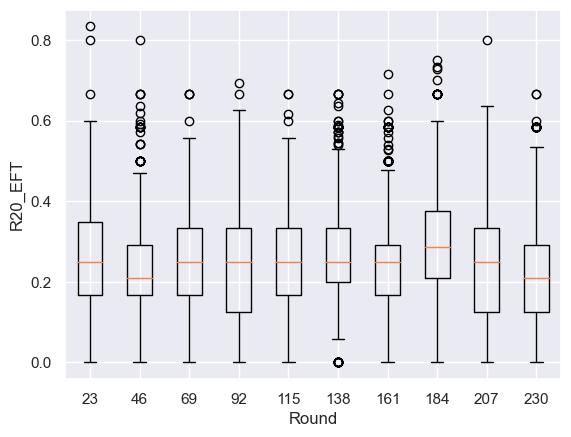

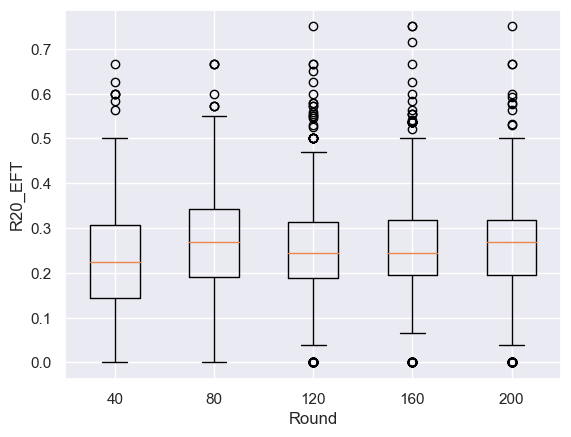

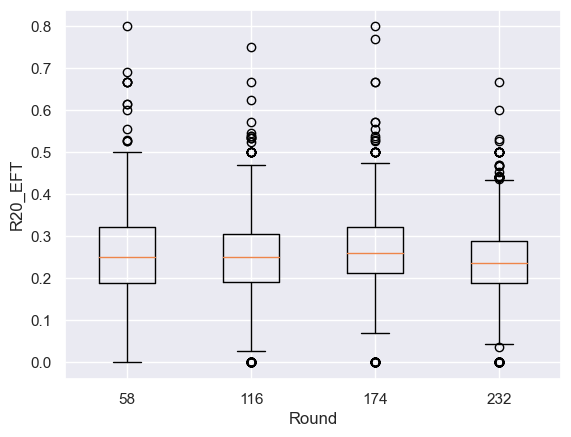

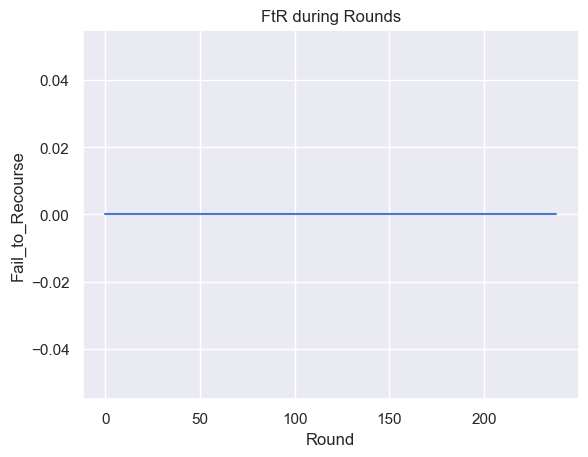

In [ ]:
#主要都寫在裡面，其他的還沒加
class Example8(PlotHelper):
    '''
    Update Method Steps:
    1. Selects a random subset of `sample` with a size of `train.size * 0.02`.
    2. Performs recourse on the selected samples with binomial distributed destination.
    3. Randomly relabels samples based on the model's probability scores.
    4. Replaces a corresponding part of the training set with the updated samples.
    5. Refits the model with the modified training data.
    '''
    
    def update(self, model: nn.Module, train: Dataset, sample: Dataset):
        modelParams = list(model.parameters())
        weights = deepcopy(modelParams[0].data.reshape(-1))
        bias = deepcopy(modelParams[1].data)
        # Selects a random subset of `sample` with a size of `train.size * 0.02`
        size = train.x.shape[0] // 10
        i = np.random.choice(sample.x.shape[0], size, False)
        x = sample.x[i]

        with pt.no_grad():
            y_prob: pt.Tensor = model(x)
        # print("y_prob :",y_prob)
        y_pred = y_prob.flatten() < 0.5
        # print("y_pred :",y_pred)
        
        # Performs recourse on the selected samples with binomial distributed destination.
        binomialData = np.random.binomial(1,0.0001,np.count_nonzero(y_pred)).astype(bool)
        # print("binomial data: ",binomialData)
        y_pred[y_pred == True] = pt.from_numpy(binomialData)
        print("binomial y_pred",y_pred)
        # print("x : ",x)
        # print("x[y_pred] : ",x[y_pred])
        sub_sample = Dataset(x[y_pred], pt.full((y_pred.count_nonzero(), 1), 0.6))

        recourse(model, sub_sample, 5)

        x[y_pred] = sub_sample.x

        #Randomly relabels samples based on the model's probability scores.
        j = np.random.choice(train.x.shape[0], size, False)

        with pt.no_grad():
            y_prob: pt.Tensor = model(x)
        
        # print("y_prob : ",y_prob)
        # print("y_prob[y_pred] :",y_prob[y_pred])

        # Replaces a corresponding part of the training set with the updated samples.
        train.x[j] = x
        train.y[j] = (pt.rand_like(y_prob) > y_prob).float()
        
        # #紀錄新增進來的sample資料
        self.addEFTDataFrame(j)

        training(model, train, 20)
        
        #紀錄Fail_to_Recourse
        if len(x[y_pred]) > 0:
            with pt.no_grad():
                y_prob: pt.Tensor = model(x[y_pred])
            
            # print("x[y_pred] : ",x[y_pred])
            # print("after model update:")
            # print("y_prob:",y_prob)
            # print("y_prob[y_prob < 0.5]",y_prob[y_prob < 0.5])
            recourseFailCnt = len(y_prob[y_prob < 0.5])
            # print("recourseFailCnt",recourseFailCnt)
            recourseFailRate = recourseFailCnt / len(x[y_pred])
            # print("recourseFailRate : ",recourseFailRate)
            self.failToRecourse.append(recourseFailRate)
        else:
            print("no Recourse:")
            self.failToRecourse.append(0)
        
        
        
        self.EFTdataframe = self.EFTdataframe.assign(updateRounds = self.EFTdataframe['updateRounds'] + 1)
        self.round = self.round + 1
        
        #updated model predict the data with new sample
        data = np.vstack(self.EFTdataframe['x'])
        with pt.no_grad():
            y_pred = model(pt.tensor(data,dtype = pt.float))
        # print(y_pred)
        predictValue = deepcopy(y_pred.data)
        predictValue[predictValue > 0.5] = 1.0
        predictValue[predictValue < 0.5] = 0.0
        predictValue = predictValue.numpy().T.reshape(-1)
        # print("predictValue: ",predictValue)
        # print("data type: ",type(predictValue))
        for i in self.EFTdataframe.index:
            # for j in predictValue.numpy().T.reshape(-1):
            self.EFTdataframe.at[i,'Predict'].append(predictValue[i])

            
        # self.EFTdataframe.loc[predictValue.numpy().T.reshape(-1) != self.EFTdataframe['Predict'],['flip_times']] += 1
        for i in self.EFTdataframe.index:
            predictLength = len(self.EFTdataframe.at[i,'Predict'])
            # if predictLength > 1 and (self.EFTdataframe.at[i,'Predict'][predictLength - 2] != self.EFTdataframe.at[i,'Predict'][predictLength - 1]):
            if predictLength > 1 and (self.EFTdataframe.at[i,'Predict'][-2] != self.EFTdataframe.at[i,'Predict'][-1]):
                # self.EFTdataframe.loc[(self.EFTdataframe['rounds'] - self.EFTdataframe['startRounds'] > 1) and self.EFTdataframe['Predict'][self.round - 2] != self.EFTdataframe['Predict'][self.round - 1] ,['flip_times']] += 1
                self.EFTdataframe.at[i,'flip_times'] += 1
        
        # self.EFTdataframe = self.EFTdataframe.assign(Predict = predictValue)

        #update EFP values
        # self.EFTdataframe['EFT'] = self.EFTdataframe['flip_times'] / self.EFTdataframe['rounds']
        self.EFTdataframe.loc[(self.EFTdataframe['updateRounds'] - 1) > 0,['EFT']] = self.EFTdataframe['flip_times'] / (self.EFTdataframe['updateRounds'] - 1)
        
        for i in self.EFTdataframe.index:
            if len(self.EFTdataframe.at[i,'Predict']) > 1:
                # self.EFTdataframe.at[i,'EFTList'].append(self.EFTdataframe.at[i,'flip_times'] / self.EFTdataframe.at[i,'rounds'])
                self.EFTdataframe.at[i,'EFTList'].append(self.EFTdataframe.at[i,'EFT'])
        # else:
        #     self.EFTdataframe = self.EFTdataframe.assign(Predict = predictValue)
        # display(self.EFTdataframe[self.EFTdataframe['flip_times'] > 0])
        display(self.EFTdataframe)
        
        #calculate the PDt
        modelParams = list(model.parameters())
        modelParameter = np.concatenate((weights,bias))
        resultParameter = np.concatenate((modelParams[0].data.reshape(-1),modelParams[1].data))

        parameterL2 = np.linalg.norm(resultParameter - modelParameter)

        self.PDt.append(parameterL2)
        


ex8 = Example8(model, pca, train, test, sample)
ani8 = ex8.animate_all(240)
ani8.save('ex8.gif')

ex8.draw_PDt()
ex8.draw_EFT(240)
ex8.draw_R20_EFT(240,23)
ex8.draw_R20_EFT(240,40)
ex8.draw_R20_EFT(240,58)
print(ex8.failToRecourse)
ex8.draw_Fail_to_Recourse()
display(ex8.EFTdataframe)

In [77]:
a = [i for i in range(40,240,40)]
print(a)
print(len(a))
b = [i for i in range(1,len(a) + 1,1)]
print(b)

[40, 80, 120, 160, 200]
5
[1, 2, 3, 4, 5]
0
1
2
3
4
